
# Packages

In [3]:
import sys
sys.path.append('../')
from estimator.mod_preamble import *

In [71]:
import numpy as np
import os

from joblib import Parallel, delayed

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


from scipy.integrate import quad, nquad
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import chi2
from scipy.special import sph_harm 
from scipy.special import lpmv
from scipy.sparse import lil_matrix

from mpmath import spherharm

from astropy import units as u
from astropy.coordinates import SkyCoord
from tqdm import *
import pandas as pd

import healpy as hp
from healpy.sphtfunc import map2alm
import pyshtools

%matplotlib inline
#%load_ext autoreload
#%autoreload 2

%config InlineBackend.figure_format = 'retina'

In [72]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(edgeitems=3, linewidth=200) 
pd.set_option('display.max_columns', None)
pd.set_option('max_rows',200) and pandas.set_option('max_columns',20)

In [106]:
plt.rcdefaults()
fontsize = 14
from matplotlib import font_manager
font_manager.findfont('serif', rebuild_if_missing=True)
plt.rc('font',**{'family':'serif','serif':['Computer Modern']})
plt.rcParams.update({'font.size':fontsize})

plt.rc('text', usetex=True)
#plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [ ]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

# 1 Load data onto Healpix

## 1.1 Load data

### 1.1.1 Gaia DR2

In [94]:
quasars_pd = pd.read_csv("../data/allwise.csv")
quasars_pd.columns.values

array(['source_id', 'parallax', 'parallax_error', 'ra', 'dec', 'ra_error', 'dec_error', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error', 'pmra_pmdec_corr', 'astrometric_gof_al',
       'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'radial_velocity', 'radial_velocity_error', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al',
       'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_weight_al', 'astrometric_chi2_al', 'matched_observations', 'phot_g_mean_mag'], dtype=object)

In [95]:
ra = quasars_pd['ra'].values
dec = quasars_pd['dec'].values
pmra = quasars_pd['pmra'].values
pmdec = quasars_pd['pmdec'].values
pmra_error = quasars_pd['pmra_error']
pmdec_error = quasars_pd['pmdec_error']
vis_used = quasars_pd['visibility_periods_used']
g_mag = quasars_pd['phot_g_mean_mag']
pm_var = 0.5*(pmra_error**2 + pmdec_error**2)

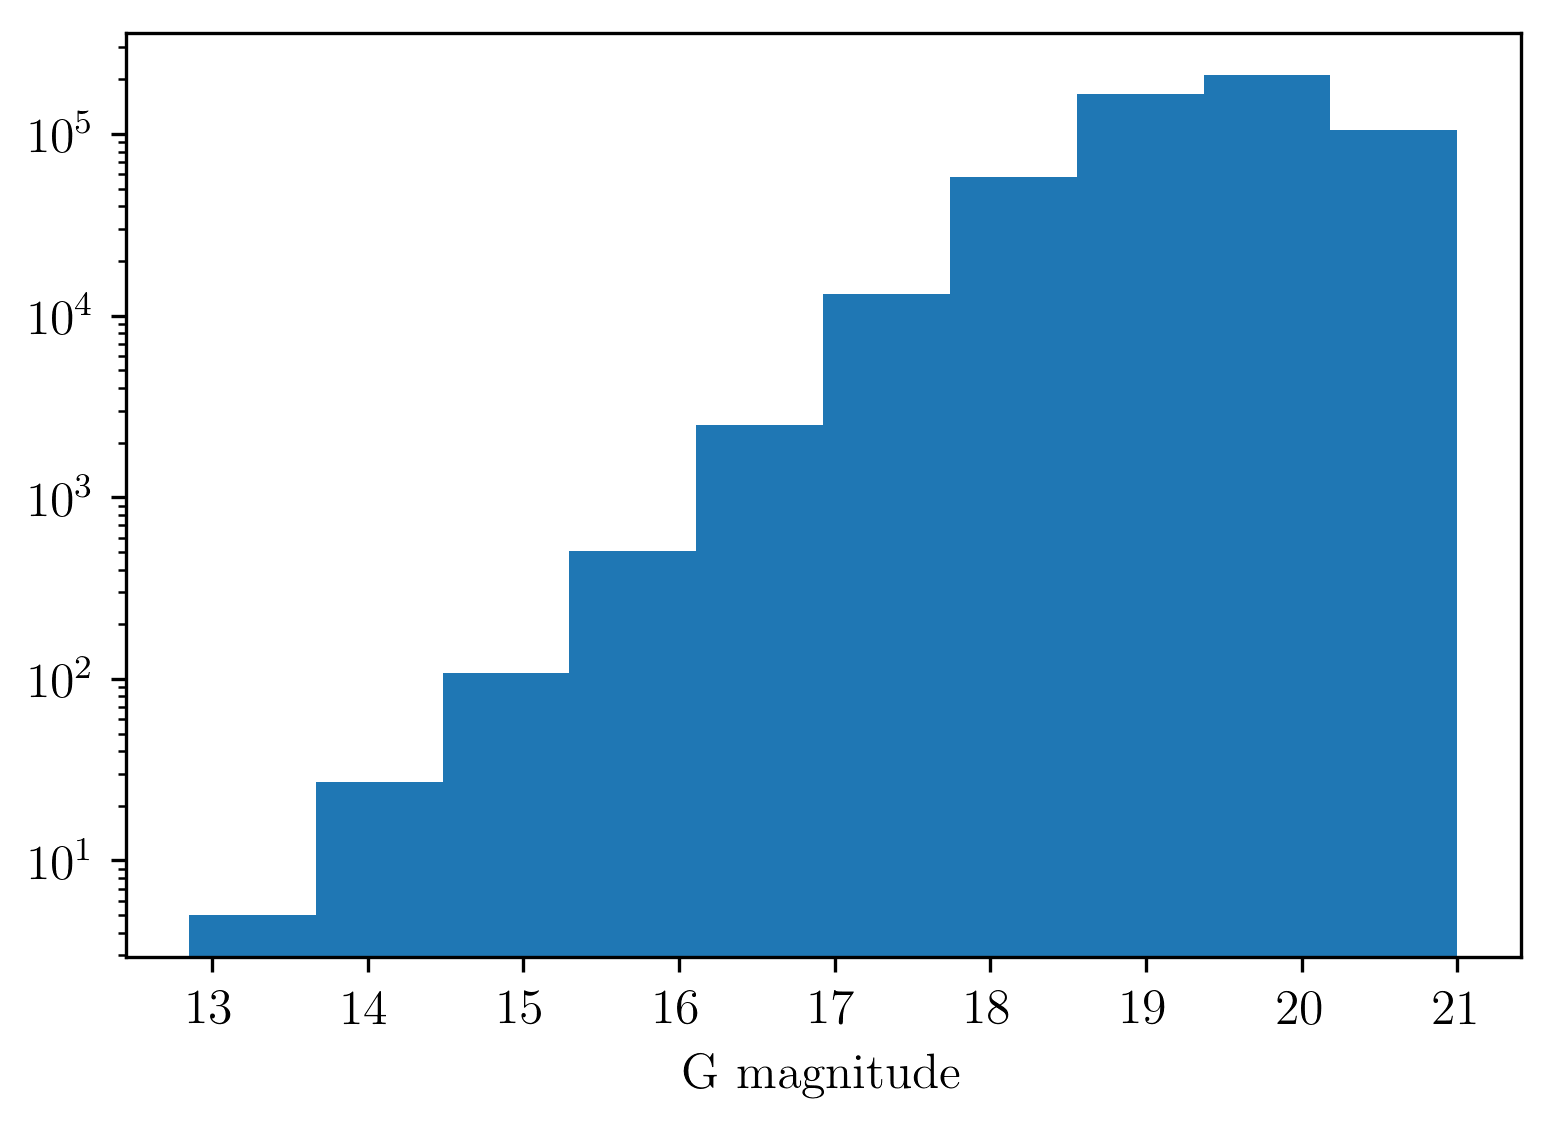

In [96]:
fig, ax = plt.subplots(figsize=(6,4),dpi=150)
ax.hist(g_mag)
ax.set_yscale('log')
ax.set_xlabel('G magnitude');

### 1.1.2 Injection

In [97]:
sample_injection = 0;
#pm_injection = np.load("../data/mu_qsrs_1e10Ms_100pc/mu_qsrs_"+str(sample_injection)+".npy")
#pm_injection = np.load("../data/mu_qsrs_CDM_gauss_nside128/mu_qsrs_"+str(sample_injection)+".npy")
pm_injection = np.load("../data/mu_qsrs_1e8Ms_100pc_uniform_and_quasarsDR2/mu_qsrs_quasarsDR2/mu_qsrs_"+str(sample_injection)+".npy")

In [98]:
np.shape(pm_injection)

(555934, 2)

In [99]:
np.max(abs(pm_injection))

7.781151041472109e-08

### 1.1.3 Combination

In [100]:
quasars_icrs = SkyCoord(ra=ra*u.deg, 
                        dec=dec*u.deg, 
                        pm_ra_cosdec=pmra*u.mas/u.yr, 
                        pm_dec=pmdec*u.mas/u.yr, 
                        frame='icrs')
quasars_gal = quasars_icrs.transform_to('galactic')
l_gal = quasars_gal.l.value
b_gal = quasars_gal.b.value
pm_l_gal = quasars_gal.pm_l_cosb.value
pm_b_gal = quasars_gal.pm_b.value 
# multiplier of data in signal combo
fac = 1
pm_l_gal_injection = 10**3 * pm_injection[:,0]
pm_b_gal_injection = 10**3 * pm_injection[:,1]

In [101]:
len(quasars_icrs)

555934

## 1.2 Healpix

In [102]:
nside = 32
npix = hp.nside2npix(nside)
lmax = 3*nside-1
print('npix =', npix, ', lmax =', lmax, end=None)

q_pix = hp.ang2pix(nside,np.deg2rad(90-b_gal),np.deg2rad(l_gal))

pix_coords = np.asarray(hp.pixelfunc.pix2ang(nside,np.arange(npix))).transpose()

quasars_map = np.zeros(hp.nside2npix(nside))
pm_N_map = np.zeros(hp.nside2npix(nside))
pm_l_map = np.zeros(hp.nside2npix(nside))
pm_b_map = np.zeros(hp.nside2npix(nside))
pm_l_map_injection = np.zeros(hp.nside2npix(nside))
pm_b_map_injection = np.zeros(hp.nside2npix(nside))

npix = 12288 , lmax = 95


In [103]:
for idx, ipix in enumerate(tqdm_notebook((q_pix))):
    quasars_map[ipix] += 1
    pm_N_map[ipix] += 1/pm_var[idx]
    pm_l_map[ipix] += pm_l_gal[idx]/pm_var[idx]
    pm_b_map[ipix] += pm_b_gal[idx]/pm_var[idx]
    pm_l_map_injection[ipix] += pm_l_gal_injection[idx]/pm_var[idx]
    pm_b_map_injection[ipix] += pm_b_gal_injection[idx]/pm_var[idx]

pm_l_map /= (pm_N_map + 10**(-10))
pm_b_map /= (pm_N_map + 10**(-10))
pm_l_map_injection /= (pm_N_map + 10**(-10))
pm_b_map_injection /= (pm_N_map + 10**(-10))
pm_mag_map = np.sqrt(pm_l_map**2 + pm_b_map**2)
pm_mag_map_injection = np.sqrt(pm_l_map_injection**2 + pm_b_map_injection**2)
pm_N_map = np.reciprocal(pm_N_map + 10**(-10))

## 1.3 Plots

/home/kenvt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/kenvt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


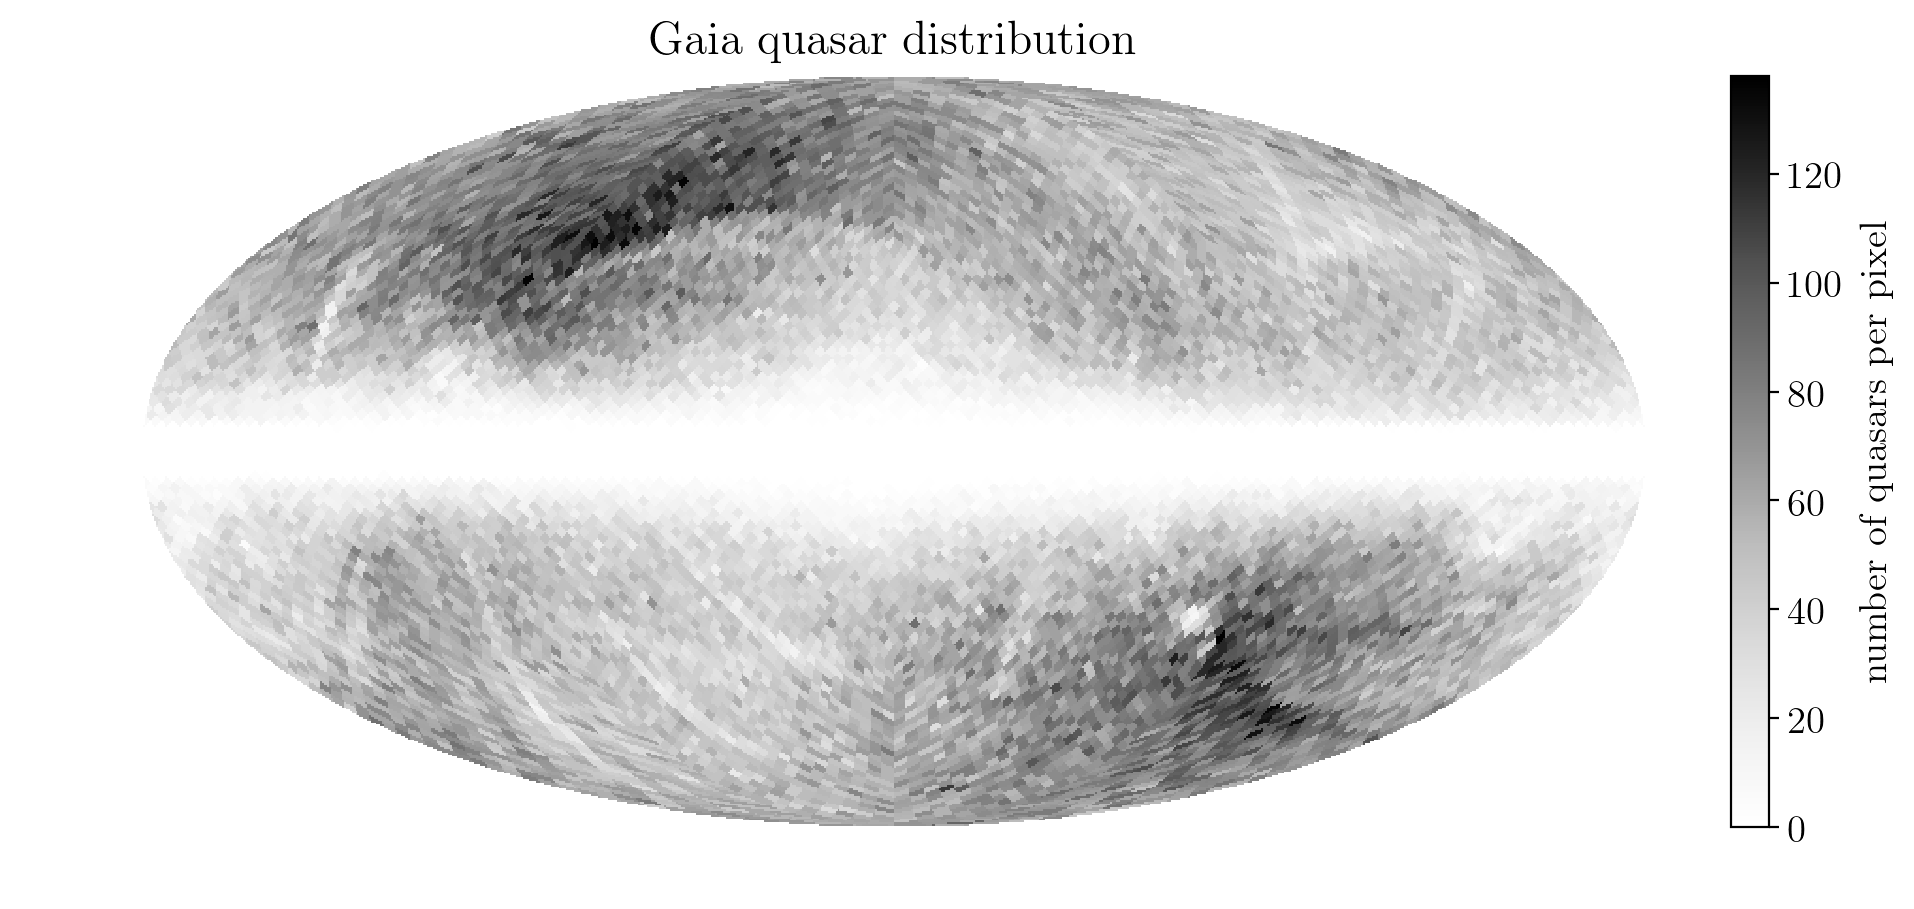

In [107]:
cmap = plt.cm.Greys; cmap.set_bad('white'); cmap.set_under('white'); cmap.set_over('white')
hp.mollview(quasars_map, title="Gaia quasar distribution",min=0, cmap=cmap,cbar=None)

fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'number of quasars per pixel')
fig.savefig('quasars_map.pdf',figsize=(8,6),bbox_extra_artists=(image,),bbox_inches='tight',dpi=300,)

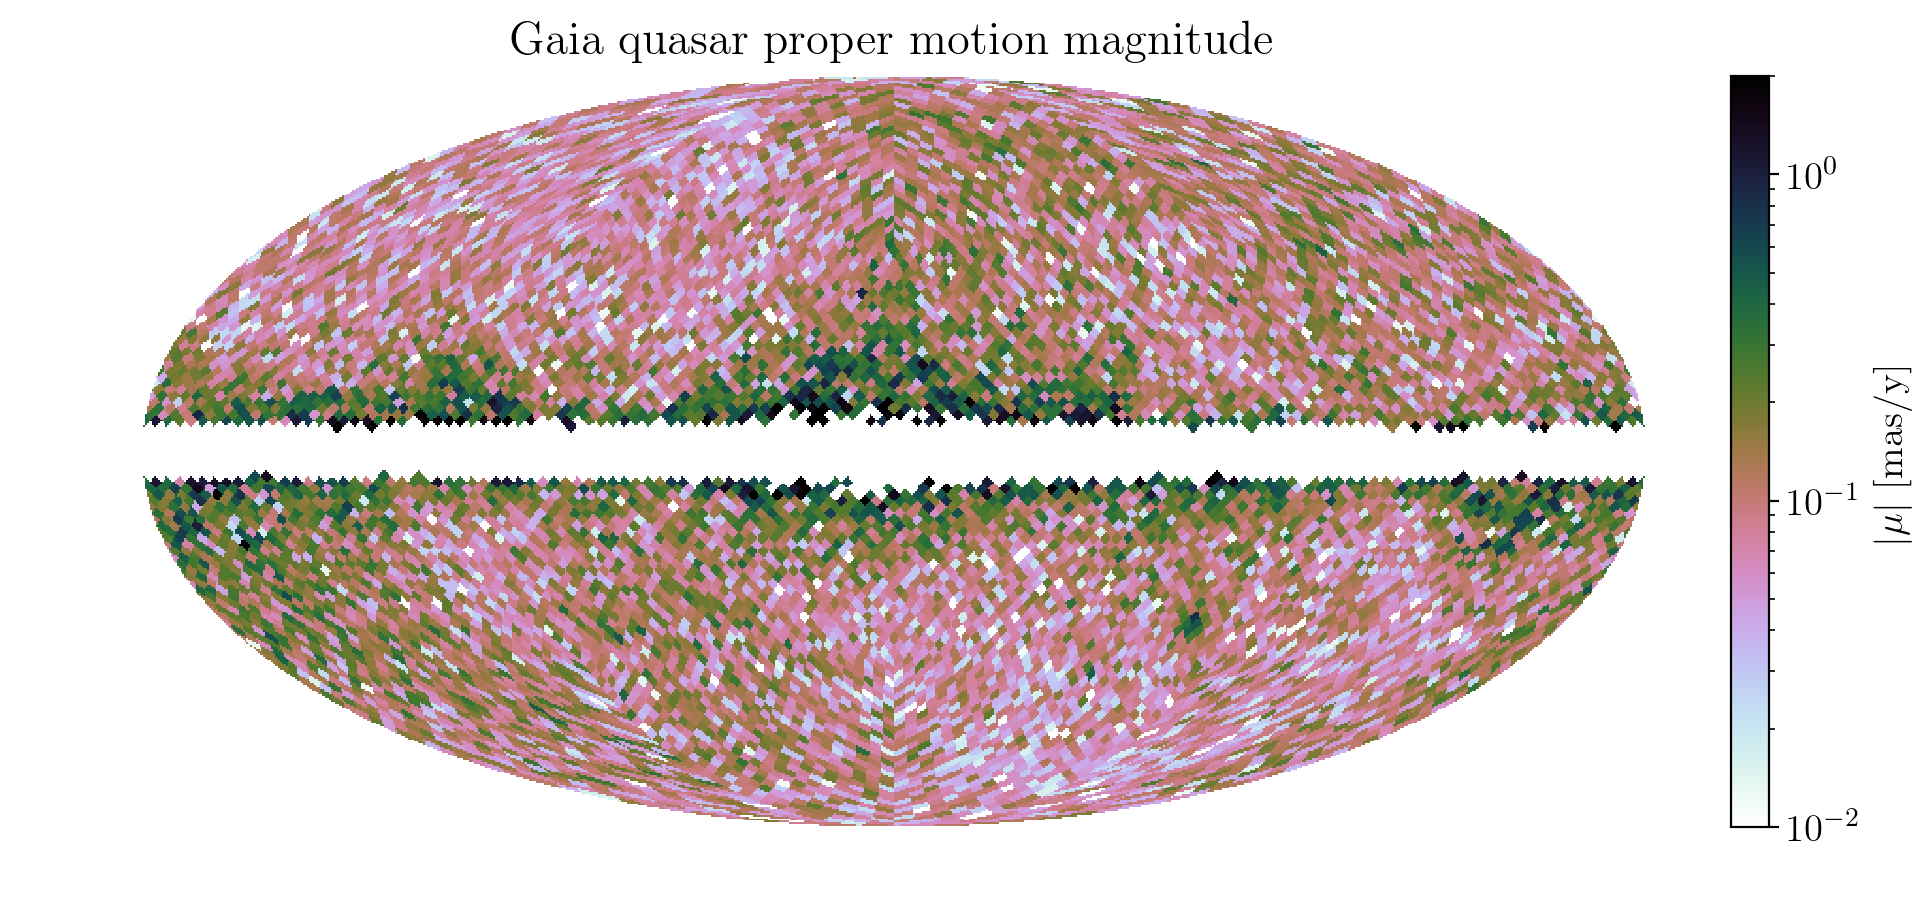

In [108]:
min = 10**(-2); max = 2; 
cmap = plt.cm.cubehelix_r; cmap.set_bad('white'); cmap.set_under('white'); cmap.set_over('black')
hp.mollview(pm_mag_map, title="Gaia quasar proper motion magnitude", min=min,max=max, cmap=cmap,
           norm=colors.LogNorm(vmin=min,vmax=max),cbar=None)

fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$|\mu|\,\,\mathrm{[mas/y]}$')
fig.savefig('quasars_pm_mag_map.pdf',figsize=(8,6),bbox_extra_artists=(image,),bbox_inches='tight',dpi=300,)

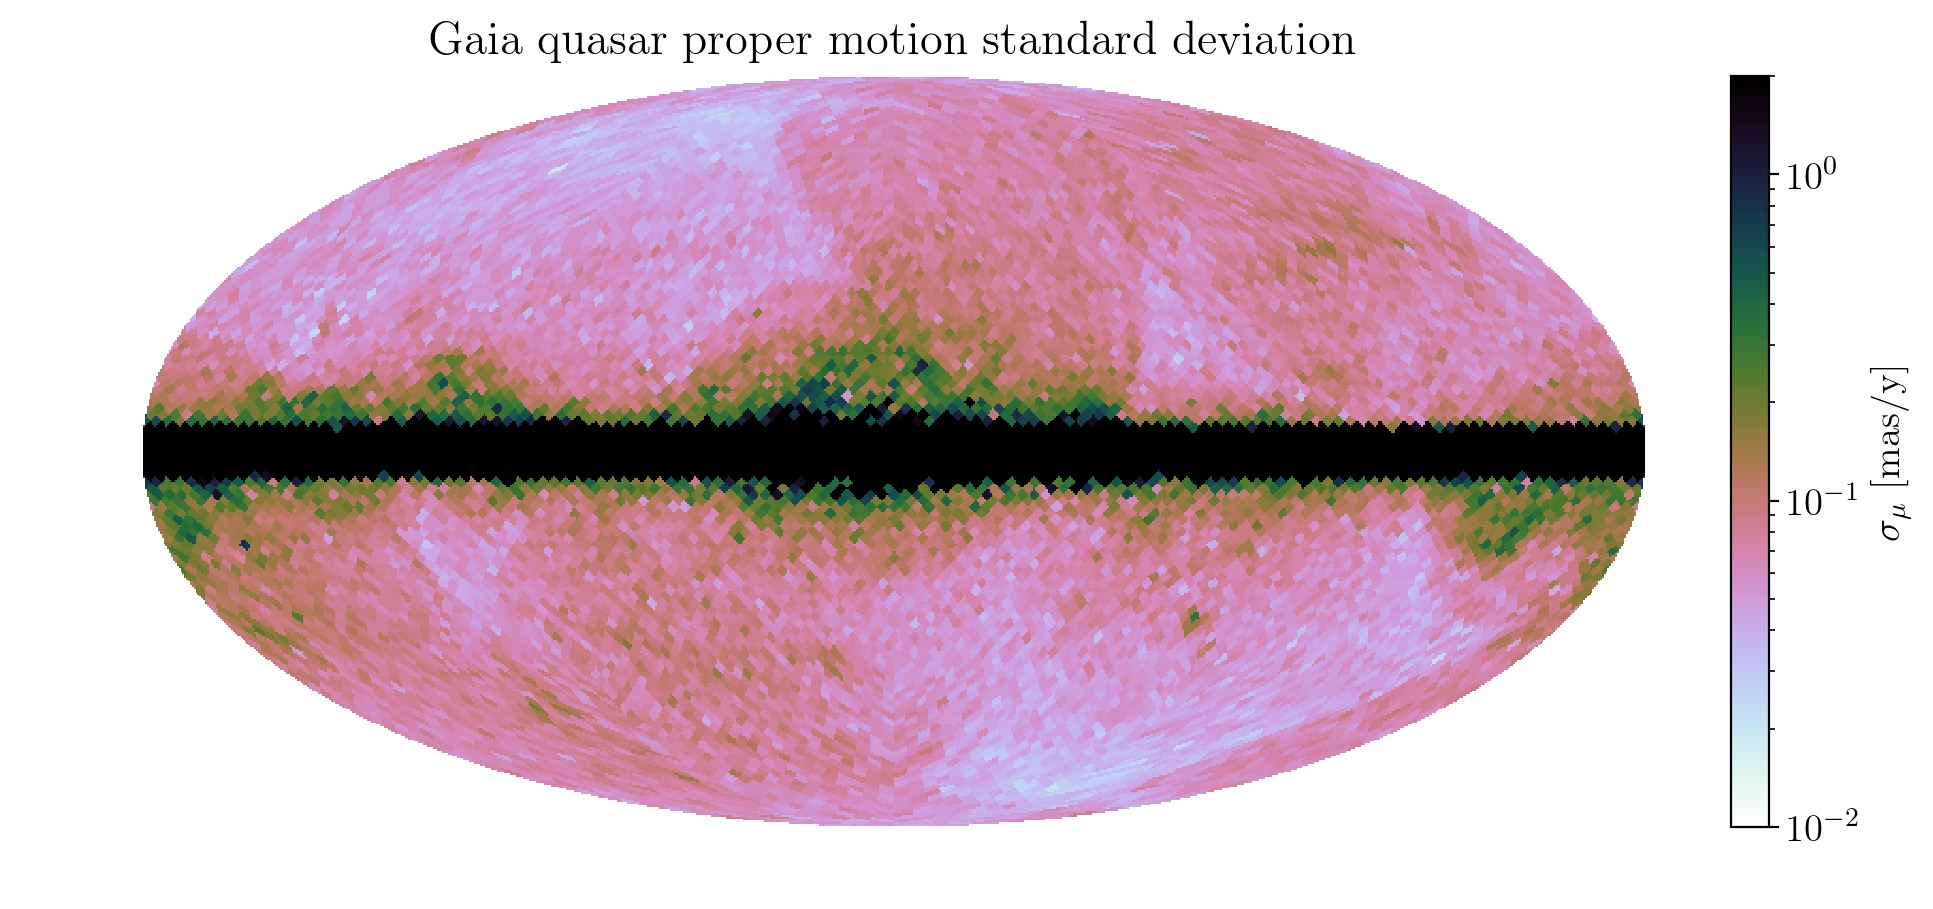

In [109]:
cmap = plt.cm.cubehelix_r; cmap.set_bad('white'); cmap.set_under('white'); cmap.set_over('black')
hp.mollview(np.sqrt(pm_N_map), title="Gaia quasar proper motion standard deviation", min=min,max=max, cmap=cmap,
           norm=colors.LogNorm(vmin=min,vmax=max),cbar=None)

fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\sigma_\mu \,\,\mathrm{[mas/y]}$')
fig.savefig('quasars_pm_N_map.pdf',figsize=(8,6),bbox_extra_artists=(image,),bbox_inches='tight',dpi=300,)

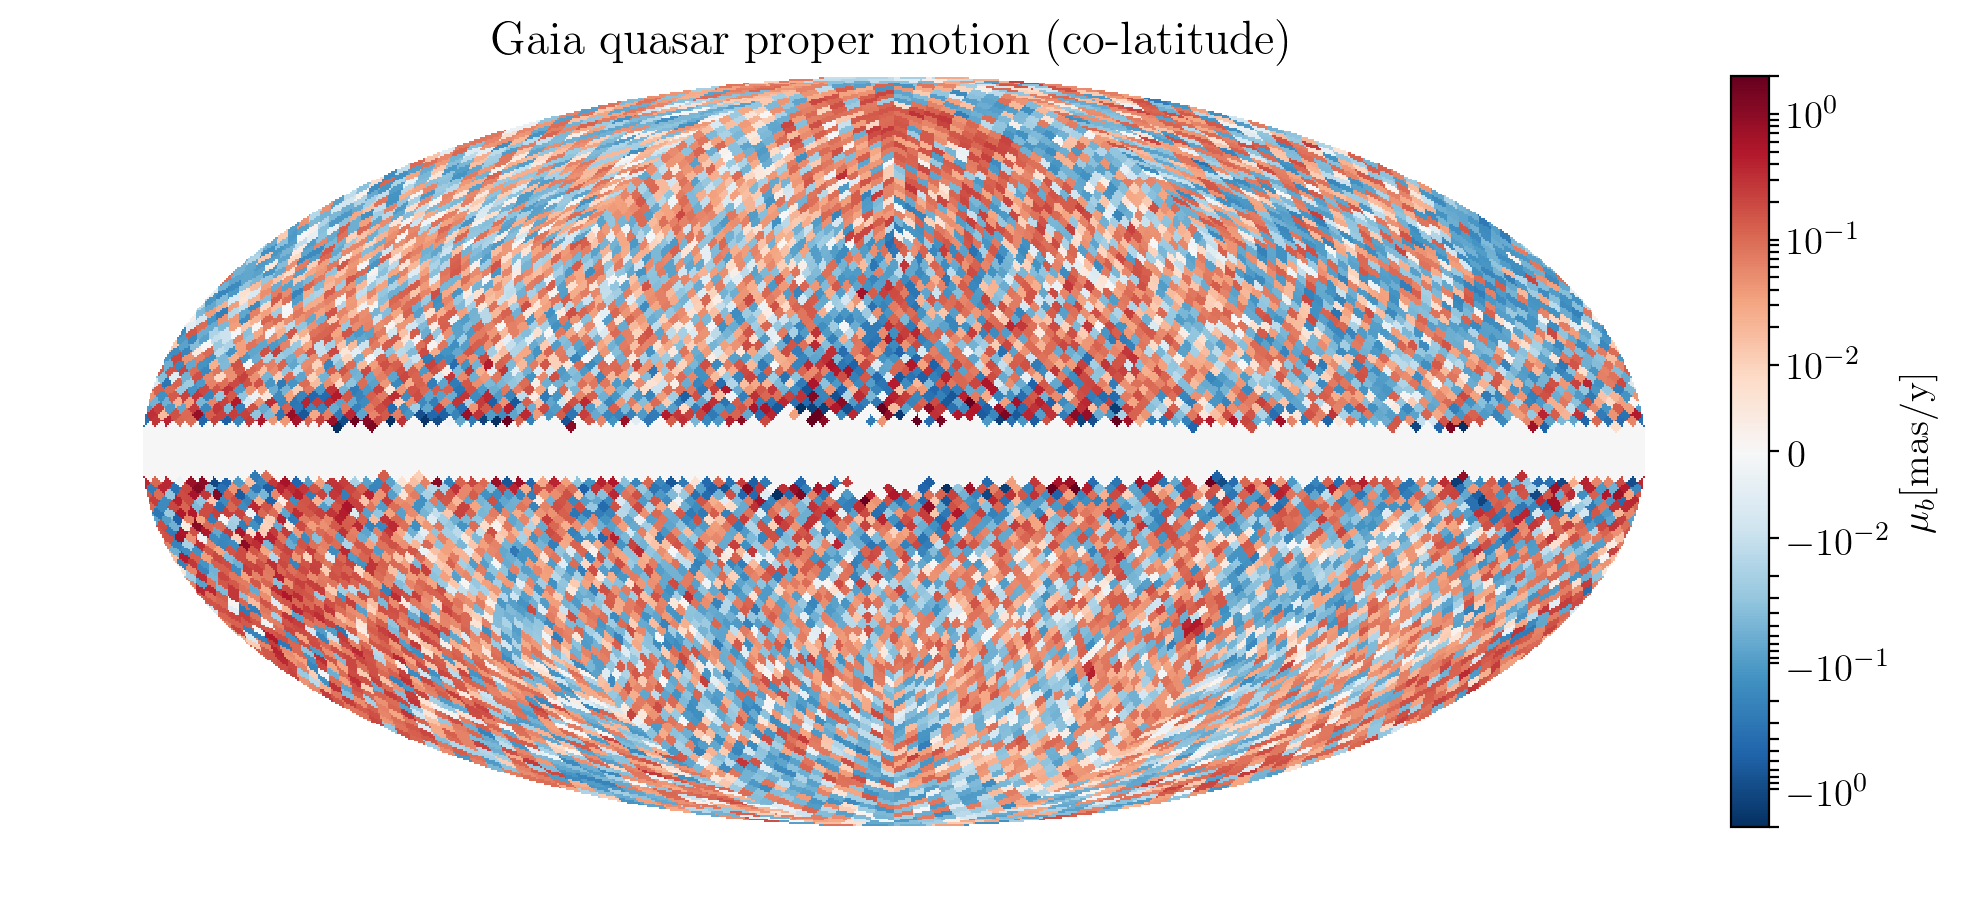

In [110]:
hp.mollview(pm_b_map, title="Gaia quasar proper motion (co-latitude)", min=-max, max=max, cmap='RdBu_r',
            norm=colors.SymLogNorm(linthresh=0.01, linscale=1, vmin=-max, vmax=max),cbar=None)

fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\mu_b \mathrm{[mas/y]}$')
fig.savefig('quasars_pm_b_map.pdf',figsize=(8,6),bbox_extra_artists=(image,),bbox_inches='tight',dpi=300,)

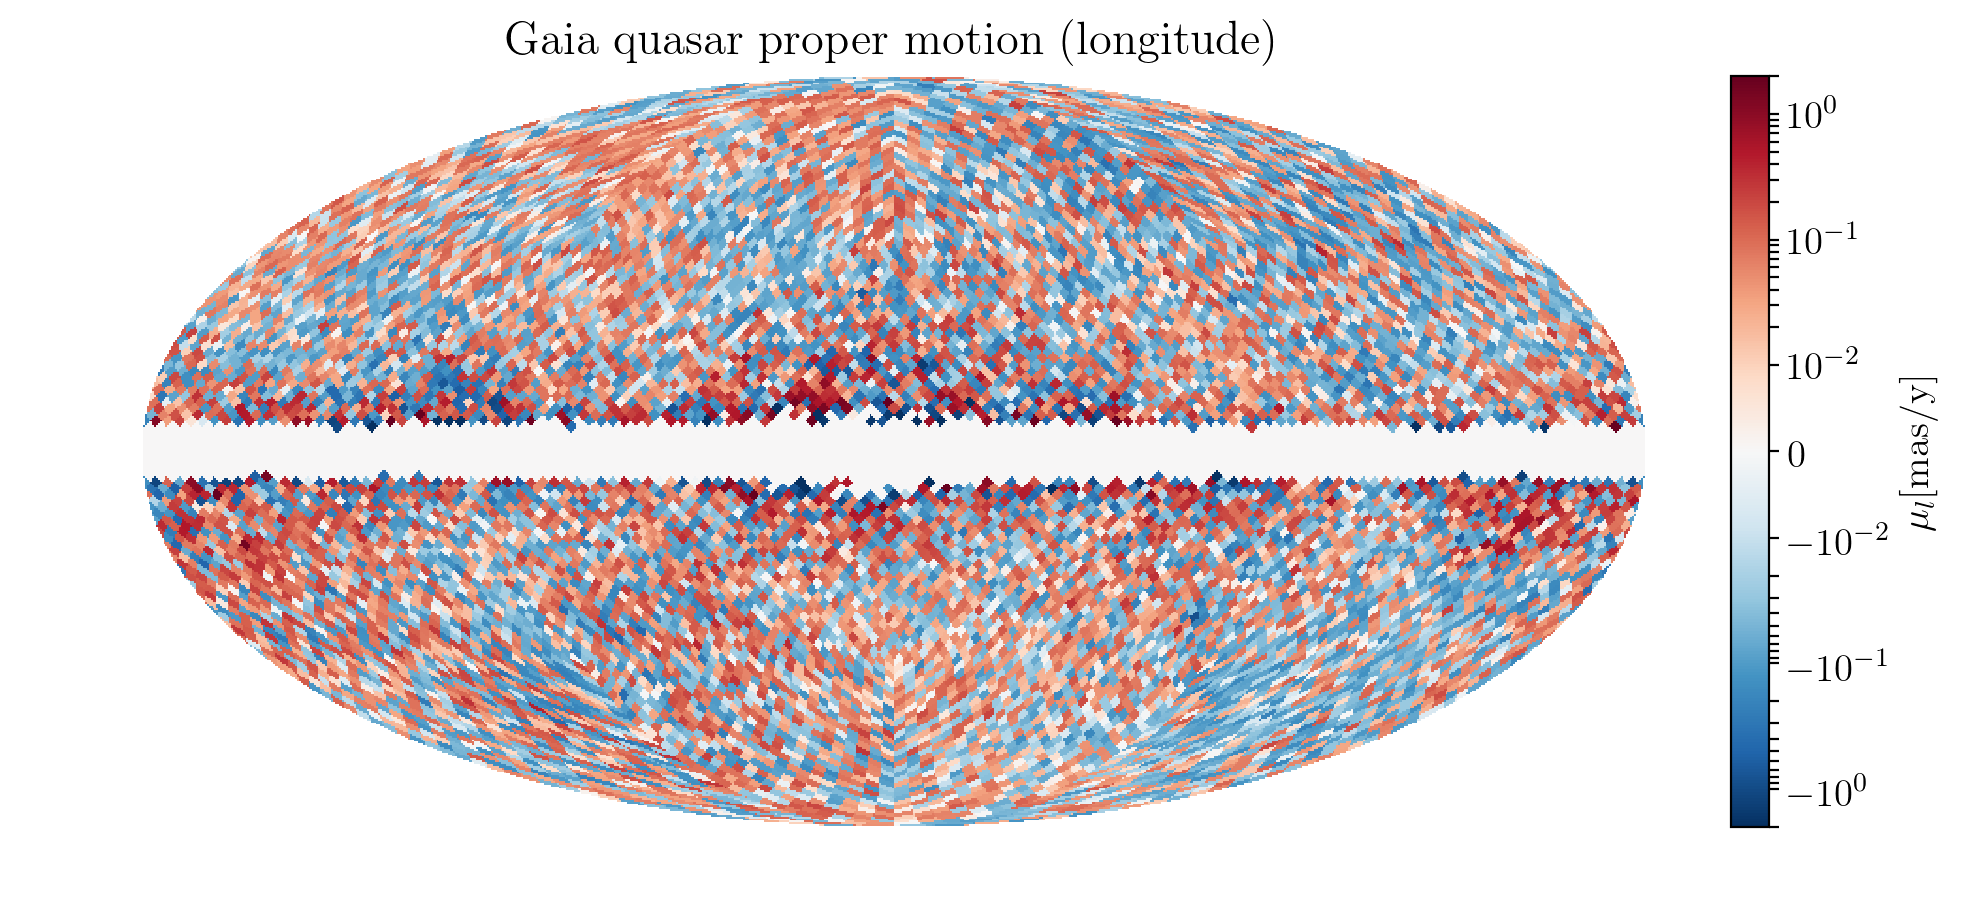

In [111]:
max = 2;
hp.mollview(pm_l_map, title="Gaia quasar proper motion (longitude)", min=-max, max=max, cmap='RdBu_r',
            norm=colors.SymLogNorm(linthresh=0.01, linscale=1, vmin=-max, vmax=max),cbar=None)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\mu_l \mathrm{[mas/y]}$')
fig.savefig('quasars_pm_l_map.pdf',figsize=(8,6),bbox_extra_artists=(image,),bbox_inches='tight',dpi=300,)

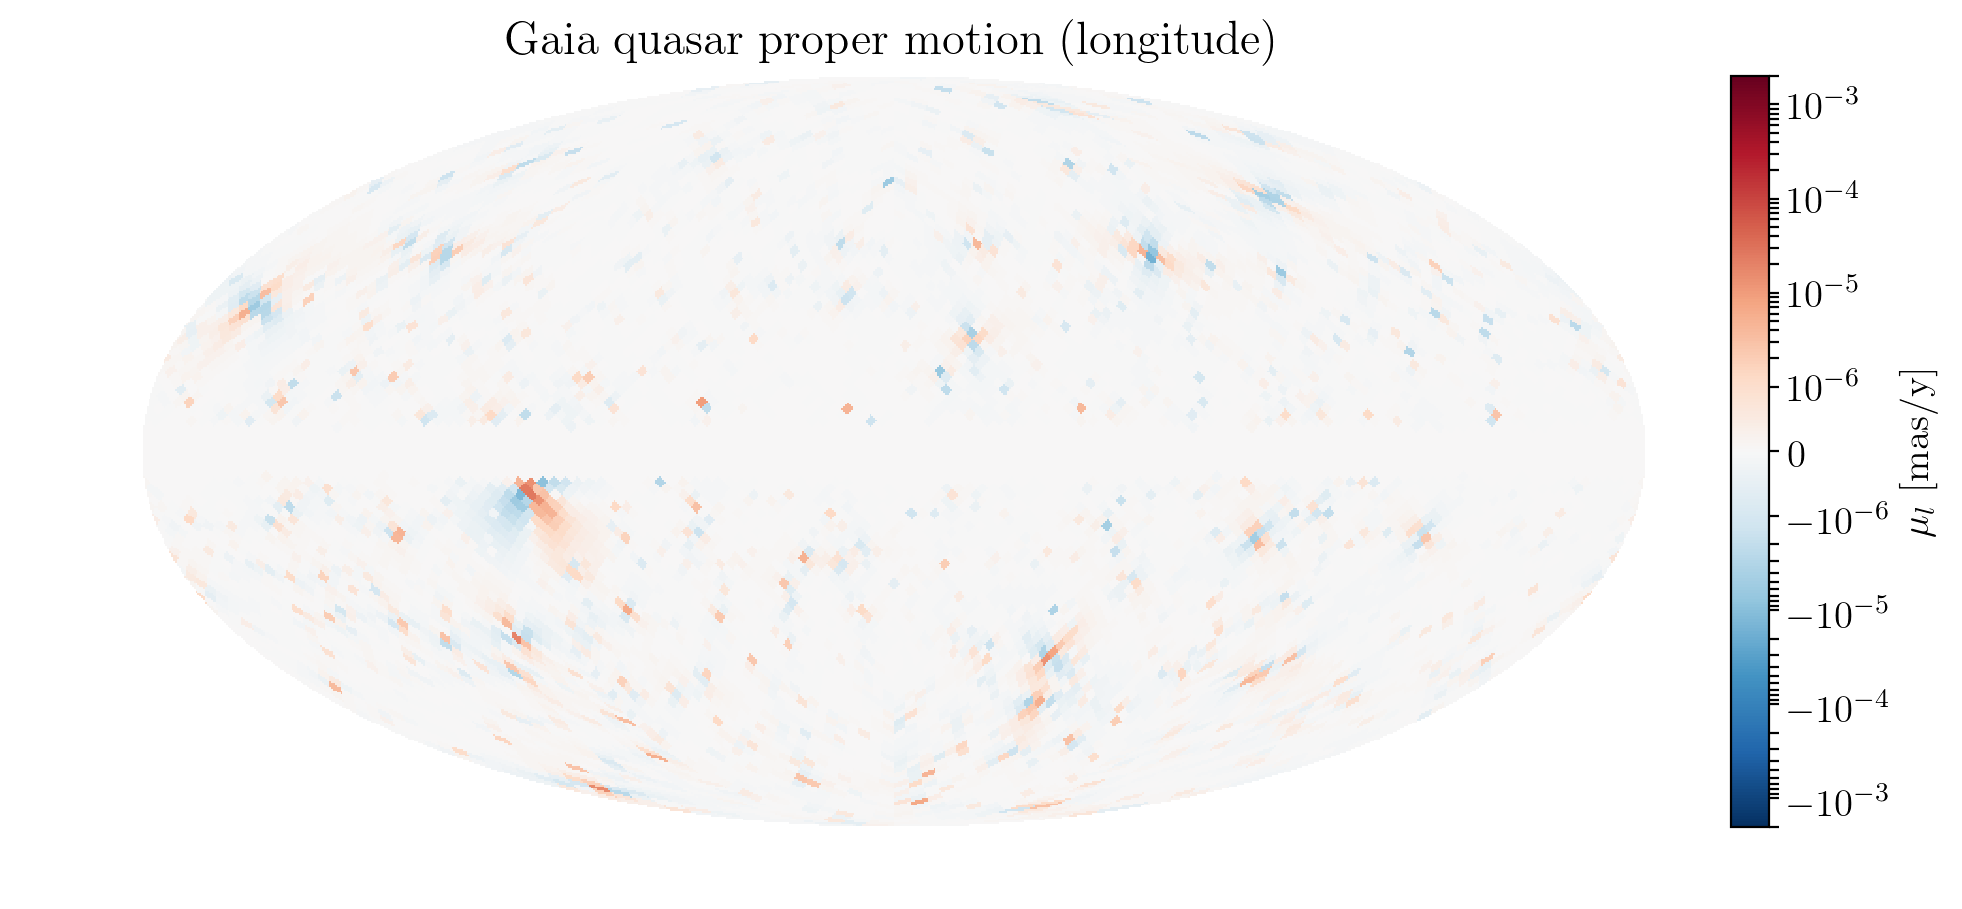

In [112]:
hp.mollview(pm_l_map_injection, title="Gaia quasar proper motion (longitude)", min=-max/1000, max=max/1000, cmap='RdBu_r',
            norm=colors.SymLogNorm(linthresh=10**(-6), linscale=1, vmin=-max, vmax=max),cbar=None)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\mu_l \, \, \mathrm{[mas/y]}$')
fig.savefig('quasars_pm_l_map_injection.pdf',figsize=(8,6),bbox_extra_artists=(image,),bbox_inches='tight',dpi=300,)

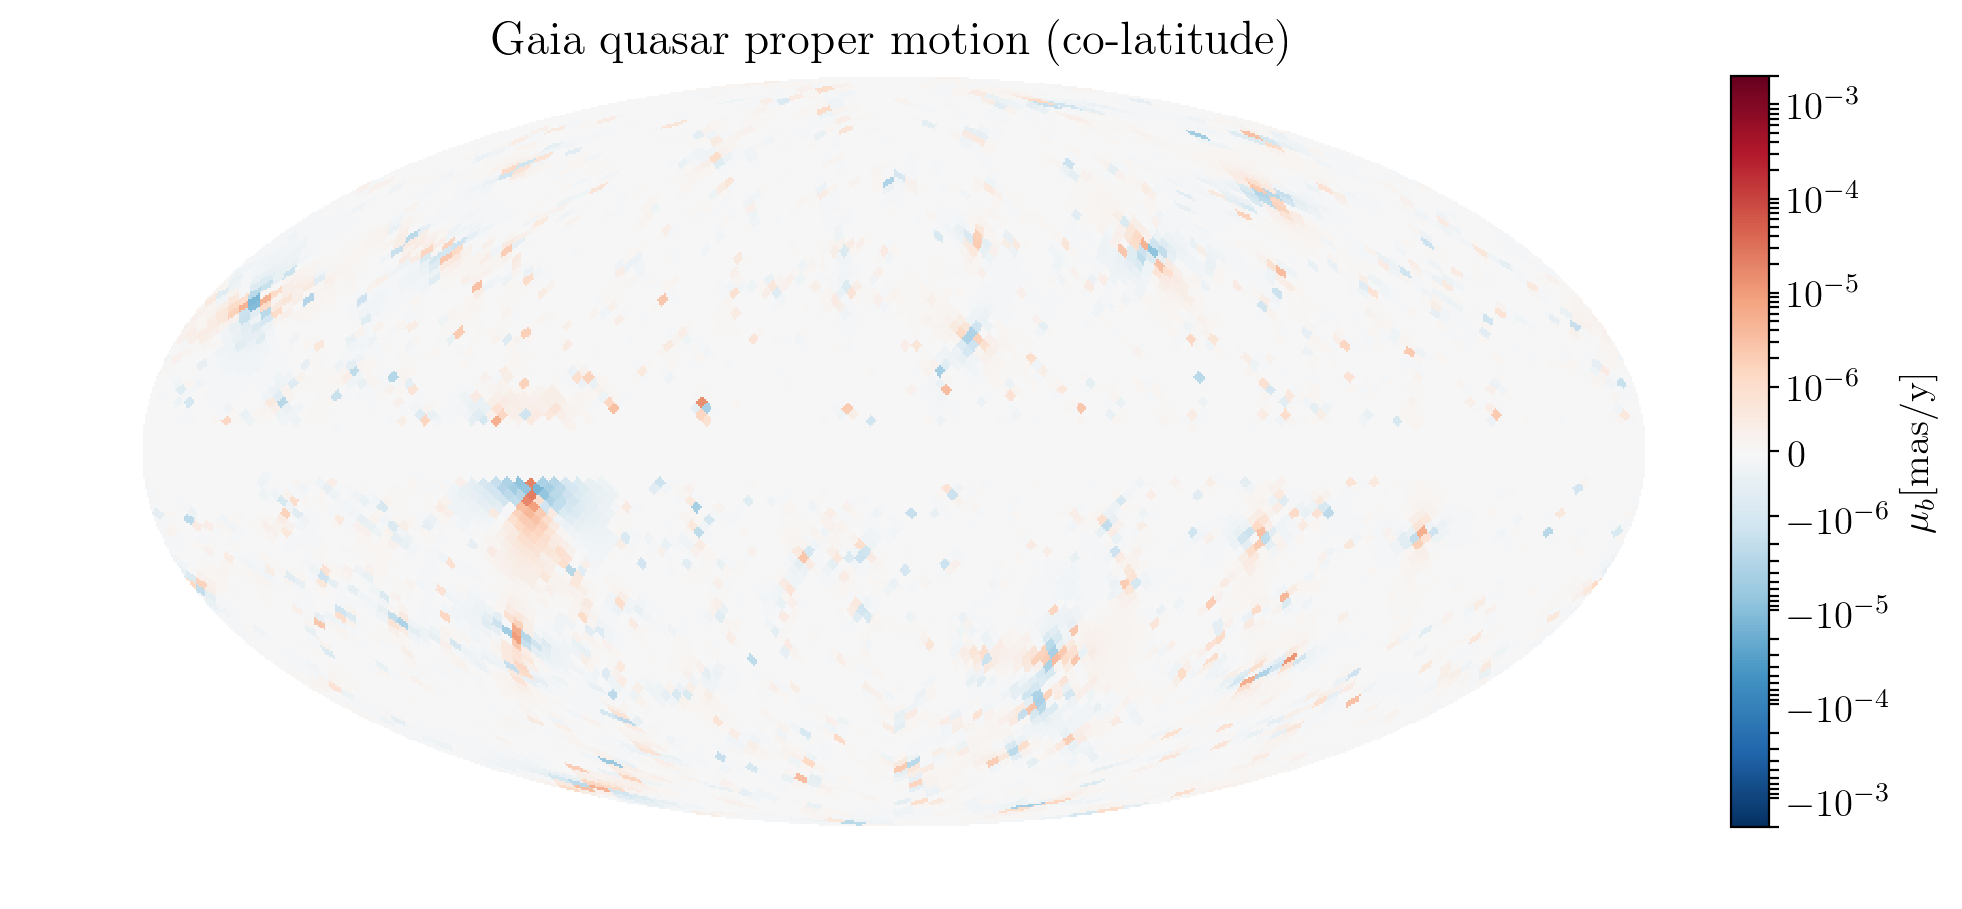

In [113]:
hp.mollview(pm_b_map_injection, title="Gaia quasar proper motion (co-latitude)", min=-max/1000, max=max/1000, cmap='RdBu_r',
            norm=colors.SymLogNorm(linthresh=10**(-6), linscale=1, vmin=-max, vmax=max),cbar=None)

fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\mu_b \mathrm{[mas/y]}$')
fig.savefig('quasars_pm_b_map_injection.pdf',figsize=(8,6),bbox_extra_artists=(image,),bbox_inches='tight',dpi=300,)

# 2 Functions

## 2.1 $Y$ harmonics

### 1.1.1 Harmonic decomposition

In [114]:
from healpy.sphtfunc import Alm

def fn_alm_getidx(lmax,l,m):
    if m >= 0:
        return Alm.getidx(lmax,l,m)
    else:
        return round(0.5*lmax**2 + 1.5*lmax + 1) - (lmax+1) + Alm.getidx(lmax,l,abs(m))
    
def fn_alm_getlm(lmax,idx):
    if idx < round(0.5*lmax**2 + 1.5*lmax + 1):
        return Alm.getlm(lmax,idx)
    else:
        lm_pos =  Alm.getlm(lmax, idx - round(0.5*lmax**2 + 1.5*lmax + 1) + (lmax+1))
        return (lm_pos[0], -lm_pos[1])

In [115]:
def fn_complexmap2alm(map,lmax=3*nside-1):
    """compute the alm coefficients of a complex map"""
    alm_real = map2alm(np.real(map),lmax=lmax)
    alm_imag = map2alm(np.imag(map),lmax=lmax)
    alm_total = alm_real + alm_imag*1j
       
    for idx_lower in range(lmax+1, alm_real.size):
        alm_total = np.concatenate(( alm_total, [(-1)**Alm.getlm(lmax,idx_lower)[1] * (alm_real[idx_lower]-alm_imag[idx_lower]*1j)] ))    
    
    return alm_total

### 1.1.2 Harmonic functions

In [123]:
# scipy version (up to ell = 85)
def fn_Yharm(l,m,theta,phi):
    return sph_harm(m,l,phi,theta)
    
# mpmath version (up to any ell, slow)
def fn_Yharm2(l,m,theta,phi):
    return complex(spherharm(l,m,theta,phi))

In [124]:
def fn_Yharm_map(l,m,npix,pix_coords):
    """spherical harmonic map over healpix with nside defined"""
    tmp_map = np.zeros(npix,dtype=np.complex)
    if l >= 0: #to avoid getting nan outputs when there are l = -1 calls
        for i in np.arange(npix):
            tmp_map[i] += fn_Yharm(l,m,pix_coords[i,0],pix_coords[i,1])
    return tmp_map

def fn_Yharm2_map(l,m,npix,pix_coords):
    """spherical harmonic map over healpix with nside defined"""
    tmp_map = np.zeros(npix,dtype=np.complex)
    if l >= 0: #to avoid getting nan outputs when there are l = -1 calls
        for i in np.arange(npix):
            tmp_map[i] += fn_Yharm2(l,m,pix_coords[i,0],pix_coords[i,1])
    return tmp_map

### 1.1.3 Pre-computation

#### 1.1.3.1 Functions

In [125]:
def fn_spherharm0_map(l,m,theta_vals):
    tmp = np.zeros(len(theta_vals))
    for itheta, theta in enumerate(theta_vals):
        tmp[itheta] = np.float(mp.re(spherharm(l,m,theta,0)))
    return tmp

In [126]:
def fn_spherharm0_map_idx(idx,theta_vals,lmax):
    from mpmath import spherharm
    from mpmath import re
    l,m = fn_alm_getlm(lmax,idx)[0].item(), fn_alm_getlm(lmax,idx)[1].item()
    tmp = np.zeros(len(theta_vals))
    for itheta, theta in enumerate(theta_vals):
        tmp[itheta] = np.float(re(spherharm(l,m,theta,0)))
    return tmp

"spherharm(l, m, theta, phi, **kwargs)"
\begin{align}
Y_{\ell m }(\theta,\phi) = \sqrt{\frac{2l+1}{4\pi}\frac{(l-m)!}{(l+m)!}}
        P_l^m(\cos \theta) e^{i m \phi}
\end{align}
legenp(n, m, z, type=2, **kwargs)
\begin{align}
P_n^m(z) = \frac{1}{\Gamma(1-m)} \frac{(1+z)^{m/2}}{(1-z)^{m/2}} \,_2F_1\left(-n, n+1, 1-m, \frac{1-z}{2}\right).
\end{align}        

#### 1.1.3.2 nside = 32

#### 1.1.3.3 nside = 64

#### 1.1.3.4 nside = 128

### 1.1.4 Pre-computed harmonic functions

In [127]:
mat_spherharm0_map_32 = np.load('../lists/mat_spherharm0_map32.npy')
mat_spherharm0_map_64 = np.load('../lists/mat_spherharm0_map64.npy')
mat_spherharm0_map_128 = np.load('../lists/mat_spherharm0_map128.npy')

In [128]:
pix_flags_32 = np.load('../lists/pix_flags_32.npy')
pix_flags_64 = np.load('../lists/pix_flags_64.npy')
pix_flags_128 = np.load('../lists/pix_flags_128.npy')

In [129]:
pix_coords_32 = np.load('../lists/pix_coords_32.npy')
pix_coords_64 = np.load('../lists/pix_coords_64.npy')
pix_coords_128 = np.load('../lists/pix_coords_128.npy')

In [130]:
theta_vals_32 = np.load('../lists/theta_vals_32.npy')
theta_vals_64 = np.load('../lists/theta_vals_64.npy')
theta_vals_128 = np.load('../lists/theta_vals_128.npy')

In [131]:
phi_vals_32 = np.load('../lists/phi_vals_32.npy')
phi_vals_64 = np.load('../lists/phi_vals_64.npy')
phi_vals_128 = np.load('../lists/phi_vals_128.npy')

In [132]:
np.shape(mat_spherharm0_map_32), np.shape(mat_spherharm0_map_64), np.shape(mat_spherharm0_map_128)

((9216, 127), (36864, 255), (147456, 511))

In [133]:
def fn_Yharm_map_pre_32(l,m):
    """pre-computed spherical harmonic map over healpix with nside = 32"""
    lmax = 95; npix = 12288; 
    idx = fn_alm_getidx(lmax,l,m);
    spherharm0_map = mat_spherharm0_map_32[idx]
    phi_map = np.exp(1j * m * phi_vals_32)
    
    tmp_map = np.zeros(npix,dtype=np.complex)
    if l>=0: #to avoid getting nan outputs at l = -1 calls
        for ipix in range(npix):
            tmp_map[ipix] = spherharm0_map[pix_flags_32[ipix,0]] * phi_map[pix_flags_32[ipix,1]] 
    return tmp_map

In [134]:
def fn_Yharm_map_pre_64(l,m):
    """pre-computed spherical harmonic map over healpix with nside = 32"""
    lmax = 191; npix = 49152; 
    idx = fn_alm_getidx(lmax,l,m);
    spherharm0_map = mat_spherharm0_map_64[idx]
    phi_map = np.exp(1j * m * phi_vals_64)
    
    tmp_map = np.zeros(npix,dtype=np.complex)
    if l>=0: #to avoid getting nan outputs at l = -1 calls
        for ipix in range(npix):
            tmp_map[ipix] = spherharm0_map[pix_flags_64[ipix,0]] * phi_map[pix_flags_64[ipix,1]] 
    return tmp_map

In [135]:
def fn_Yharm_map_pre_128(l,m):
    """pre-computed spherical harmonic map over healpix with nside = 32"""
    lmax = 383; npix = 196608; 
    idx = fn_alm_getidx(lmax,l,m);
    spherharm0_map = mat_spherharm0_map_128[idx]
    phi_map = np.exp(1j * m * phi_vals_128)
    
    tmp_map = np.zeros(npix,dtype=np.complex)
    if l>=0: #to avoid getting nan outputs at l = -1 calls
        for ipix in range(npix):
            tmp_map[ipix] = spherharm0_map[pix_flags_128[ipix,0]] * phi_map[pix_flags_128[ipix,1]] 
    return tmp_map

In [57]:
np.sum(fn_Yharm_map_pre_128(10,4) * np.conj(fn_Yharm_map_pre_128(10,4))) / (196608/(4 * np.pi))

(1.0000040346301224+0j)

## 2.2 Vector spherical harmonics

### 2.2.1 Coefficients

In [136]:
def fn_c_coeff(c_idx,l,m):
    if c_idx == 1:
        return np.sqrt((l+1)*(l-m)*(l+m) / ( (l)*(2*l-1)*(2*l+1) + 10**(-10)) )
    elif c_idx == 2:
        return - np.sqrt((l)*(l-m+1)*(l+m+1) / ( (l+1)*(2*l+3)*(2*l+1) + 10**(-10)) )
    elif c_idx == 3:
        return (1j)*m/np.sqrt(l*(l+1) + 10**(-10))

### 2.2.2 Maps

In [193]:
def fn_sin_map(npix=npix,pix_coords=pix_coords):
    """map of 1/sin(theta) over healpix map"""
    tmp_map = np.zeros(npix,dtype=np.complex)
    for i in np.arange(npix):
        tmp_map[i] = np.sin(pix_coords[i,0])
    return tmp_map

In [194]:
def fn_sin_inv_map(npix=npix,pix_coords=pix_coords):
    """map of 1/sin(theta) over healpix map"""
    tmp_map = np.zeros(npix,dtype=np.complex)
    for i in np.arange(npix):
        sin_val = np.sin(pix_coords[i,0])
        if abs(sin_val)>0:
            tmp_map[i]= 1/sin_val
        else:
            tmp_map[i]= 10**{40}       
    return tmp_map

In [139]:
# scipy version
def fn_Aharm_map(l,m,npix,pix_coords):
    """A harmonic map over healpix with nside defined"""
    tmp_map = np.zeros(npix,dtype=np.complex)
    if l > 0: #to avoid getting nan outputs when there are l = -1 calls
        if l > abs(m):
            for i in np.arange(npix):
                tmp_map[i] += fn_c_coeff(1,l,m)*fn_Yharm(l-1,m,pix_coords[i,0],pix_coords[i,1]) + fn_c_coeff(2,l,m)*fn_Yharm(l+1,m,pix_coords[i,0],pix_coords[i,1])
        elif l == abs(m): #to avoid getting nan outputs when l-1 < abs(m)
            for i in np.arange(npix):
                tmp_map[i] += fn_c_coeff(2,l,m)*fn_Yharm(l+1,m,pix_coords[i,0],pix_coords[i,1])
    elif l==0:
        for i in np.arange(npix):
            tmp_map[i] += fn_c_coeff(2,l,m)*fn_Yharm(l+1,m,pix_coords[i,0],pix_coords[i,1])
    return tmp_map

def fn_Bharm_map(l,m,npix,pix_coords):
    """B harmonic map over healpix with nside defined"""
    tmp_map = np.zeros(npix,dtype=np.complex)
    if l > 0: #to avoid dividing by zero
        for i in np.arange(npix):
            tmp_map[i] += fn_c_coeff(3,l,m)*fn_Yharm(l,m,pix_coords[i,0],pix_coords[i,1])
    return tmp_map

def fn_Psiharm_map(l,m,npix,pix_coords):
    """Psi harmonic map over healpix with nside defined"""
    theta_comp_map = -fn_sin_inv_map(npix,pix_coords)*fn_Aharm_map(l,m,npix,pix_coords)
    phi_comp_map = -fn_sin_inv_map(npix,pix_coords)*fn_Bharm_map(l,m,npix,pix_coords)
    return np.transpose([theta_comp_map,phi_comp_map])

def fn_Phiharm_map(l,m,npix,pix_coords):
    """Psi harmonic map over healpix with nside defined"""
    phi_comp_map = -fn_sin_inv_map(npix,pix_coords)*fn_Aharm_map(l,m,npix,pix_coords)
    theta_comp_map = +fn_sin_inv_map(npix,pix_coords)*fn_Bharm_map(l,m,npix,pix_coords)
    return np.transpose([theta_comp_map,phi_comp_map])

In [140]:
# mpmath version
def fn_Aharm2_map(l,m,npix,pix_coords):
    """A harmonic map over healpix with nside defined"""
    tmp_map = np.zeros(npix,dtype=np.complex)
    if l > 0: #to avoid getting nan outputs when there are l = -1 calls
        if l > abs(m):
            for i in np.arange(npix):
                tmp_map[i] += fn_c_coeff(1,l,m)*fn_Yharm2(l-1,m,pix_coords[i,0],pix_coords[i,1]) + fn_c_coeff(2,l,m)*fn_Yharm2(l+1,m,pix_coords[i,0],pix_coords[i,1])
        elif l == abs(m): #to avoid getting nan outputs when l-1 < abs(m)
            for i in np.arange(npix):
                tmp_map[i] += fn_c_coeff(2,l,m)*fn_Yharm2(l+1,m,pix_coords[i,0],pix_coords[i,1])
    elif l==0:
        for i in np.arange(npix):
            tmp_map[i] += fn_c_coeff(2,l,m)*fn_Yharm2(l+1,m,pix_coords[i,0],pix_coords[i,1])
    return tmp_map

def fn_Bharm2_map(l,m,npix,pix_coords):
    """B harmonic map over healpix with nside defined"""
    tmp_map = np.zeros(npix,dtype=np.complex)
    if l > 0: #to avoid dividing by zero
        for i in np.arange(npix):
            tmp_map[i] += fn_c_coeff(3,l,m)*fn_Yharm2(l,m,pix_coords[i,0],pix_coords[i,1])
    return tmp_map

def fn_Psiharm2_map(l,m,npix,pix_coords):
    """Psi harmonic map over healpix with nside defined"""
    theta_comp_map = -fn_sin_inv_map(npix,pix_coords)*fn_Aharm2_map(l,m,npix,pix_coords)
    phi_comp_map = -fn_sin_inv_map(npix,pix_coords)*fn_Bharm2_map(l,m,npix,pix_coords)
    return np.transpose([theta_comp_map,phi_comp_map])

def fn_Phiharm2_map(l,m,npix,pix_coords):
    """Psi harmonic map over healpix with nside defined"""
    phi_comp_map = -fn_sin_inv_map(npix,pix_coords)*fn_Aharm2_map(l,m,npix,pix_coords)
    theta_comp_map = +fn_sin_inv_map(npix,pix_coords)*fn_Bharm2_map(l,m,npix,pix_coords)
    return np.transpose([theta_comp_map,phi_comp_map])

### 2.2.3 Pre-computed maps

In [195]:
sin_inv_map_32 = fn_sin_inv_map(len(pix_coords_32),pix_coords_32)
sin_inv_map_64 = fn_sin_inv_map(len(pix_coords_64),pix_coords_64)
sin_inv_map_128 = fn_sin_inv_map(len(pix_coords_128),pix_coords_128)

In [141]:
# nside = 32
def fn_Aharm_map_pre_32(l,m):
    """A harmonic map over healpix with nside defined"""
    if l > 0: #to avoid getting nan outputs when there are l = -1 calls
        if l > abs(m):
            return fn_c_coeff(1,l,m)*fn_Yharm_map_pre_32(l-1,m) + fn_c_coeff(2,l,m)*fn_Yharm_map_pre_32(l+1,m)
        elif l == abs(m): #to avoid getting nan outputs when l-1 < abs(m)
            return fn_c_coeff(2,l,m)*fn_Yharm_map_pre_32(l+1,m)
    elif l==0:
        return fn_c_coeff(2,l,m)*fn_Yharm_map_pre_32(l+1,m)
    
def fn_Bharm_map_pre_32(l,m):
    """B harmonic map over healpix with nside defined"""
    if l > 0: #to avoid dividing by zero
        return fn_c_coeff(3,l,m)*fn_Yharm_map_pre_32(l,m)
    else:
        return 0 * fn_c_coeff(3,l,m)*fn_Yharm_map_pre_32(0,0)
    
def fn_Psiharm_map_pre_32(l,m):
    """Psi harmonic map over healpix with nside defined"""
    theta_comp_map = -sin_inv_map_32*fn_Aharm_map_pre_32(l,m)
    phi_comp_map = -sin_inv_map_32*fn_Bharm_map_pre_32(l,m)
    return np.transpose([theta_comp_map,phi_comp_map])

def fn_Phiharm_map_pre_32(l,m):
    """Phi harmonic map over healpix with nside defined"""
    phi_comp_map = -sin_inv_map_32*fn_Aharm_map_pre_32(l,m)
    theta_comp_map = +sin_inv_map_32*fn_Bharm_map_pre_32(l,m)
    return np.transpose([theta_comp_map,phi_comp_map])

In [142]:
# nside = 64
def fn_Aharm_map_pre_64(l,m):
    """A harmonic map over healpix with nside defined"""
    if l > 0: #to avoid getting nan outputs when there are l = -1 calls
        if l > abs(m):
            return fn_c_coeff(1,l,m)*fn_Yharm_map_pre_64(l-1,m) + fn_c_coeff(2,l,m)*fn_Yharm_map_pre_64(l+1,m)
        elif l == abs(m): #to avoid getting nan outputs when l-1 < abs(m)
            return fn_c_coeff(2,l,m)*fn_Yharm_map_pre_64(l+1,m)
    elif l==0:
        return fn_c_coeff(2,l,m)*fn_Yharm_map_pre_64(l+1,m)
    
def fn_Bharm_map_pre_64(l,m):
    """B harmonic map over healpix with nside defined"""
    if l > 0: #to avoid dividing by zero
        return fn_c_coeff(3,l,m)*fn_Yharm_map_pre_64(l,m)
    else:
        return 0 * fn_c_coeff(3,l,m)*fn_Yharm_map_pre_64(0,0)
    
def fn_Psiharm_map_pre_64(l,m):
    """Psi harmonic map over healpix with nside defined"""
    theta_comp_map = -sin_inv_map_64*fn_Aharm_map_pre_64(l,m)
    phi_comp_map = -sin_inv_map_64*fn_Bharm_map_pre_64(l,m)
    return np.transpose([theta_comp_map,phi_comp_map])

def fn_Phiharm_map_pre_64(l,m):
    """Phi harmonic map over healpix with nside defined"""
    phi_comp_map = -sin_inv_map_64*fn_Aharm_map_pre_64(l,m)
    theta_comp_map = +sin_inv_map_64*fn_Bharm_map_pre_64(l,m)
    return np.transpose([theta_comp_map,phi_comp_map])

In [143]:
# nside = 128
def fn_Aharm_map_pre_128(l,m):
    """A harmonic map over healpix with nside defined"""
    if l > 0: #to avoid getting nan outputs when there are l = -1 calls
        if l > abs(m):
            return fn_c_coeff(1,l,m)*fn_Yharm_map_pre_128(l-1,m) + fn_c_coeff(2,l,m)*fn_Yharm_map_pre_128(l+1,m)
        elif l == abs(m): #to avoid getting nan outputs when l-1 < abs(m)
            return fn_c_coeff(2,l,m)*fn_Yharm_map_pre_128(l+1,m)
    elif l==0:
        return fn_c_coeff(2,l,m)*fn_Yharm_map_pre_128(l+1,m)
    
def fn_Bharm_map_pre_128(l,m):
    """B harmonic map over healpix with nside defined"""
    if l > 0: #to avoid dividing by zero
        return fn_c_coeff(3,l,m)*fn_Yharm_map_pre_128(l,m)
    else:
        return 0 * fn_c_coeff(3,l,m)*fn_Yharm_map_pre_128(0,0)
    
def fn_Psiharm_map_pre_128(l,m):
    """Psi harmonic map over healpix with nside defined"""
    theta_comp_map = -sin_inv_map_128*fn_Aharm_map_pre_128(l,m)
    phi_comp_map = -sin_inv_map_128*fn_Bharm_map_pre_128(l,m)
    return np.transpose([theta_comp_map,phi_comp_map])

def fn_Phiharm_map_pre_128(l,m):
    """Phi harmonic map over healpix with nside defined"""
    phi_comp_map = -sin_inv_map_128*fn_Aharm_map_pre_128(l,m)
    theta_comp_map = +sin_inv_map_128*fn_Bharm_map_pre_128(l,m)
    return np.transpose([theta_comp_map,phi_comp_map])

## 2.3 Spectral binning

### 2.3.1 log(ell), hi/lo m window

In [144]:
def fn_B_from_lm(l,m):
    if m > l/2:
        return np.int(2*np.floor(np.log2(l))) + 1
    else:
        return np.int(2*np.floor(np.log2(l)))

In [146]:
def fn_lm_list_from_B(B,lmax):
    lm_list = []
    if np.mod(B,2)==0:
        l_min = np.int(2**(np.int(B/2)));
        l_max = np.min([2*l_min,lmax+1]);#lmax is the global lmax
        l_list = range(l_min,l_max);
        for l in l_list:
            for m in range(0,np.int(l/2+1)):
                lm_list.append([l,m])
    else:
        l_min = np.int(2**(np.int((B-1)/2)));
        l_max = np.min([2*l_min,lmax+1]); #lmax is the global lmax
        l_list = range(l_min,l_max);
        for l in l_list:
            for m in range(np.int(l/2+1),l+1):
                lm_list.append([l,m])
    return lm_list

In [147]:
def fn_W_from_B(B,lmax):
    return 1/len(fn_lm_list_from_B(B,lmax))

In [148]:
Bmax = np.int(np.ceil(2*np.log2(lmax)))-1; print(Bmax)

13


$ W_{B;\ell m}$ matrix

In [150]:
def fn_mat_W_B_lm(lmax):
    Bmax = np.int(np.ceil(2*np.log2(lmax)))-1;
    mat = np.zeros((Bmax+1,(lmax+1)**2))
    for B in range(0,Bmax+1):
        lm_list = fn_lm_list_from_B(B,lmax)
        val_B = fn_W_from_B(B,lmax)
        for [l,m] in lm_list:
            idx = fn_alm_getidx(lmax,l,m)
            mat[B,idx] = val_B
    return mat

In [151]:
def fn_mat_W_inv_lm_B(lmax):
    mat_W_B_lm = fn_mat_W_B_lm(lmax)
    inv = np.linalg.inv(mat_W_B_lm @ mat_W_B_lm.transpose())
    return np.transpose(mat_W_B_lm) @ inv

## 2.4 Fisher matrix

$$ P^{(1) \ell m}_{i\alpha j \beta} = \Psi^{\ell m}_{i\alpha} \Psi^{\ell m *}_{j \beta}; \qquad 
\Psi^{\ell m}_{i \alpha} = \frac{-1}{\sin \theta_i} \left\lbrace \delta_{\alpha 1} \left[ c^{\ell m}_1 Y^{\ell-1, m}_i + c^{\ell m}_2 Y^{\ell+1, m}_i \right] + \delta_{\alpha 2} c^{\ell m}_3 Y^{\ell m}_i \right\rbrace $$
$$
c^{\ell m}_1 = \frac{\ell + 1}{\sqrt{\ell(\ell+1)}} \sqrt{\frac{(\ell - m)(\ell + m)}{(2\ell -1)(2\ell +1)}}; \qquad
c^{\ell m}_2 = \frac{-\ell}{\sqrt{\ell(\ell+1)}} \sqrt{\frac{(\ell - m+1)(\ell + m+1)}{(2\ell +3)(2\ell +1)}}; \qquad
c^{\ell m}_3 = \frac{i m}{\sqrt{\ell(\ell+1)}} 
$$
\begin{align}
F_{\ell m \ell' m'} &= \frac{1}{2} \sum_{i j \alpha \beta} \frac{P^{(1)\ell m}_{i \alpha j \beta} P^{(1)\ell' m'}_{j \beta i \alpha}}{N_i N_j} 
= \frac{1}{2} \left\lbrace \sum_{i \alpha} \frac{\Psi^{\ell m}_{i\alpha} \Psi^{\ell' m' *}_{i\alpha}}{N_i} \right\rbrace  \left\lbrace \sum_{j \beta} \frac{\Psi^{\ell' m'}_{j\beta} \Psi^{\ell m *}_{j\beta}}{N_j} \right\rbrace = \frac{1}{2} \tilde{P}_{\ell m \ell' m'} \tilde{P}_{\ell' m' \ell m} \\
\tilde{P}_{\ell m \ell' m'} &= c^{\ell' m'}_1 \tilde{\Psi}^{\ell m}_{1,\ell'-1,m'} + c^{\ell' m'}_2 \tilde{\Psi}^{\ell m}_{1,\ell'+1,m'} - c^{\ell' m'}_3 \tilde{\Psi}^{\ell m}_{2,\ell',m'} \\
\tilde{\Psi}^{\ell m}_{\alpha \ell' m'} &= \sum_i \frac{-1}{N_i \sin \theta_i} \Psi^{\ell m}_{i\alpha} Y^{\ell' m' *}_i
\end{align}

### 2.4.1 Brute force

In [152]:
def fn_mat_Fisher1_fromPsi(weights_map): #unit weights map for now,slow
    amp = np.zeros(((lmax+1)**2,(lmax+1)**2),dtype='complex')
    for idx in tqdm_notebook(range((lmax+1)**2)):
        l, m = fn_alm_getlm(lmax,idx)[0].item(), fn_alm_getlm(lmax,idx)[1].item()
        for idx_p in range((lmax+1)**2):
            l_p, m_p = fn_alm_getlm(lmax,idx_p)[0].item(), fn_alm_getlm(lmax,idx_p)[1].item()
            amp[idx,idx_p]=(4*np.pi/npix)*sum(sum(fn_Psiharm_map(l,m) * np.conj(fn_Psiharm_map(l_p,m_p))))
    return (1/2) * amp * np.transpose(amp)

$$ P^{(1) \ell m}_{i\alpha j \beta} = \Psi^{\ell m}_{i\alpha} \Psi^{\ell m *}_{j \beta}; \qquad 
\Psi^{\ell m}_{i \alpha} = \frac{-1}{\sin \theta_i} \left\lbrace \delta_{\alpha 1} \left[ c^{\ell m}_1 Y^{\ell-1, m}_i + c^{\ell m}_2 Y^{\ell+1, m}_i \right] + \delta_{\alpha 2} c^{\ell m}_3 Y^{\ell m}_i \right\rbrace $$
$$
c^{\ell m}_1 = \frac{\ell + 1}{\sqrt{\ell(\ell+1)}} \sqrt{\frac{(\ell - m)(\ell + m)}{(2\ell -1)(2\ell +1)}}; \qquad
c^{\ell m}_2 = \frac{-\ell}{\sqrt{\ell(\ell+1)}} \sqrt{\frac{(\ell - m+1)(\ell + m+1)}{(2\ell +3)(2\ell +1)}}; \qquad
c^{\ell m}_3 = \frac{i m}{\sqrt{\ell(\ell+1)}} 
$$
\begin{align}
F_{\ell m \ell' m'} &= \frac{1}{2} \sum_{i j \alpha \beta} \frac{P^{(1)\ell m}_{i \alpha j \beta} P^{(1)\ell' m'}_{j \beta i \alpha}}{N_i N_j} 
= \frac{1}{2} \left\lbrace \sum_{i \alpha} \frac{\Psi^{\ell m}_{i\alpha} \Psi^{\ell' m' *}_{i\alpha}}{N_i} \right\rbrace  \left\lbrace \sum_{j \beta} \frac{\Psi^{\ell' m'}_{j\beta} \Psi^{\ell m *}_{j\beta}}{N_j} \right\rbrace = \frac{1}{2} \tilde{P}_{\ell m \ell' m'} \tilde{P}_{\ell' m' \ell m} \\
\tilde{P}_{\ell m \ell' m'} &= c^{\ell' m'}_1 \tilde{\Psi}^{\ell m}_{1,\ell'-1,m'} + c^{\ell' m'}_2 \tilde{\Psi}^{\ell m}_{1,\ell'+1,m'} - c^{\ell' m'}_3 \tilde{\Psi}^{\ell m}_{2,\ell',m'} \\
\tilde{\Psi}^{\ell m}_{\alpha \ell' m'} &= \sum_i \frac{-1}{N_i \sin \theta_i} \Psi^{\ell m}_{i\alpha} Y^{\ell' m' *}_i
\end{align}

In [153]:
def fn_mat_Psitilde(weights_map):
    prefactor_map = -fn_sin_inv_map(npix,pix_coords)*weights_map
    mat_Psitilde_1 = np.zeros(((lmax+1)**2,(lmax+1)**2),dtype='complex')
    mat_Psitilde_2 = np.zeros(((lmax+1)**2,(lmax+1)**2),dtype='complex')
    for idx in tqdm_notebook(range((lmax+1)**2)):
        l, m = fn_alm_getlm(lmax,idx)[0].item(), fn_alm_getlm(lmax,idx)[1].item()
        psiharm_map1,psiharm_map2 = fn_Psiharm_map(l,m,npix,pix_coords)[:,0], fn_Psiharm_map(l,m,npix,pix_coords)[:,1]
        mat_Psitilde_1[idx] = fn_complexmap2alm(prefactor_map*psiharm_map1)
        mat_Psitilde_2[idx] = fn_complexmap2alm(prefactor_map*psiharm_map2)
    return mat_Psitilde_1, mat_Psitilde_2

In [154]:
def fn_mat_Ptilde(weights_map):
    mat_Psitilde_1,mat_Psitilde_2 = fn_mat_Psitilde(weights_map)
    c1vec = np.zeros(lmax**2, dtype='complex') #create coefficient vectors
    c2vec = np.zeros(lmax**2, dtype='complex')
    c3vec = np.zeros(lmax**2, dtype='complex')
    for idx in range(lmax**2): #only go up to lmax-1 to avoid getting out of range on the l+1 recursion
        l, m = fn_alm_getlm(lmax-1,idx)[0].item(), fn_alm_getlm(lmax-1,idx)[1].item() 
        c1vec[idx] = fn_c_coeff(1,l,m)#*min(l,1) #multiplier to handle l==0 exception
        c2vec[idx], c3vec[idx] =  fn_c_coeff(2,l,m), fn_c_coeff(3,l,abs(m)) #why abs(m)?
    vec_idx_zero = np.zeros(lmax**2, dtype='int') #create permutation vectors to select parts of Psitilde matrices
    vec_idx_minus = np.zeros(lmax**2, dtype='int')
    vec_idx_plus = np.zeros(lmax**2, dtype='int')
    for idx in range(lmax**2):
        l, m = fn_alm_getlm(lmax-1,idx)[0].item(), fn_alm_getlm(lmax-1,idx)[1].item()
        vec_idx_zero[idx] = fn_alm_getidx(lmax,l,m)
        vec_idx_minus[idx] = fn_alm_getidx(lmax,l-1,m)
        vec_idx_plus[idx] = fn_alm_getidx(lmax,l+1,m)
    mat_Psitilde_2_zero = -np.transpose(c3vec * np.transpose(mat_Psitilde_2[vec_idx_zero][:,vec_idx_zero]))
    mat_Psitilde_1_minus = np.transpose(c1vec * np.transpose(mat_Psitilde_1[vec_idx_zero][:,vec_idx_minus]))
    mat_Psitilde_1_plus = np.transpose(c2vec * np.transpose(mat_Psitilde_1[vec_idx_zero][:,vec_idx_plus]))
    mat_Ptilde = mat_Psitilde_1_minus + mat_Psitilde_1_plus + mat_Psitilde_2_zero
    return mat_Ptilde

In [155]:
def fn_mat_Ptilde_large(weights_map):
    mat_Psitilde_1,mat_Psitilde_2 = fn_mat_Psitilde(weights_map)
    mat_Ptilde = np.zeros(((lmax+1)**2,(lmax+1)**2),dtype='complex')
    for idx in range((lmax+1)**2): 
        l, m = fn_alm_getlm(lmax,idx)[0].item(), fn_alm_getlm(lmax,idx)[1].item()
        for idx_p in range((lmax+1)**2):
            l_p, m_p = fn_alm_getlm(lmax,idx_p)[0].item(), fn_alm_getlm(lmax,idx_p)[1].item()
            if max(l,l_p)<lmax: #only go up to lmax-1 to avoid getting out of range on the l+1 recursion
                idx_p_minus = fn_alm_getidx(lmax,l_p-1,m_p)
                idx_p_plus = fn_alm_getidx(lmax,l_p+1,m_p)
                mat_Ptilde[idx,idx_p] += fn_c_coeff(1,l_p,m_p)*mat_Psitilde_1[idx,idx_p_minus] 
                mat_Ptilde[idx,idx_p] += fn_c_coeff(2,l_p,m_p)*mat_Psitilde_1[idx,idx_p_plus] 
                mat_Ptilde[idx,idx_p] += fn_c_coeff(3,l_p,abs(m_p))*mat_Psitilde_2[idx,idx_p] #why abs(m_p)?
    return mat_Ptilde

In [156]:
def fn_mat_Fisher1(weights_map):
    mat_Ptilde = fn_mat_Ptilde(weights_map)
    return 0.5 * np.real(mat_Ptilde * np.transpose(mat_Ptilde))

In [157]:
def fn_mat_Fisher1_inv(mat_fisher1):
    matfish_block = mat_fisher1[1:,1:]
    matfish_block_inv = np.real(np.linalg.inv(matfish_block))
    return np.pad(matfish_block_inv,((1,0),(1,0)),'constant')

### 2.4.2 Brute force, from pre-computed maps

#### 2.4.2.1 $\tilde{\Psi}^{lm}_{\alpha l'm'}$

In [158]:
def fn_mat_Psitilde_pre_32(weights_map,thresh_fac = 10**(-4)):
    """outputs Psitilde_lm_l'm' up to lmax = 94"""
    lmax = 95; npix = 12288; 
    thresh = thresh_fac * np.max(weights_map)
    prefactor_map = -sin_inv_map_32*weights_map
    mat_Psitilde_1 = lil_matrix(((lmax)**2,(lmax)**2),dtype='complex')
    mat_Psitilde_2 = lil_matrix(((lmax)**2,(lmax)**2),dtype='complex')
    for idx in tqdm_notebook(range((lmax)**2)):
        l, m = fn_alm_getlm(lmax-1,idx)[0].item(), fn_alm_getlm(lmax-1,idx)[1].item()
        [psiharm_map1,psiharm_map2] = np.transpose(fn_Psiharm_map_pre_32(l,m))
        psi_tilde_1 = fn_complexmap2alm(prefactor_map*psiharm_map1,lmax-1)
        psi_tilde_2 = fn_complexmap2alm(prefactor_map*psiharm_map2,lmax-1)
        psi_tilde_1_idx_above_tresh = np.ma.masked_equal(np.asarray([idx_bool*bool for idx_bool,bool in enumerate(np.abs(psi_tilde_1)>thresh)]),0).compressed()
        psi_tilde_2_idx_above_tresh = np.ma.masked_equal(np.asarray([idx_bool*bool for idx_bool,bool in enumerate(np.abs(psi_tilde_2)>thresh)]),0).compressed()
        for idx_p in psi_tilde_1_idx_above_tresh:
            mat_Psitilde_1[idx,idx_p] = psi_tilde_1[idx_p]
        for idx_p in psi_tilde_2_idx_above_tresh:
            mat_Psitilde_2[idx,idx_p] = psi_tilde_2[idx_p]
    return mat_Psitilde_1, mat_Psitilde_2

In [159]:
def fn_mat_Psitilde_pre_64(weights_map,thresh_fac = 10**(-4)):
    """outputs Psitilde_lm_l'm' up to lmax = 190"""
    lmax = 191; npix = 49152; 
    thresh = thresh_fac * np.max(weights_map)
    prefactor_map = -sin_inv_map_64*weights_map
    mat_Psitilde_1 = lil_matrix(((lmax)**2,(lmax)**2),dtype='complex')
    mat_Psitilde_2 = lil_matrix(((lmax)**2,(lmax)**2),dtype='complex')
    for idx in tqdm_notebook(range((lmax)**2)):
        l, m = fn_alm_getlm(lmax-1,idx)[0].item(), fn_alm_getlm(lmax-1,idx)[1].item()
        [psiharm_map1,psiharm_map2] = np.transpose(fn_Psiharm_map_pre_64(l,m))
        psi_tilde_1 = fn_complexmap2alm(prefactor_map*psiharm_map1,lmax-1)
        psi_tilde_2 = fn_complexmap2alm(prefactor_map*psiharm_map2,lmax-1)
        psi_tilde_1_idx_above_tresh = np.ma.masked_equal(np.asarray([idx_bool*bool for idx_bool,bool in enumerate(np.abs(psi_tilde_1)>thresh)]),0).compressed()
        psi_tilde_2_idx_above_tresh = np.ma.masked_equal(np.asarray([idx_bool*bool for idx_bool,bool in enumerate(np.abs(psi_tilde_2)>thresh)]),0).compressed()
        for idx_p in psi_tilde_1_idx_above_tresh:
            mat_Psitilde_1[idx,idx_p] = psi_tilde_1[idx_p]
        for idx_p in psi_tilde_2_idx_above_tresh:
            mat_Psitilde_2[idx,idx_p] = psi_tilde_2[idx_p]
    return mat_Psitilde_1, mat_Psitilde_2

In [160]:
def fn_mat_Psitilde_pre_128(weights_map,thresh_fac = 10**(-4)):
    """outputs Psitilde_lm_l'm' up to lmax = 190"""
    lmax = 383; npix = 196608; 
    thresh = thresh_fac * np.max(weights_map)
    prefactor_map = -sin_inv_map_128*weights_map
    mat_Psitilde_1 = lil_matrix(((lmax)**2,(lmax)**2),dtype='complex')
    mat_Psitilde_2 = lil_matrix(((lmax)**2,(lmax)**2),dtype='complex')
    for idx in tqdm_notebook(range((lmax)**2)):
        l, m = fn_alm_getlm(lmax-1,idx)[0].item(), fn_alm_getlm(lmax-1,idx)[1].item()
        [psiharm_map1,psiharm_map2] = np.transpose(fn_Psiharm_map_pre_128(l,m))
        psi_tilde_1 = fn_complexmap2alm(prefactor_map*psiharm_map1,lmax-1)
        psi_tilde_2 = fn_complexmap2alm(prefactor_map*psiharm_map2,lmax-1)
        psi_tilde_1_idx_above_tresh = np.ma.masked_equal(np.asarray([idx_bool*bool for idx_bool,bool in enumerate(np.abs(psi_tilde_1)>thresh)]),0).compressed()
        psi_tilde_2_idx_above_tresh = np.ma.masked_equal(np.asarray([idx_bool*bool for idx_bool,bool in enumerate(np.abs(psi_tilde_2)>thresh)]),0).compressed()
        for idx_p in psi_tilde_1_idx_above_tresh:
            mat_Psitilde_1[idx,idx_p] = psi_tilde_1[idx_p]
        for idx_p in psi_tilde_2_idx_above_tresh:
            mat_Psitilde_2[idx,idx_p] = psi_tilde_2[idx_p]
    return mat_Psitilde_1, mat_Psitilde_2

#### 2.4.2.2 $\tilde{P}_{\ell m \ell' m'}$ from $\tilde{\Psi}^{\ell m}_{\alpha l' m'}$

In [161]:
def fn_mat_Ptilde_from_Psitilde(mat_Psitilde):
    mat_Psitilde_1,mat_Psitilde_2 = mat_Psitilde
    lmax = np.int(np.sqrt(mat_Psitilde_1.shape[0])-1); #would give lmax = 94 on nside = 32 (one less than 95 because of fast computation)
    c1vec = np.zeros(lmax**2, dtype='complex') #create coefficient vectors
    c2vec = np.zeros(lmax**2, dtype='complex')
    c3vec = np.zeros(lmax**2, dtype='complex')
    for idx in range(lmax**2): #only go up to lmax-1 to avoid getting out of range on the l+1 recursion
        l, m = fn_alm_getlm(lmax-1,idx)[0].item(), fn_alm_getlm(lmax-1,idx)[1].item() 
        c1vec[idx] = fn_c_coeff(1,l,m)#*min(l,1) #multiplier to handle l==0 exception
        c2vec[idx], c3vec[idx] =  fn_c_coeff(2,l,m), fn_c_coeff(3,l,abs(m)) #why abs(m)?
    vec_idx_zero = np.zeros(lmax**2, dtype='int') #create permutation vectors to select parts of Psitilde matrices
    vec_idx_minus = np.zeros(lmax**2, dtype='int')
    vec_idx_plus = np.zeros(lmax**2, dtype='int')
    for idx in range(lmax**2):
        l, m = fn_alm_getlm(lmax-1,idx)[0].item(), fn_alm_getlm(lmax-1,idx)[1].item()
        vec_idx_zero[idx] = fn_alm_getidx(lmax,l,m)
        vec_idx_minus[idx] = fn_alm_getidx(lmax,l-1,m)
        vec_idx_plus[idx] = fn_alm_getidx(lmax,l+1,m)
    c1vec = sp.sparse.csr_matrix(c1vec).transpose()   
    c2vec = sp.sparse.csr_matrix(c2vec).transpose()
    c3vec = sp.sparse.csr_matrix(c3vec).transpose()
    mat_Psitilde_2_zero = - (c3vec.multiply(mat_Psitilde_2[vec_idx_zero][:,vec_idx_zero].transpose())).transpose()
    mat_Psitilde_1_minus = (c1vec.multiply(mat_Psitilde_1[vec_idx_zero][:,vec_idx_minus].transpose())).transpose()
    mat_Psitilde_1_plus = (c2vec.multiply(mat_Psitilde_1[vec_idx_zero][:,vec_idx_plus].transpose())).transpose()
    mat_Ptilde = mat_Psitilde_1_minus + mat_Psitilde_1_plus + mat_Psitilde_2_zero
    return mat_Ptilde

#### 2.4.2.3 $F_{lml'm'}$ from $\tilde{P}_{lml'm'}$

In [162]:
def fn_mat_Fisher_from_Ptilde(mat_Ptilde):
    return 0.5 * mat_Ptilde.multiply(mat_Ptilde.transpose())

## 2.5 Signal numerator of power spectrum

### 2.5.1 $S^{(1)}_{\ell m}$

In [163]:
def fn_mat_num1_sig(data_map_b,data_map_l,weights_map):
    dtilde_map_b = fn_sin_inv_map()*weights_map*data_map_b
    dtilde_map_l = fn_sin_inv_map()*weights_map*data_map_l
    dtilde_b_lm = fn_complexmap2alm(dtilde_map_b)
    dtilde_l_lm = fn_complexmap2alm(dtilde_map_l)
    c1vec = np.zeros(lmax**2, dtype='complex') #create coefficient vectors
    c2vec = np.zeros(lmax**2, dtype='complex')
    c3vec = np.zeros(lmax**2, dtype='complex')
    for idx in range(lmax**2): #only go up to lmax-1 to avoid getting out of range on the l+1 recursion
        l, m = fn_alm_getlm(lmax-1,idx)[0].item(), fn_alm_getlm(lmax-1,idx)[1].item() 
        c1vec[idx] = fn_c_coeff(1,l,m)*np.min([l,1]) #multiplier to handle l==0 exception
        c2vec[idx], c3vec[idx] =  fn_c_coeff(2,l,m), fn_c_coeff(3,l,m)
    vec_idx_zero = np.zeros(lmax**2, dtype='int') #create permutation vectors to select parts of A and B matrices
    vec_idx_minus = np.zeros(lmax**2, dtype='int')
    vec_idx_plus = np.zeros(lmax**2, dtype='int')
    for idx in range(lmax**2):
        l, m = fn_alm_getlm(lmax-1,idx)[0].item(), fn_alm_getlm(lmax-1,idx)[1].item()
        vec_idx_zero[idx] = fn_alm_getidx(lmax,l,m)
        vec_idx_minus[idx] = fn_alm_getidx(lmax,l-1,m)
        vec_idx_plus[idx] = fn_alm_getidx(lmax,l+1,m)
    dtilde_l_lm_zero  = dtilde_l_lm[vec_idx_zero]
    dtilde_b_lm_minus = dtilde_b_lm[vec_idx_minus]
    dtilde_b_lm_plus  = dtilde_b_lm[vec_idx_plus]
    amp = c1vec*dtilde_b_lm_minus + c2vec*dtilde_b_lm_plus - c3vec*dtilde_l_lm_zero
    return np.real(amp * np.conjugate(amp))

### 2.5.2 $S^{(2)}_{\ell m}$

In [164]:
def fn_mat_num2_sig(data_map_b,data_map_l,weights_map):
    dtilde_map_b = fn_sin_inv_map()*weights_map*data_map_b
    dtilde_map_l = fn_sin_inv_map()*weights_map*data_map_l
    dtilde_b_lm = fn_complexmap2alm(dtilde_map_b)
    dtilde_l_lm = fn_complexmap2alm(dtilde_map_l)
    c1vec = np.zeros(lmax**2, dtype='complex') #create coefficient vectors
    c2vec = np.zeros(lmax**2, dtype='complex')
    c3vec = np.zeros(lmax**2, dtype='complex')
    for idx in range(lmax**2): #only go up to lmax-1 to avoid getting out of range on the l+1 recursion
        l, m = fn_alm_getlm(lmax-1,idx)[0].item(), fn_alm_getlm(lmax-1,idx)[1].item() 
        c1vec[idx] = fn_c_coeff(1,l,m)*np.min([l,1]) #multiplier to handle l==0 exception
        c2vec[idx], c3vec[idx] =  fn_c_coeff(2,l,m), fn_c_coeff(3,l,m)
    vec_idx_zero = np.zeros(lmax**2, dtype='int') #create permutation vectors to select parts of A and B matrices
    vec_idx_minus = np.zeros(lmax**2, dtype='int')
    vec_idx_plus = np.zeros(lmax**2, dtype='int')
    for idx in range(lmax**2):
        l, m = fn_alm_getlm(lmax-1,idx)[0].item(), fn_alm_getlm(lmax-1,idx)[1].item()
        vec_idx_zero[idx] = fn_alm_getidx(lmax,l,m)
        vec_idx_minus[idx] = fn_alm_getidx(lmax,l-1,m)
        vec_idx_plus[idx] = fn_alm_getidx(lmax,l+1,m)
    # toroidal is the same as poloidal but with theta --> phi and phi --> -theta
    dtilde_b_lm_zero  = -dtilde_b_lm[vec_idx_zero]
    dtilde_l_lm_minus = dtilde_l_lm[vec_idx_minus]
    dtilde_l_lm_plus  = dtilde_l_lm[vec_idx_plus]
    amp = c1vec*dtilde_l_lm_minus + c2vec*dtilde_l_lm_plus - c3vec*dtilde_b_lm_zero
    return np.real(amp * np.conjugate(amp))

## 2.6 Data manipulation

In [165]:
def fn_arr_pow_spec(pow_spec): #converts idx components into (l,m) array
    lmax = (np.sqrt(pow_spec.shape[0])-1).astype(int)
    tmp_mat = np.zeros((lmax+1,lmax+1))+10**(-100)
    for l in range(lmax+1):
        for m in range(l+1):
            idx = fn_alm_getidx(lmax,l,m)
            tmp_mat[m,l] += pow_spec[idx]
    return tmp_mat

In [166]:
def fn_arr_pow_spec_B(pow_spec,lmax): #converts B components into (l,m) array
    Bmax = 1 + np.shape(pow_spec)[0]
    tmp_mat = np.zeros((lmax+1,lmax+1))+10**(-100)
    for l in range(1,lmax+1):
        for m in range(l+1):
            B = fn_B_from_lm(l,m)
            tmp_mat[m,l] += pow_spec[B]
    return tmp_mat

In [167]:
#trim down power spectrum of len = (lmax+1)**2 down to one of size len = lmax**2
def fn_pow_spec_trim(pow_spec):
    lmax_init = np.int(np.sqrt(len(pow_spec))-1)
    mat_pow_spec_trim = np.zeros(lmax_init**2)
    for idx in range(lmax_init**2):
        l,m = fn_alm_getlm(lmax_init-1,idx)
        idx_init = fn_alm_getidx(lmax_init,l,m)
        mat_pow_spec_trim[idx] = pow_spec[idx_init]
    return mat_pow_spec_trim

In [337]:
mat_pow1_spec_raw_unit.shape, fn_pow_spec_trim(mat_pow1_spec_raw_unit).shape

((9025,), (8836,))

# 3 Subtraction

## 3.1 Low-$\ell$ subtraction

### 3.1.1 Compute low-$\ell$ amplitudes

#### 3.1.1.1 Without weights

In [196]:
l_crit = 15
pm_amp_subtract = np.zeros(((l_crit+1)**2,2),dtype='complex')
for idx in tqdm_notebook(range((l_crit+1)**2)):
    l,m = fn_alm_getlm(l_crit,idx)
    #print(l,m,end=' | ')
    if nside == 32:
        [Psi_b_map, Psi_l_map] = np.conj(np.transpose(fn_Psiharm_map_pre_32(l,m)))
        [Phi_b_map, Phi_l_map] = np.conj(np.transpose(fn_Phiharm_map_pre_32(l,m)))
    elif nside == 64:
        [Psi_b_map, Psi_l_map] = np.conj(np.transpose(fn_Psiharm_map_pre_64(l,m)))
        [Phi_b_map, Phi_l_map] = np.conj(np.transpose(fn_Phiharm_map_pre_64(l,m)))
    elif nside == 128:
        [Psi_b_map, Psi_l_map] = np.conj(np.transpose(fn_Psiharm_map_pre_128(l,m)))
        [Phi_b_map, Phi_l_map] = np.conj(np.transpose(fn_Phiharm_map_pre_128(l,m)))
    else:
        [Psi_b_map, Psi_l_map] = np.conj(np.transpose(fn_Psiharm_map(l,m,npix,pix_coords)))
        [Phi_b_map, Phi_l_map] = np.conj(np.transpose(fn_Phiharm_map(l,m,npix,pix_coords)))
    pm_lm_1 = (4*np.pi/npix) * (np.sum(pm_b_map * Psi_b_map) + np.sum(pm_l_map * Psi_l_map))
    pm_lm_2 = (4*np.pi/npix) * (np.sum(pm_b_map * Phi_b_map) + np.sum(pm_l_map * Phi_l_map))
    pm_amp_subtract[idx] = [pm_lm_1, pm_lm_2]

In [197]:
pm_subtract_map = np.zeros((npix,2),dtype='complex')
for idx in tqdm_notebook(range((l_crit+1)**2)):
    l,m = fn_alm_getlm(l_crit,idx)
    if nside == 32:
        pm_subtract_map += pm_amp_subtract[idx,0] * fn_Psiharm_map_pre_32(l,m) + pm_amp_subtract[idx,1] * fn_Phiharm_map_pre_32(l,m) 
    elif nside == 64:
        pm_subtract_map += pm_amp_subtract[idx,0] * fn_Psiharm_map_pre_64(l,m) + pm_amp_subtract[idx,1] * fn_Phiharm_map_pre_64(l,m)
    elif nside == 128:
        pm_subtract_map += pm_amp_subtract[idx,0] * fn_Psiharm_map_pre_128(l,m) + pm_amp_subtract[idx,1] * fn_Phiharm_map_pre_128(l,m) 
    else:
        pm_subtract_map += pm_amp_subtract[idx,0] * fn_Psiharm_map(l,m,npix,pix_coords) + pm_amp_subtract[idx,1] * fn_Phiharm_map(l,m,npix,pix_coords) 
pm_subtract_map = np.real(pm_subtract_map)
for ipix in range(npix):
    if pm_b_map[ipix]==0 and pm_l_map[ipix]==0:
        pm_subtract_map[ipix,:] = [0,0]

In [240]:
pm_b_map_sub = pm_b_map - pm_subtract_map[:,0]
pm_l_map_sub = pm_l_map - pm_subtract_map[:,1]

#### 3.1.1.2 With weights

\begin{align}
\chi^2 &= \sum_{i=1}^\mathrm{npix} \left( \frac{\vec{\mu}_{i} - \vec{\mu}_{i,\mathrm{sub}}}{\sigma_{\mu,i}} \right)^2 \\
&= \sum_{i=1}^\mathrm{npix} \left( \frac{\vec{\mu}_{i}}{\sigma_{\mu,i}} \right)^2 
- \left[ \sum_{i=1}^\mathrm{npix} \frac{\vec{\mu}_i}{\sigma_{\mu,i}^2} \cdot \left(\sum_{\ell m}^{\ell_\mathrm{crit}} \mu_{\ell m}^{(1)} \vec{\Psi}_{i}^{\ell m}+  \mu_{\ell m}^{(2)} \vec{\Phi}_{i}^{\ell m} \right) + \mathrm{c.c.} \right]
+ \sum_{i=1}^\mathrm{npix} \frac{1}{\sigma_{\mu_i}^2}  \left(\sum_{\ell m}^{\ell_\mathrm{crit}} \mu_{\ell m}^{(1)} \vec{\Psi}_{i}^{\ell m}+  \mu_{\ell m}^{(2)} \vec{\Phi}_{i}^{\ell m} \right)\cdot\left(\sum_{\ell' m'}^{\ell_\mathrm{crit}} \mu_{\ell' m'}^{(1)} \vec{\Psi}_{i}^{\ell' m'}+  \mu_{\ell' m'}^{(2)} \vec{\Phi}_{i}^{\ell' m'} \right)^* \\
&= \mathrm{\texttt{chisquared_0}} 
+ \sum_{\ell m} \left(  \mathrm{\texttt{vec_chisquared_cross[\ell m ,0]}}   \mu_{\ell m}^{(1)} +  \mathrm{\texttt{vec_chisquared_cross[\ell m ,1]}}   \mu_{\ell m}^{(2)} \right)
+  \sum_{\ell m}  \sum_{\ell' m'} [\mu_{\ell m}^{(1)}, \mu_{\ell m}^{(2)}] \cdot \mathrm{\texttt{mat_chisquared}} \cdot  [\mu_{\ell' m'}^{(1)}, \mu_{\ell' m'}^{(2)}]
\end{align}

In [198]:
l_crit = 15
for idx in tqdm_notebook(range((l_crit+1)**2)):
    l,m = fn_alm_getlm(l_crit,idx)
    print(l,m,end=' | ')

0 0 | 1 0 | 2 0 | 3 0 | 4 0 | 5 0 | 6 0 | 7 0 | 8 0 | 9 0 | 10 0 | 11 0 | 12 0 | 13 0 | 14 0 | 15 0 | 1 1 | 2 1 | 3 1 | 4 1 | 5 1 | 6 1 | 7 1 | 8 1 | 9 1 | 10 1 | 11 1 | 12 1 | 13 1 | 14 1 | 15 1 | 2 2 | 3 2 | 4 2 | 5 2 | 6 2 | 7 2 | 8 2 | 9 2 | 10 2 | 11 2 | 12 2 | 13 2 | 14 2 | 15 2 | 3 3 | 4 3 | 5 3 | 6 3 | 7 3 | 8 3 | 9 3 | 10 3 | 11 3 | 12 3 | 13 3 | 14 3 | 15 3 | 4 4 | 5 4 | 6 4 | 7 4 | 8 4 | 9 4 | 10 4 | 11 4 | 12 4 | 13 4 | 14 4 | 15 4 | 5 5 | 6 5 | 7 5 | 8 5 | 9 5 | 10 5 | 11 5 | 12 5 | 13 5 | 14 5 | 15 5 | 6 6 | 7 6 | 8 6 | 9 6 | 10 6 | 11 6 | 12 6 | 13 6 | 14 6 | 15 6 | 7 7 | 8 7 | 9 7 | 10 7 | 11 7 | 12 7 | 13 7 | 14 7 | 15 7 | 8 8 | 9 8 | 10 8 | 11 8 | 12 8 | 13 8 | 14 8 | 15 8 | 9 9 | 10 9 | 11 9 | 12 9 | 13 9 | 14 9 | 15 9 | 10 10 | 11 10 | 12 10 | 13 10 | 14 10 | 15 10 | 11 11 | 12 11 | 13 11 | 14 11 | 15 11 | 12 12 | 13 12 | 14 12 | 15 12 | 13 13 | 14 13 | 15 13 | 14 14 | 15 14 | 15 15 | 1 -1 | 2 -1 | 3 -1 | 4 -1 | 5 -1 | 6 -1 | 7 -1 | 8 -1 | 9 -1 | 10 -1 | 11 -1 | 12 

In [199]:
chisquared_0 = np.sum((pm_b_map**2+pm_l_map**2)/pm_N_map); 
print(chisquared_0,chisquared_0/(npix/(4*np.pi)),npix)

32757.84941695288 33.49994110537104 12288


In [200]:
mat_maps = np.zeros(((l_crit+1)**2,2,npix,2),dtype='complex')
for idx in tqdm_notebook(range((l_crit+1)**2)):
    l,m = fn_alm_getlm(l_crit,idx)
    if nside == 32:
        mat_maps[idx,0] = fn_Psiharm_map_pre_32(l,m)
        mat_maps[idx,1] = fn_Phiharm_map_pre_32(l,m)
    elif nside == 64:
        mat_maps[idx,0] = fn_Psiharm_map_pre_64(l,m)
        mat_maps[idx,1] = fn_Phiharm_map_pre_64(l,m)
    elif nside == 128:
        mat_maps[idx,0] = fn_Psiharm_map_pre_128(l,m)
        mat_maps[idx,1] = fn_Phiharm_map_pre_128(l,m)
    else:
        mat_maps[idx,0] = fn_Psiharm_map(l,m,npix,pix_coords)
        mat_maps[idx,1] = fn_Phiharm_map(l,m,npix,pix_coords)

In [201]:
vec_chisquared_cross = np.zeros(((l_crit+1)**2,4),dtype='complex')
mat_chisquared_sq = np.zeros(((l_crit+1)**2,2,(l_crit+1)**2,2),dtype='complex')
mat_pm_weighted = np.transpose([pm_N_map**(-1) * pm_b_map, pm_N_map**(-1) * pm_l_map])

In [202]:
for idx in tqdm_notebook(range((l_crit+1)**2)):
    l,m = fn_alm_getlm(l_crit,idx)
    vec_chisquared_cross[idx,0] = - np.sum(mat_pm_weighted * mat_maps[idx,0])
    vec_chisquared_cross[idx,1] = - np.sum(mat_pm_weighted * mat_maps[idx,1])
    vec_chisquared_cross[idx,2] = - np.sum(mat_pm_weighted * np.conj(mat_maps[idx,0]))
    vec_chisquared_cross[idx,3] = - np.sum(mat_pm_weighted * np.conj(mat_maps[idx,1]))
    for idx_p in range((l_crit+1)**2):
        l_p, m_p = fn_alm_getlm(l_crit,idx_p)
        mat_chisquared_sq[idx,0,idx_p,0] = np.sum(pm_N_map**(-1) * np.sum(mat_maps[idx,0] * np.conj(mat_maps[idx_p,0]),axis=1))
        mat_chisquared_sq[idx,0,idx_p,1] = np.sum(pm_N_map**(-1) * np.sum(mat_maps[idx,0] * np.conj(mat_maps[idx_p,1]),axis=1))
        mat_chisquared_sq[idx,1,idx_p,0] = np.sum(pm_N_map**(-1) * np.sum(mat_maps[idx,1] * np.conj(mat_maps[idx_p,0]),axis=1))
        mat_chisquared_sq[idx,1,idx_p,1] = np.sum(pm_N_map**(-1) * np.sum(mat_maps[idx,1] * np.conj(mat_maps[idx_p,1]),axis=1))  

minimize chi-squared

In [203]:
def fn_chisquared(mat_mu_amp_flat):
    """mat_mu_amp_flat is a flattened 4*(l_crit+1)**2 matrix of the VSH amplitudes"""
    mat_mu_amp_real = np.reshape(mat_mu_amp_flat[:2*(l_crit+1)**2],((l_crit+1)**2,2)) #reshape
    mat_mu_amp_imag = np.reshape(mat_mu_amp_flat[2*(l_crit+1)**2:],((l_crit+1)**2,2))
    mat_mu_amp = mat_mu_amp_real + 1j * mat_mu_amp_imag
    chisq0 = chisquared_0
    chisq_cross1 = np.sum(vec_chisquared_cross[:,:2] * mat_mu_amp) 
    chisq_cross2 = np.sum(vec_chisquared_cross[:,2:] * np.conj(mat_mu_amp))
    chisq_sq = np.tensordot(mat_mu_amp, np.tensordot(mat_chisquared_sq, np.conj(mat_mu_amp), axes=2), axes=2)
    return np.real(chisq0 + chisq_cross1 + chisq_cross2 + chisq_sq)
    #return np.real(chisq0 + chisq_cross1 + chisq_cross2 + chisq_sq), chisq0, chisq_cross1, chisq_cross2, chisq_sq

In [204]:
num_loops = 200; amp_guess = 0.05
min_chisq = chisquared_0; print('min_chisq =', chisquared_0)
for idx_loop in tqdm_notebook(range(num_loops)):
    fit_res = sp.optimize.minimize(fn_chisquared, amp_guess * 2 * (np.random.rand(4*(l_crit+1)**2) - 0.5 * np.ones(4*(l_crit+1)**2)), method='L-BFGS-B', tol=10**(-4))#, method='Nelder-Mead', tol=10**(-4))
    #print('min_chisq =', min_chisq, '; chisq =',fit_res.fun,'; success =',fit_res.success)
    if fit_res.fun < min_chisq:
        print('idx_loop =', idx_loop, '; min_chisq =', min_chisq, '; chisq =',fit_res.fun,'; success =',fit_res.success)
        min_chisq = fit_res.fun
        mat_mu_amp_fit_flat = fit_res.x
mat_mu_amp_real = np.reshape(mat_mu_amp_fit_flat[:2*(l_crit+1)**2],((l_crit+1)**2,2));
mat_mu_amp_imag = np.reshape(mat_mu_amp_fit_flat[2*(l_crit+1)**2:],((l_crit+1)**2,2)); 
mat_mu_amp_fit = mat_mu_amp_real + 1j * mat_mu_amp_imag

min_chisq = 32757.84941695288


idx_loop = 0 ; min_chisq = 32757.84941695288 ; chisq = 29010.97471810992 ; success = False
idx_loop = 2 ; min_chisq = 29010.97471810992 ; chisq = 28994.578512464224 ; success = False
idx_loop = 19 ; min_chisq = 28994.578512464224 ; chisq = 28992.407999980234 ; success = False
idx_loop = 90 ; min_chisq = 28992.407999980234 ; chisq = 28986.524861532635 ; success = False
idx_loop = 165 ; min_chisq = 28986.524861532635 ; chisq = 28986.233031198193 ; success = False
idx_loop = 167 ; min_chisq = 28986.233031198193 ; chisq = 28982.497145408906 ; success = False



In [205]:
fit_res_fine = sp.optimize.minimize(fn_chisquared, mat_mu_amp_fit_flat, method='BFGS', tol=10**(-6))#, method='Nelder-Mead', tol=10**(-4))
mat_mu_amp_fit_flat = fit_res_fine.x
mat_mu_amp_real = np.reshape(mat_mu_amp_fit_flat[:2*(l_crit+1)**2],((l_crit+1)**2,2));
mat_mu_amp_imag = np.reshape(mat_mu_amp_fit_flat[2*(l_crit+1)**2:],((l_crit+1)**2,2)); 
mat_mu_amp_fit = mat_mu_amp_real + 1j * mat_mu_amp_imag

In [206]:
fit_res_fine

      fun: 28926.047232566
 hess_inv: array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.44163328, ...,  0.04881753, -0.01576528, -0.00258351],
       ...,
       [ 0.        ,  0.        ,  0.04881753, ...,  0.61766292,  0.00414391, -0.0194806 ],
       [ 0.        ,  0.        , -0.01576528, ...,  0.00414391,  0.49043078, -0.07327252],
       [ 0.        ,  0.        , -0.00258351, ..., -0.0194806 , -0.07327252,  0.5065264 ]])
      jac: array([ 0.        ,  0.        ,  0.03271484, ..., -0.01611328,  0.0144043 ,  0.00585938])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 584821
      nit: 545
     njev: 570
   status: 2
  success: False
        x: array([-0.03198762, -0.01888489, -0.04355458, ..., -0.00472857,  0.00762527, -0.00186484])

In [207]:
np.save('../lists/mat_mu_amp_fit_flat.npy',mat_mu_amp_fit_flat)

In [208]:
mat_mu_amp_fit_flat = np.load('../lists/mat_mu_amp_fit_flat.npy')
mat_mu_amp_real = np.reshape(mat_mu_amp_fit_flat[:2*(l_crit+1)**2],((l_crit+1)**2,2));
mat_mu_amp_imag = np.reshape(mat_mu_amp_fit_flat[2*(l_crit+1)**2:],((l_crit+1)**2,2)); 
mat_mu_amp_fit = mat_mu_amp_real + 1j * mat_mu_amp_imag

In [209]:
pm_fit_map = np.real(np.tensordot(mat_mu_amp_fit,mat_maps,axes=2))
for ipix in range(npix):
    if pm_b_map[ipix]==0 and pm_l_map[ipix]==0:
        pm_fit_map[ipix] = [0,0]
#print(pm_fit_map[0:100])

In [211]:
pm_b_map_sub = pm_b_map - pm_fit_map[:,0]
pm_l_map_sub = pm_l_map - pm_fit_map[:,1]

### 3.1.2 Plot subtraction field

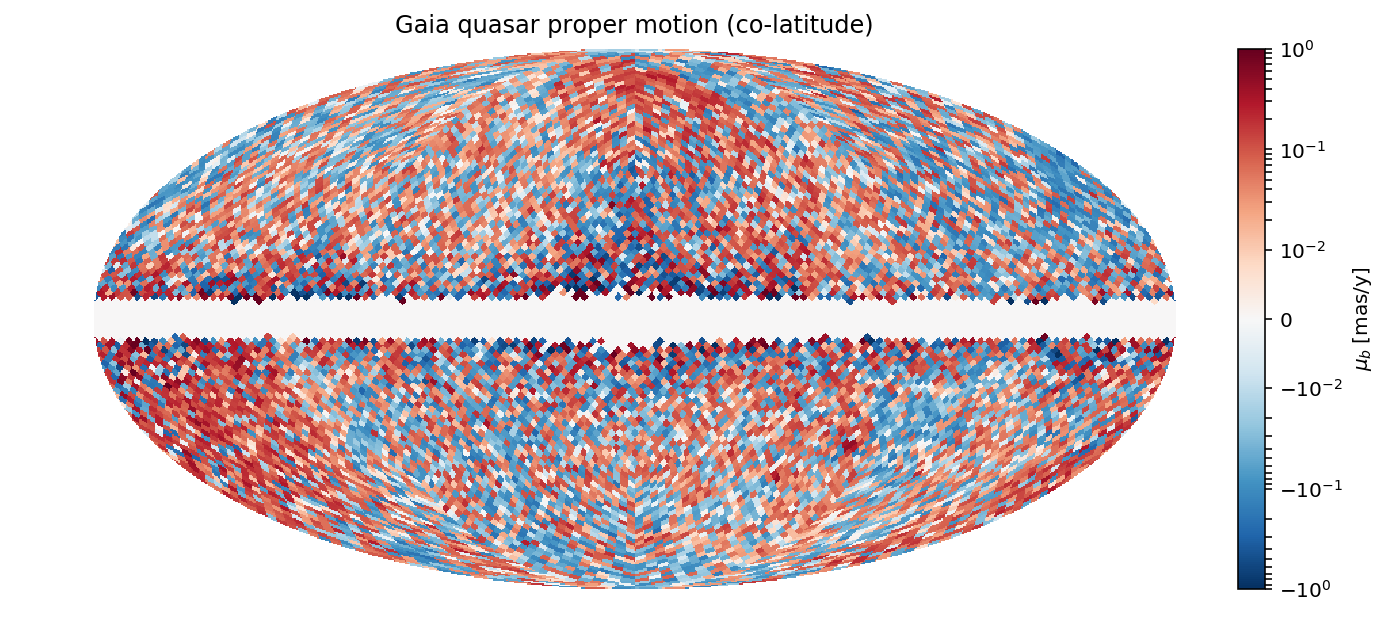

In [96]:
max=1
hp.mollview(pm_b_map, title="Gaia quasar proper motion (co-latitude)", min=-max, max=max, cmap='RdBu_r',
            norm=colors.SymLogNorm(linthresh=0.01, linscale=1, vmin=-max, vmax=max),cbar=None)
fig = plt.gcf();ax = plt.gca();
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\mu_b \; \mathrm{[mas/y]}$')

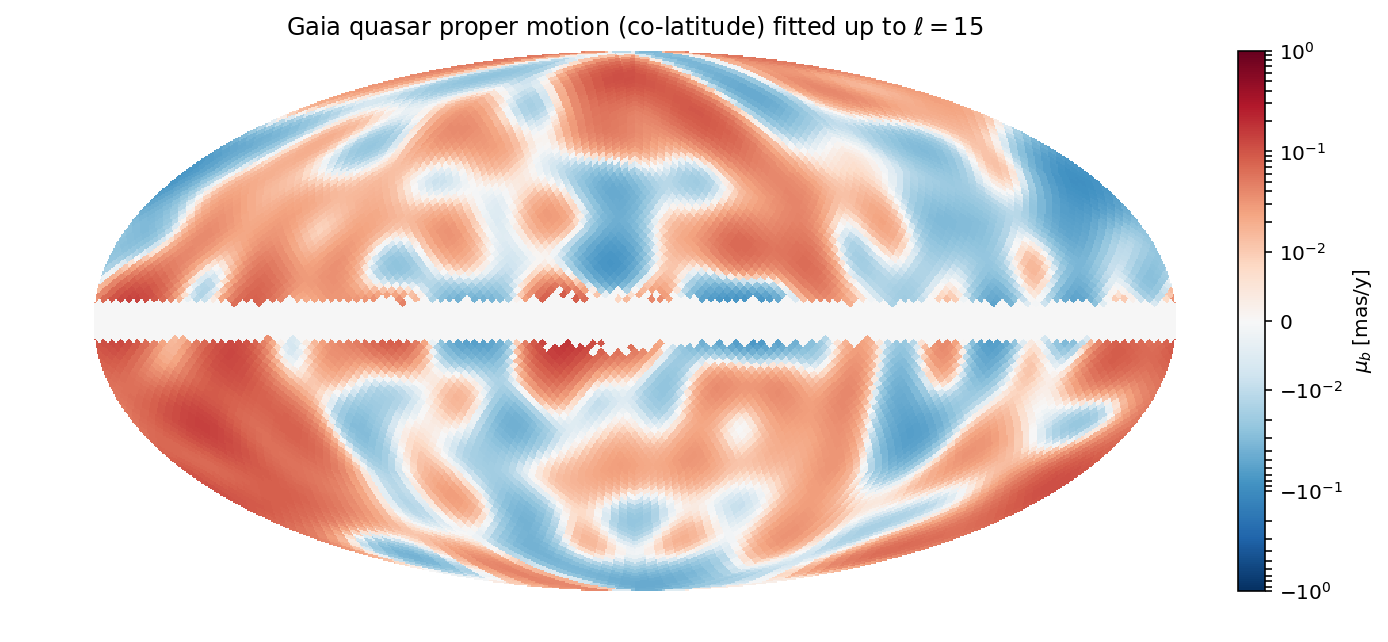

In [97]:
max=1
hp.mollview(pm_fit_map[:,0], title="Gaia quasar proper motion (co-latitude) fitted up to $\ell = 15$", min=-max, max=max, cmap='RdBu_r',
            norm=colors.SymLogNorm(linthresh=0.01, linscale=1, vmin=-max, vmax=max),cbar=None)
fig = plt.gcf(); ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\mu_b \; \mathrm{[mas/y]}$')

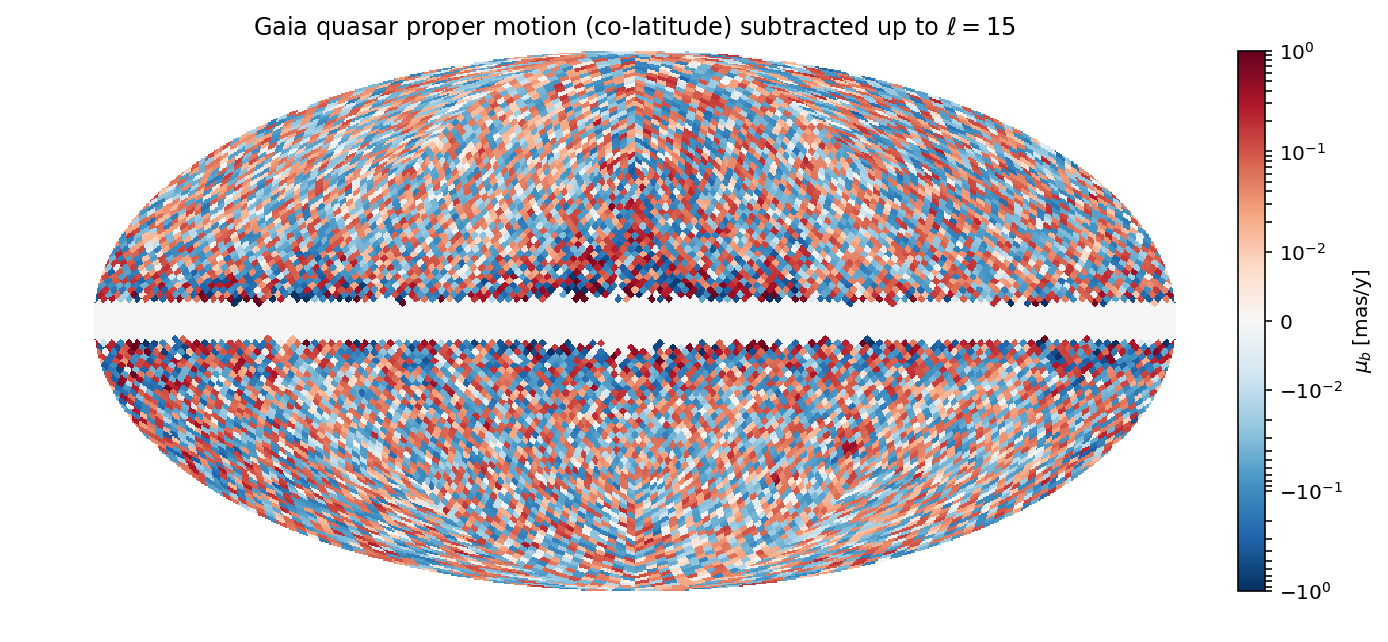

In [98]:
max=1
hp.mollview(pm_b_map_sub, title="Gaia quasar proper motion (co-latitude) subtracted up to $\ell = 15$", min=-max, max=max, cmap='RdBu_r',
            norm=colors.SymLogNorm(linthresh=0.01, linscale=1, vmin=-max, vmax=max),cbar=None)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\mu_b \; \mathrm{[mas/y]}$')

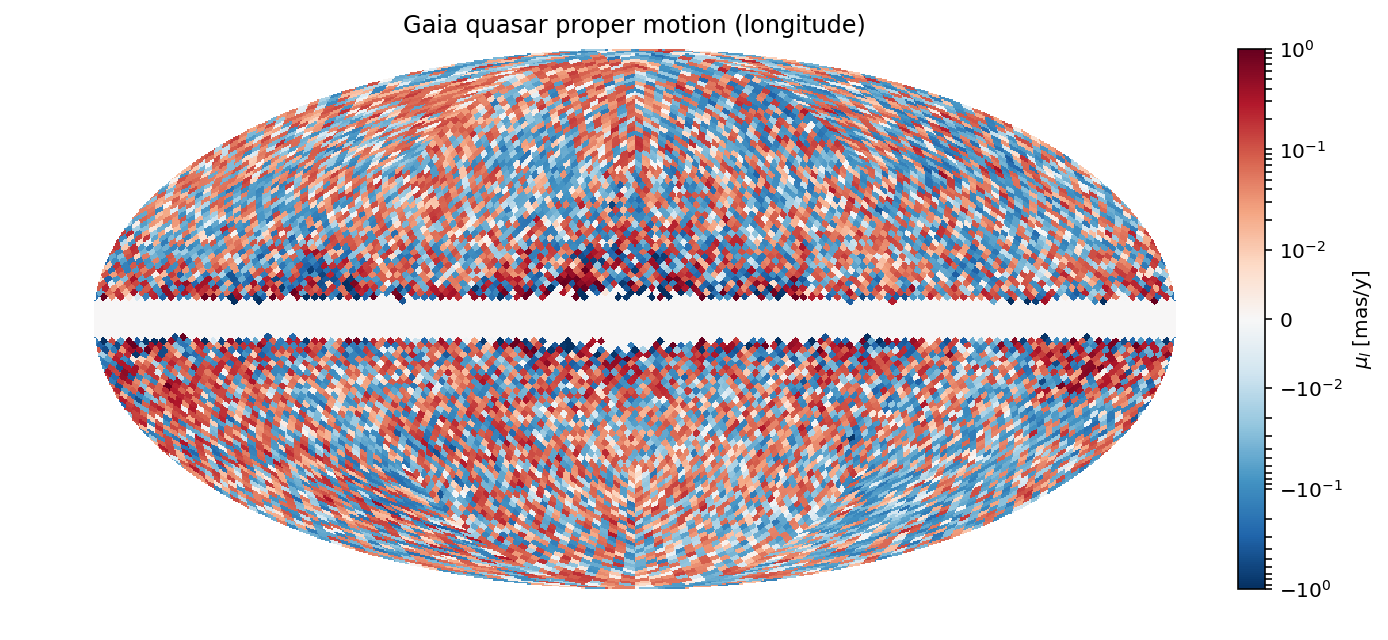

In [99]:
max=1
hp.mollview(pm_l_map, title="Gaia quasar proper motion (longitude)", min=-max, max=max, cmap='RdBu_r',
            norm=colors.SymLogNorm(linthresh=0.01, linscale=1, vmin=-max, vmax=max),cbar=None)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\mu_l \; \mathrm{[mas/y]}$')

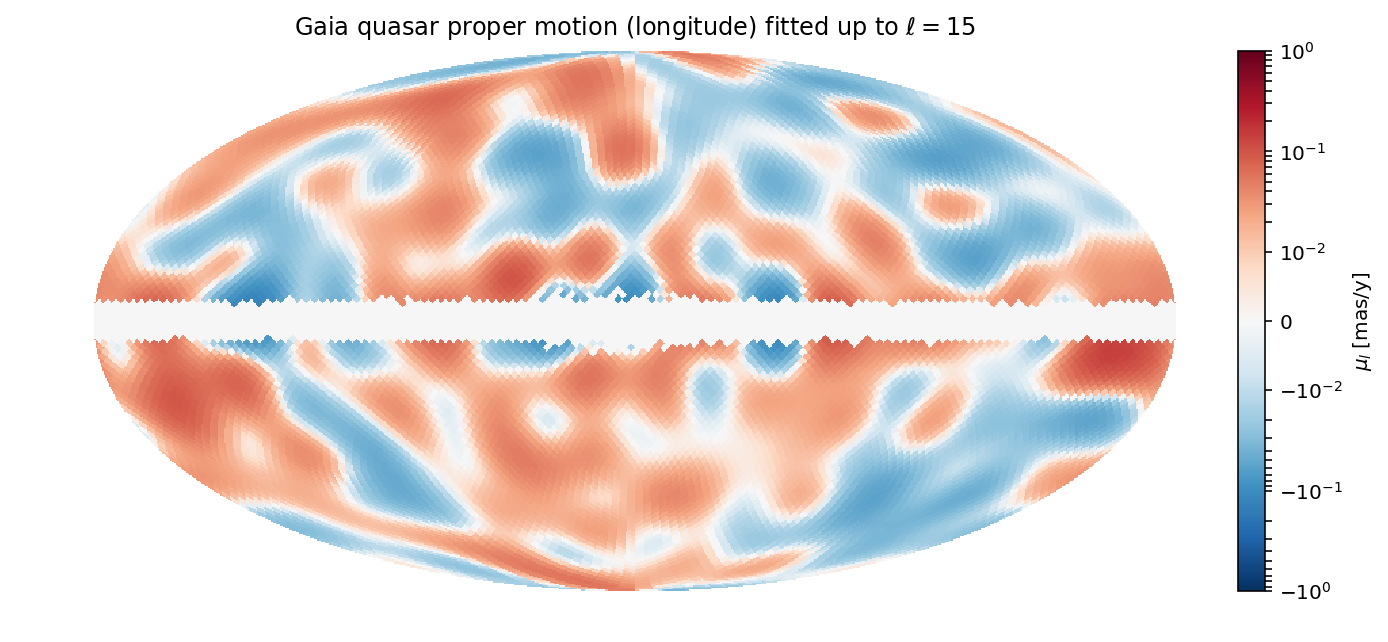

In [100]:
max=1
hp.mollview(pm_fit_map[:,1], title="Gaia quasar proper motion (longitude) fitted up to $\ell = 15$", min=-max, max=max, cmap='RdBu_r',
            norm=colors.SymLogNorm(linthresh=0.01, linscale=1, vmin=-max, vmax=max),cbar=None)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\mu_l \; \mathrm{[mas/y]}$')

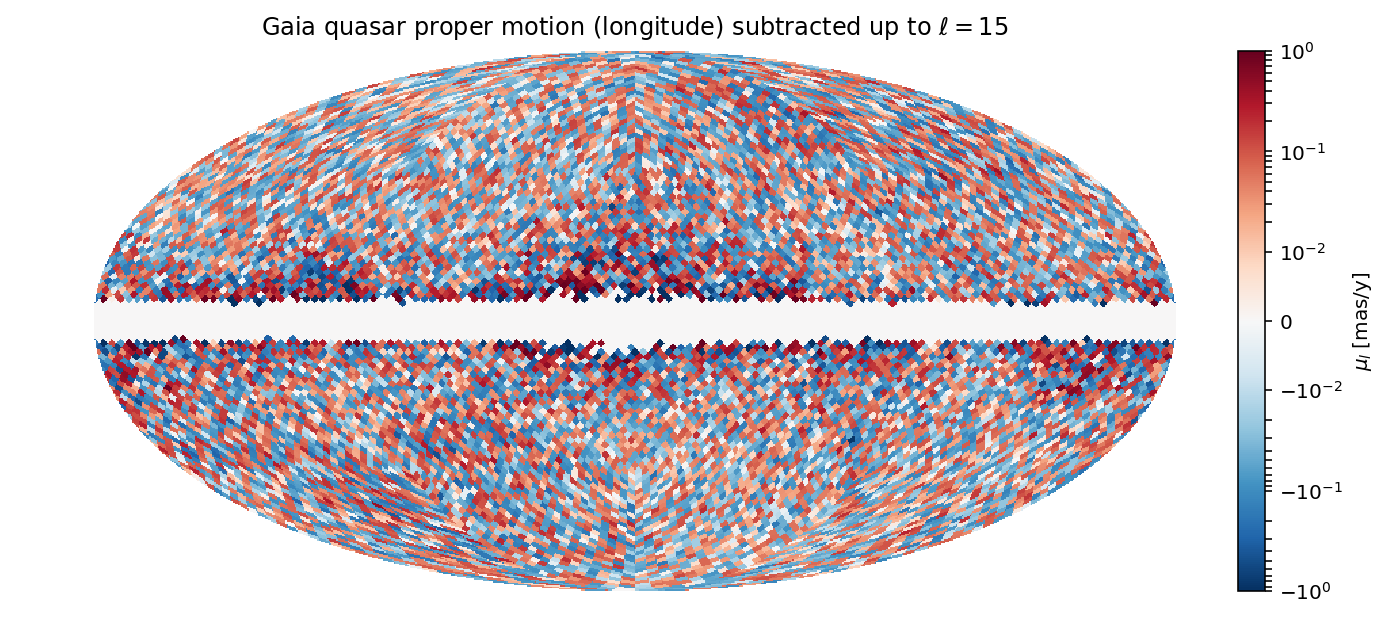

In [101]:
max=1
hp.mollview(pm_l_map_sub, title="Gaia quasar proper motion (longitude) subtracted up to $\ell = 15$", min=-max, max=max, cmap='RdBu_r',
            norm=colors.SymLogNorm(linthresh=0.01, linscale=1, vmin=-max, vmax=max),cbar=None)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\mu_l \; \mathrm{[mas/y]}$')

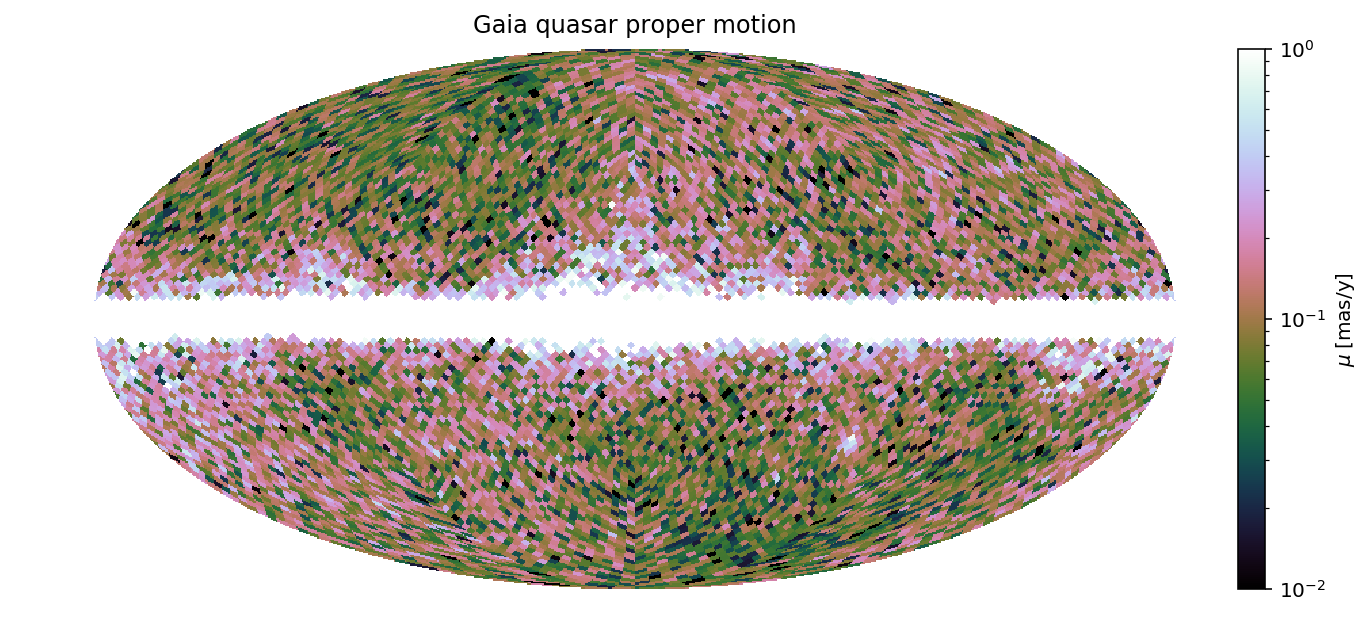

In [102]:
min = 10**(-2); max = 1
hp.mollview(np.sqrt(pm_b_map**2 + pm_l_map**2), title="Gaia quasar proper motion", min=min, max=max, cmap='cubehelix',
            norm=colors.LogNorm(vmin=min, vmax=max),cbar=None)
fig = plt.gcf(); ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\mu \; \mathrm{[mas/y]}$')

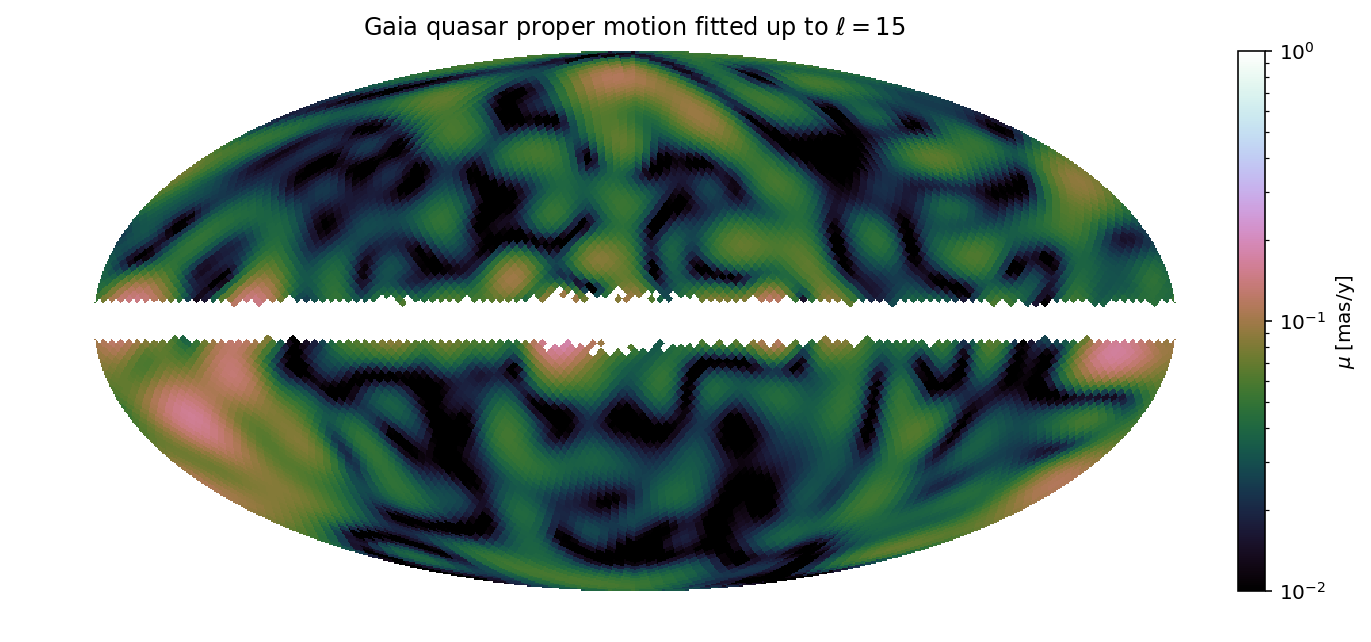

In [103]:
min = 10**(-2); max = 1
hp.mollview(np.sqrt((pm_fit_map[:,0])**2 + (pm_fit_map[:,1])**2), title="Gaia quasar proper motion fitted up to $\ell = 15$", min=min, max=max, cmap='cubehelix',
            norm=colors.LogNorm(vmin=min, vmax=max),cbar=None)
fig = plt.gcf(); ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\mu \; \mathrm{[mas/y]}$')

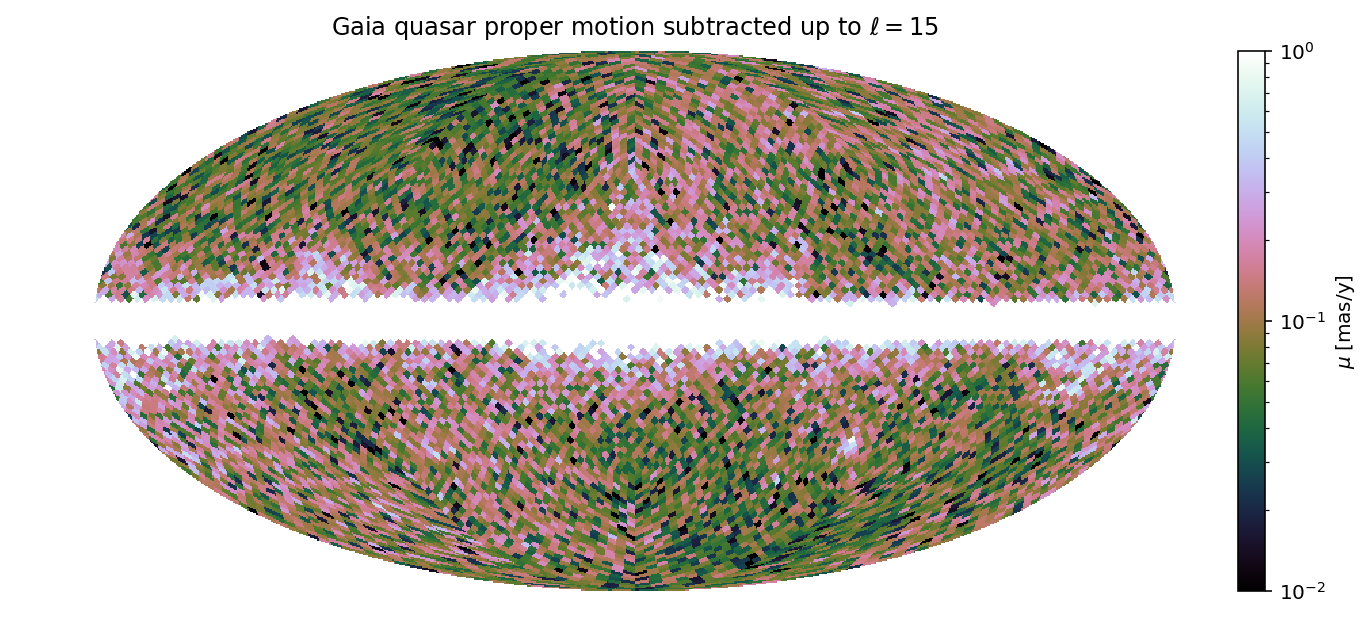

In [104]:
min = 10**(-2); max = 1
hp.mollview(np.sqrt((pm_b_map_sub)**2 + (pm_l_map_sub)**2), title="Gaia quasar proper motion subtracted up to $\ell = 15$", min=min, max=max, cmap='cubehelix',
            norm=colors.LogNorm(vmin=min, vmax=max),cbar=None)
fig = plt.gcf(); ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\mu \; \mathrm{[mas/y]}$')

### 3.1.3 Subtraction diagnostics

In [1384]:
hist_bins = np.logspace(-3.0,0.5,50);

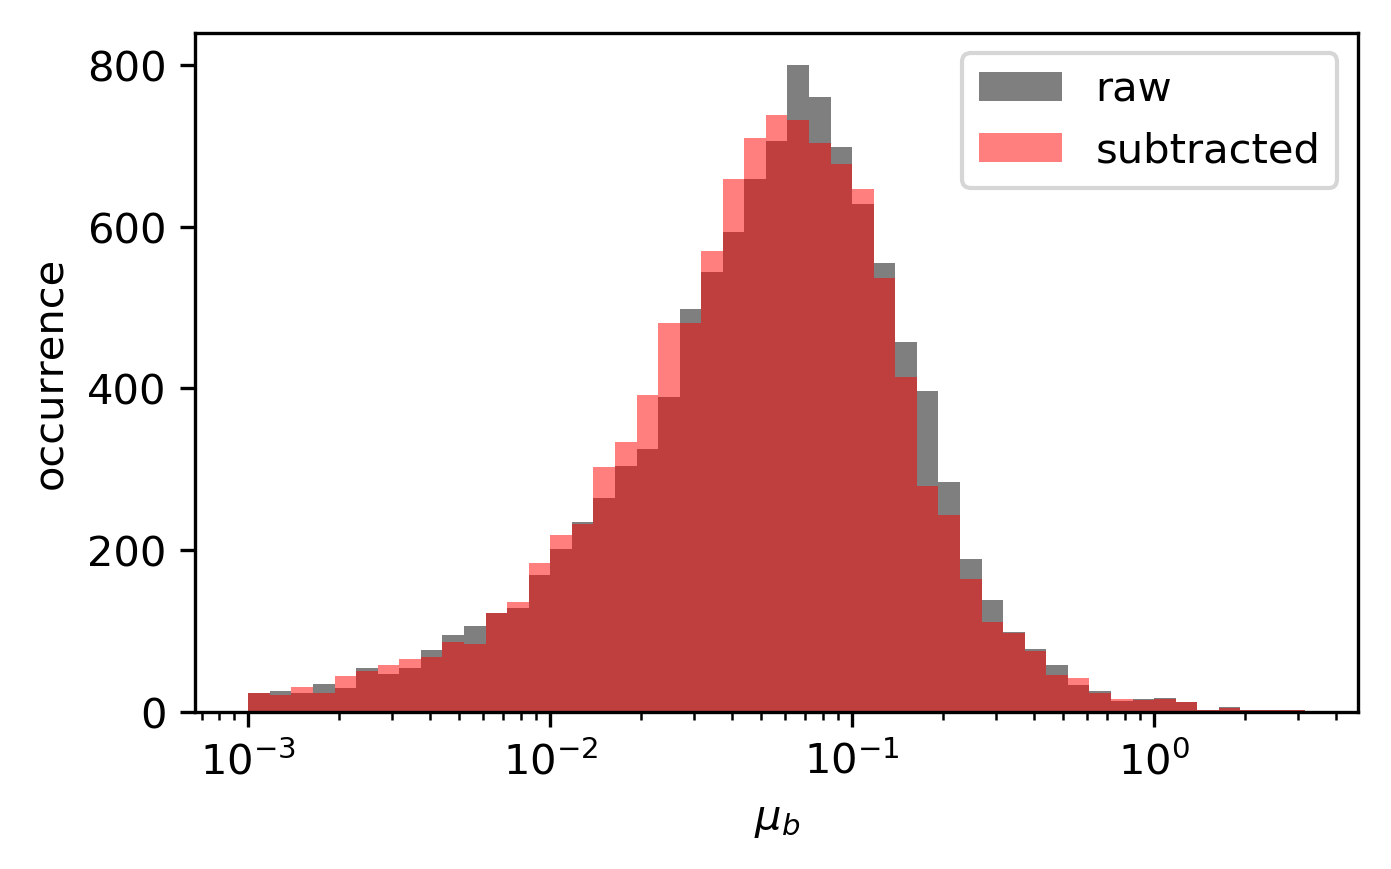

In [1455]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=150)
ax.hist(np.abs(pm_b_map),bins=hist_bins,alpha=0.5,color='black',label='raw');
ax.hist(np.abs(pm_b_map_sub),bins=hist_bins,alpha=0.5,color='red',label='subtracted')
ax.set_xscale('log'); #ax.set_yscale('log')
ax.set_xlabel(r'$\mu_b$');
ax.set_ylabel('occurrence');
ax.legend();

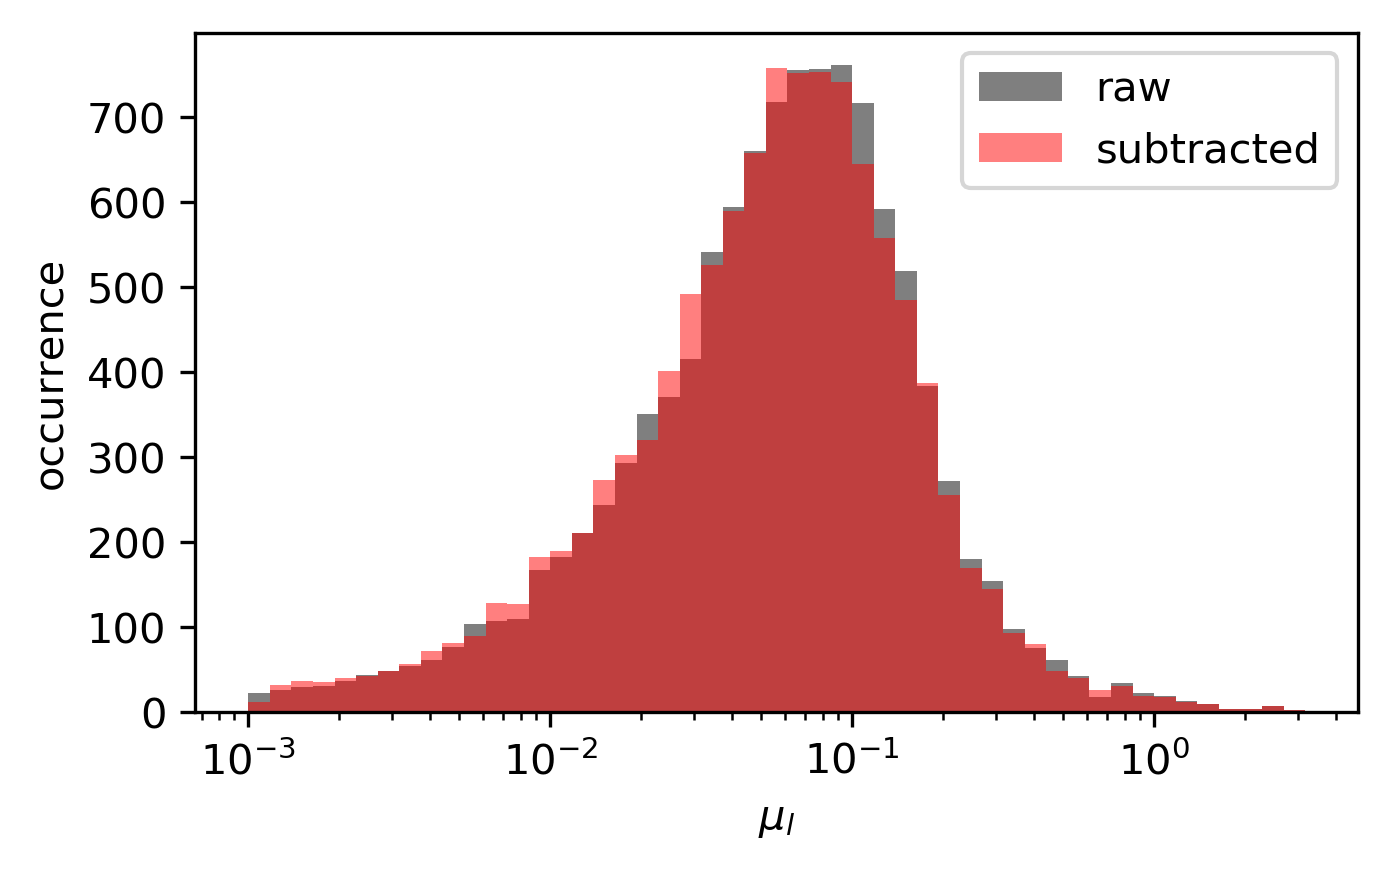

In [1456]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=150)
ax.hist(np.abs(pm_l_map),bins=hist_bins,alpha=0.5,color='black',label='raw');
ax.hist(np.abs(pm_l_map_sub),bins=hist_bins,alpha=0.5,color='red',label='subtracted')
ax.set_xscale('log'); #ax.set_yscale('log')
ax.set_xlabel(r'$\mu_l$');
ax.set_ylabel('occurrence');
ax.legend();

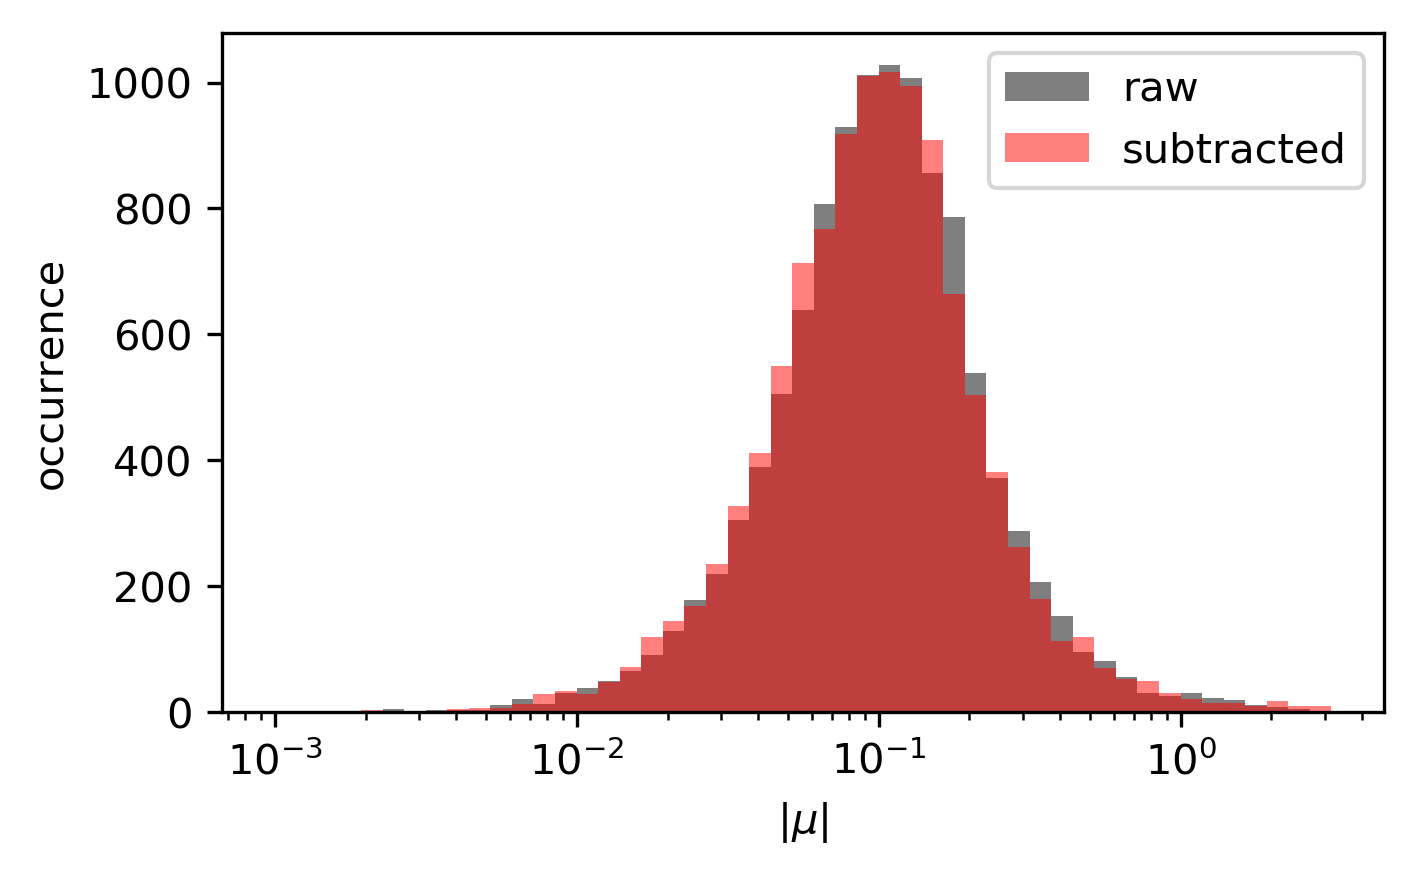

In [1457]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=150)
ax.hist(pm_mag_map,bins=hist_bins,alpha=0.5,color='black',label='raw');
ax.hist(np.sqrt( (pm_b_map-pm_subtract_map[:,0])**2 + (pm_l_map-pm_subtract_map[:,1])**2 ),bins=hist_bins,alpha=0.5,color='red',label='subtracted')
ax.set_xscale('log'); #ax.set_yscale('log')
ax.set_xlabel(r'$|\mu|$');
ax.set_ylabel('occurrence');
ax.legend();

## 3.2 Real-space subtraction

In [537]:
neighbors1 = hp.get_all_neighbours(nside,1)
print(len(neighbors1), neighbors1)
neighbors2=[]
for i_neighbor_1 in neighbors1:
    neighbors2.append(hp.get_all_neighbours(nside,i_neighbor_1))
neighbors2 = np.unique(np.ndarray.flatten(np.asarray(neighbors2)))
print(len(neighbors2), neighbors2)
neighbors = []
for i_neighbor_2 in neighbors2:
    neighbors.append(hp.get_all_neighbours(nside,i_neighbor_2))
neighbors = np.unique(np.ndarray.flatten(np.asarray(neighbors)))
print(len(neighbors), neighbors)

8 [ 6  5  0  3  2  8  7 16]
25 [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 22 26 29 30 33 47]
49 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25 26 27 28 29 30 31 32 33 34 37 38 42 43 46 47 48 51 52 57 63 68 69 74 94]


In [538]:
pm_mag_map_subtracted = np.zeros(npix)
pm_b_map_subtracted = np.zeros(npix)
pm_l_map_subtracted = np.zeros(npix)
for ipix in range(npix):
    neighbors1 = hp.get_all_neighbours(nside,ipix) #find 8 nearest neighbors
    neighbors=[]
    for i_neighbor_1 in neighbors1:
        neighbors.append(hp.get_all_neighbours(nside,i_neighbor_1))
    neighbors = np.unique(np.ndarray.flatten(np.asarray(neighbors))) #find 25 nearest neighbors
    tmp_b = 0; tmp_l = 0; tmp_N = 0;
    for i_neighbor in neighbors:
        tmp_b += pm_b_map[i_neighbor] / pm_N_map[i_neighbor]
        tmp_l += pm_l_map[i_neighbor] / pm_N_map[i_neighbor]
        tmp_N += 1/pm_N_map[i_neighbor]
    tmp_b = tmp_b / tmp_N
    tmp_l = tmp_l / tmp_N
    
    pm_b_map_subtracted[ipix] = pm_b_map[ipix] - tmp_b
    pm_l_map_subtracted[ipix] = pm_l_map[ipix] - tmp_l
    pm_mag_map_subtracted[ipix] = np.sqrt(pm_b_map_subtracted[ipix]**2 + pm_l_map_subtracted[ipix]**2)

In [539]:
hist_bins = np.logspace(-3.0,0.5,50);

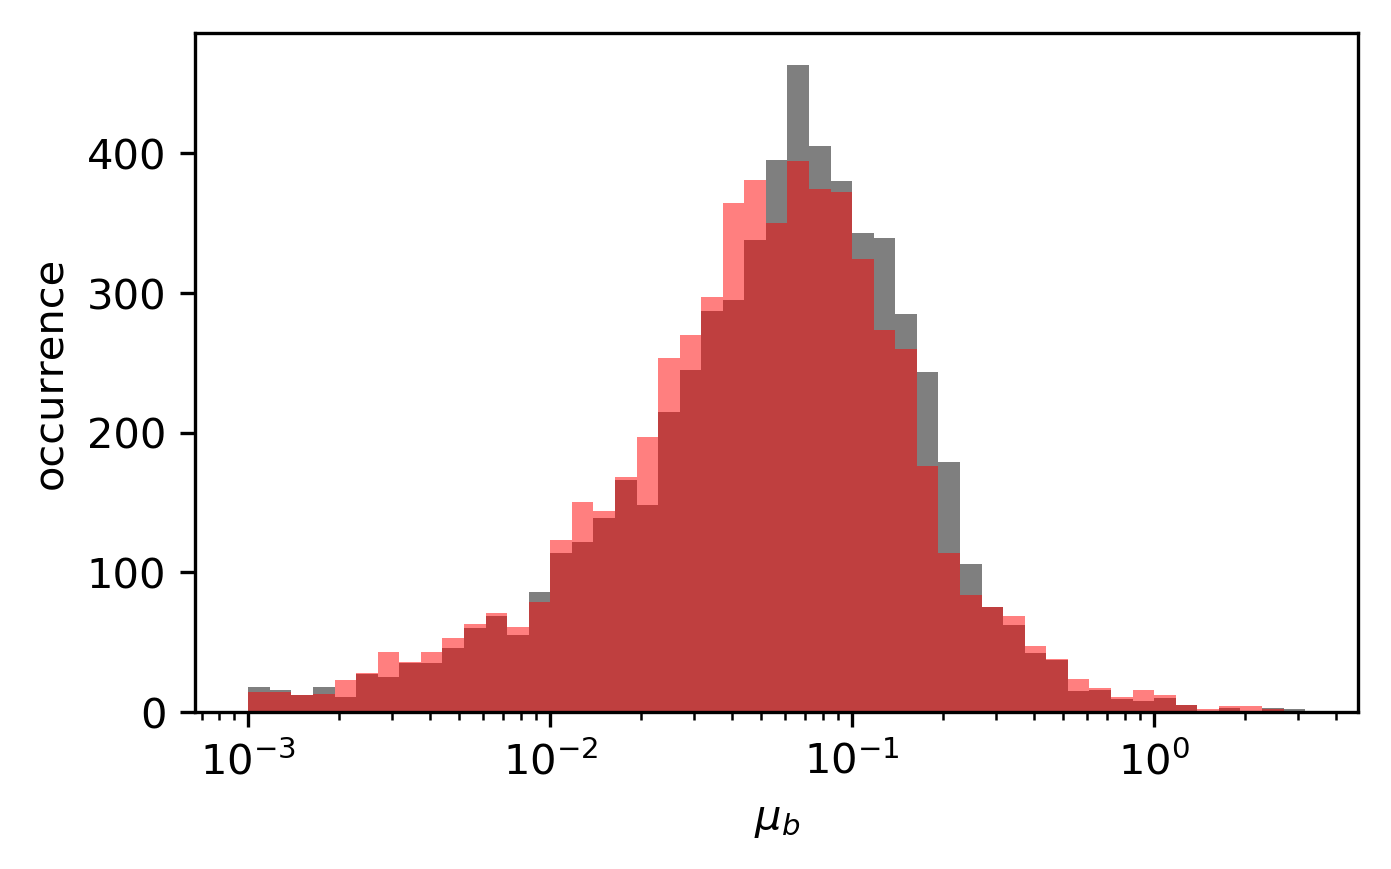

In [540]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=150)
ax.hist(pm_b_map,bins=hist_bins,alpha=0.5,color='black',label='raw');
ax.hist(pm_b_map_subtracted,bins=hist_bins,alpha=0.5,color='red',label='subtracted')
ax.set_xscale('log'); #ax.set_yscale('log')
ax.set_xlabel(r'$\mu_b$');
ax.set_ylabel('occurrence');

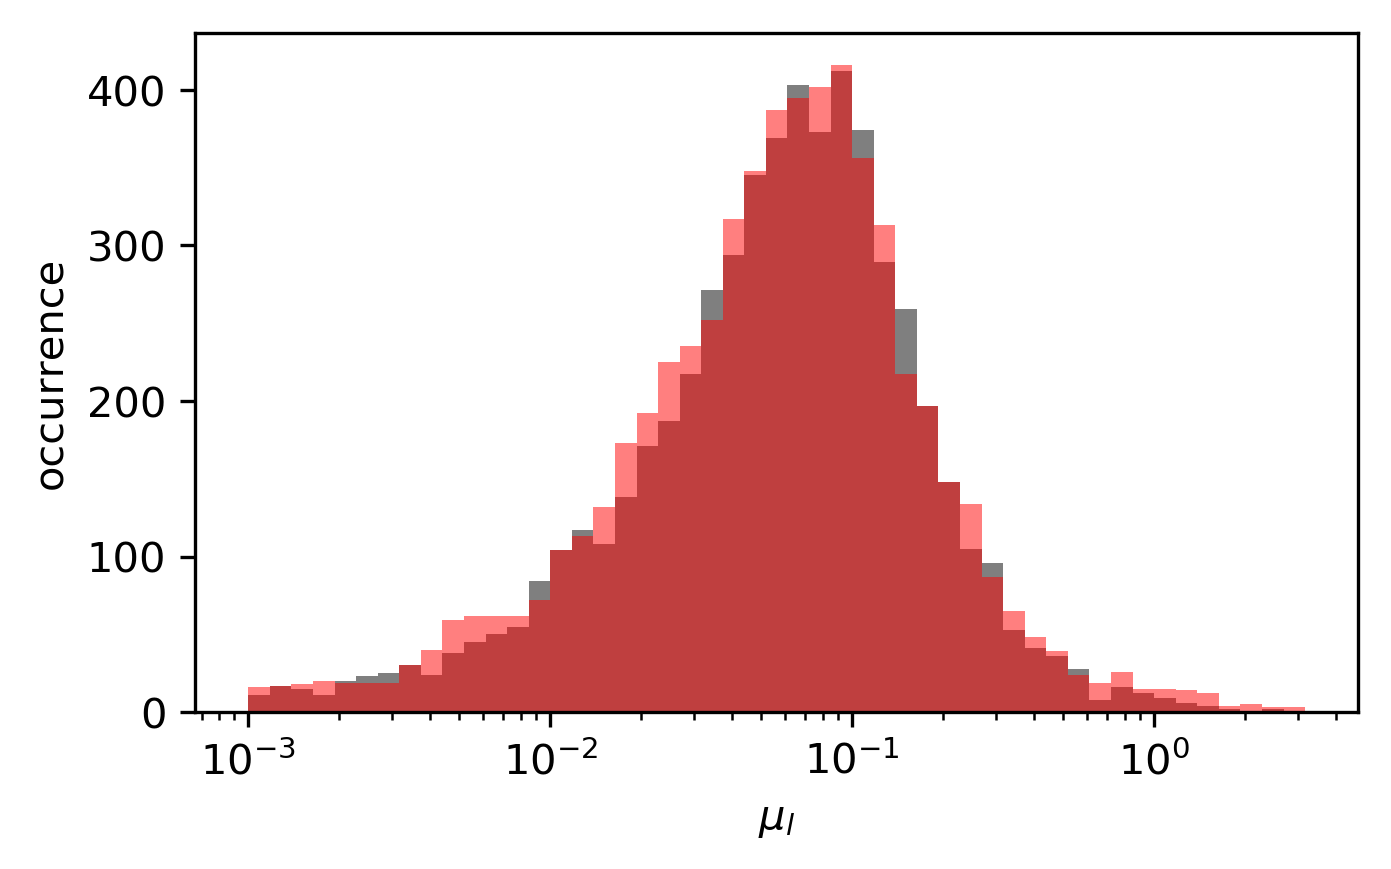

In [541]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=150)
ax.hist(pm_l_map,bins=hist_bins,alpha=0.5,color='black',label='raw');
ax.hist(pm_l_map_subtracted,bins=hist_bins,alpha=0.5,color='red',label='subtracted')
ax.set_xscale('log'); #ax.set_yscale('log')
ax.set_xlabel(r'$\mu_l$');
ax.set_ylabel('occurrence');

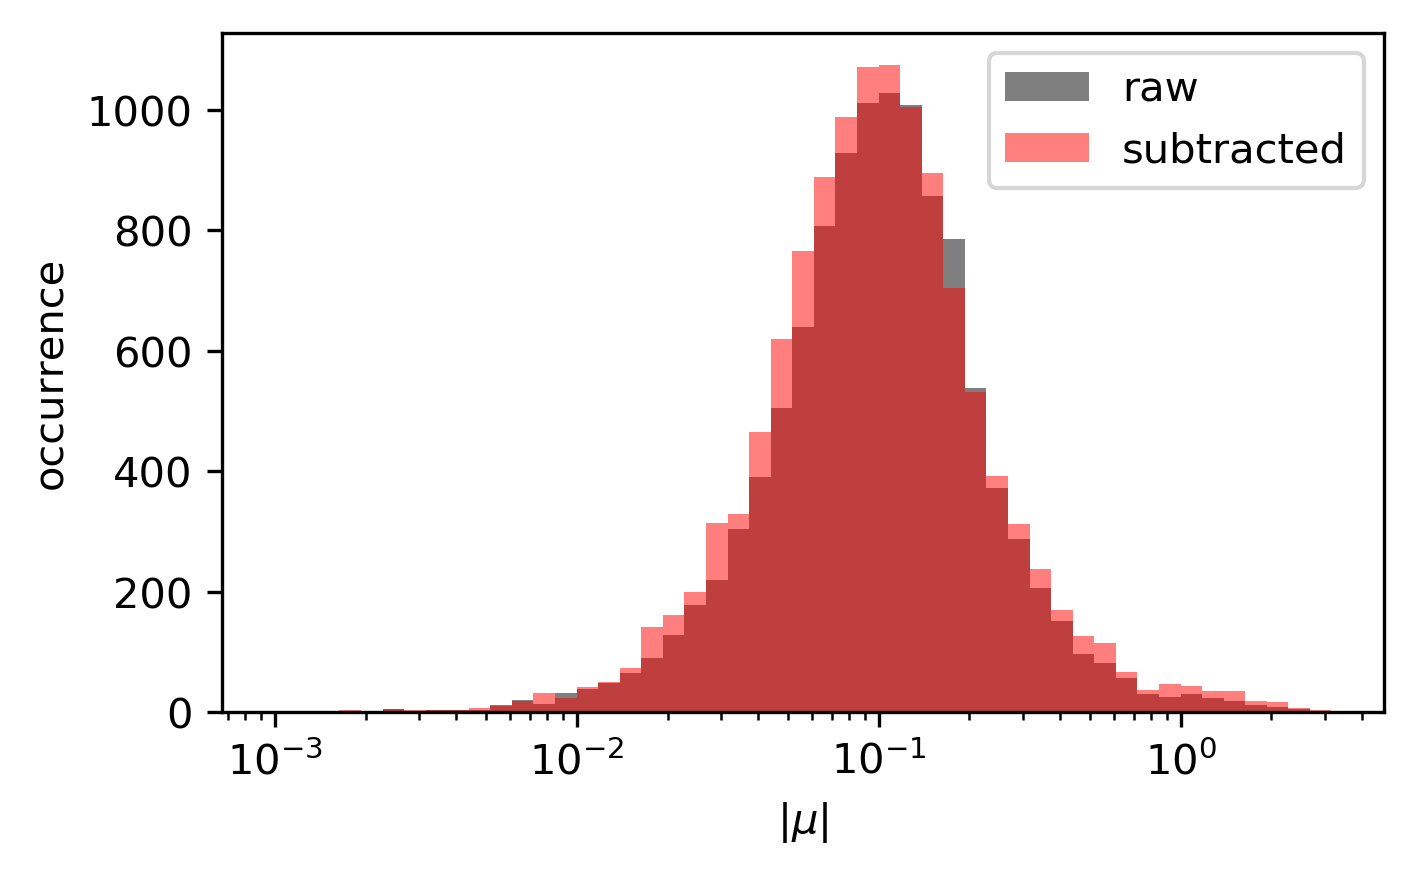

In [542]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=150)
ax.hist(pm_mag_map,bins=hist_bins,alpha=0.5,color='black',label='raw');
ax.hist(pm_mag_map_subtracted,bins=hist_bins,alpha=0.5,color='red',label='subtracted')
ax.set_xscale('log'); #ax.set_yscale('log')
ax.set_xlabel(r'$|\mu|$');
ax.set_ylabel('occurrence');
ax.legend();

# 4 Computation

In [168]:
weights_map = pm_N_map**(-1)

## 4.1 Fisher

### 4.1.1 nside = 32

compute psitilde

In [169]:
mat_Psitilde_pre_32_0 = sp.sparse.load_npz('../lists/mat_Psitilde_pre_32_0.npz')

In [170]:
mat_Psitilde_pre_32_1 = sp.sparse.load_npz('../lists/mat_Psitilde_pre_32_1.npz')

compute ptilde

In [171]:
mat_Ptilde_pre_32 = fn_mat_Ptilde_from_Psitilde([mat_Psitilde_pre_32_0,mat_Psitilde_pre_32_1])

In [172]:
sp.sparse.save_npz('../lists/mat_Ptilde_pre_32.npz',sp.sparse.csr_matrix(mat_Ptilde_pre_32))

In [ ]:
mat_Ptilde_pre_32 = sp.sparse.load_npz('../lists/mat_Ptilde_pre_32.npz')

compute Fisher

In [107]:
mat_Fisher_pre_32 = fn_mat_Fisher_from_Ptilde(mat_Ptilde_pre_32)

In [85]:
mat_Fisher_pre_32

<8836x8836 sparse matrix of type '<class 'numpy.complex128'>'
	with 70346385 stored elements in Compressed Sparse Row format>

In [45]:
np.sqrt(8836)-1

93.0

In [86]:
sp.sparse.save_npz('../lists/mat_Fisher_pre_32.npz',mat_Fisher_pre_32)

In [173]:
mat_Fisher_pre_32 = sp.sparse.load_npz('../lists/mat_Fisher_pre_32.npz')

spectrally binned Fisher

In [174]:
mat_W_inv_lm_B = fn_mat_W_inv_lm_B(np.int(np.sqrt(mat_Fisher_pre_32.shape[0])-1))

In [175]:
mat_Fisher_pre_32_B = np.transpose(mat_W_inv_lm_B) @ (mat_Fisher_pre_32.dot(mat_W_inv_lm_B))

spectrally binned inverse Fisher

In [176]:
mat_Fisher_pre_32_B_inv = np.linalg.inv(mat_Fisher_pre_32_B)

plots

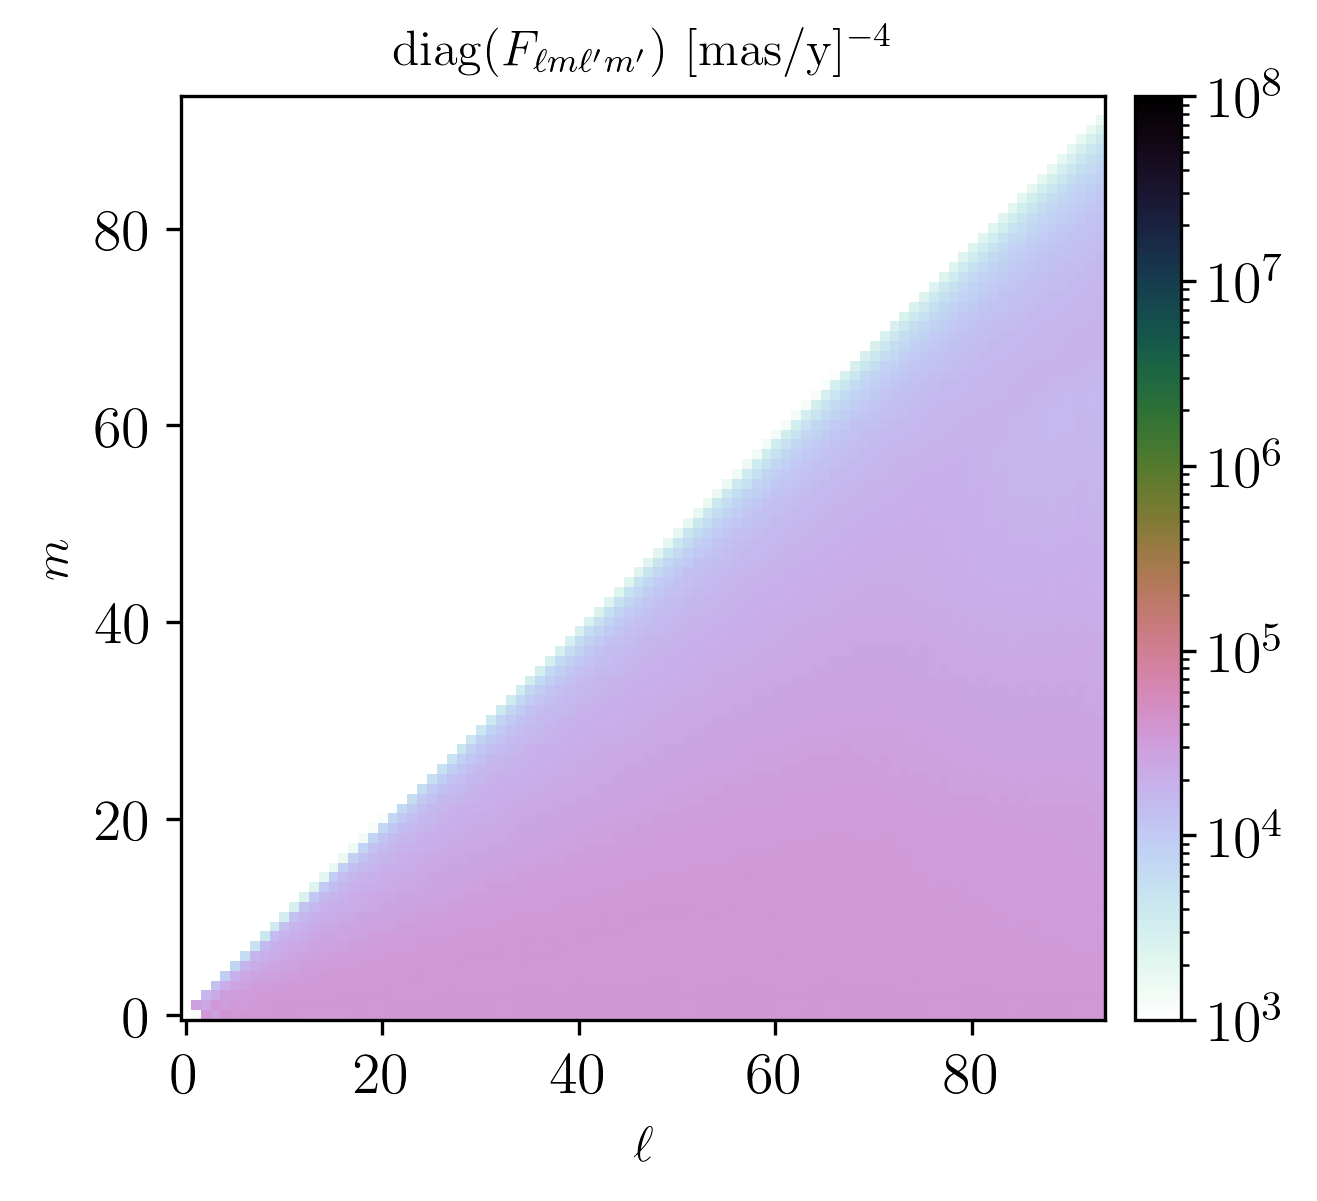

In [177]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im0 = ax.imshow(abs(fn_arr_pow_spec(np.real(mat_Fisher_pre_32.diagonal()))),  
                origin='lower', vmin=10**(3), vmax=10**8, cmap='cubehelix_r',
                norm=colors.LogNorm(vmin=10**(3), vmax=10**8));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$\mathrm{diag}(F_{\ell m \ell^{\prime} m^\prime})$ $[\mathrm{mas/y}]^{-4}$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im0,cax=cax);
fig.savefig('diag_fisher.pdf')

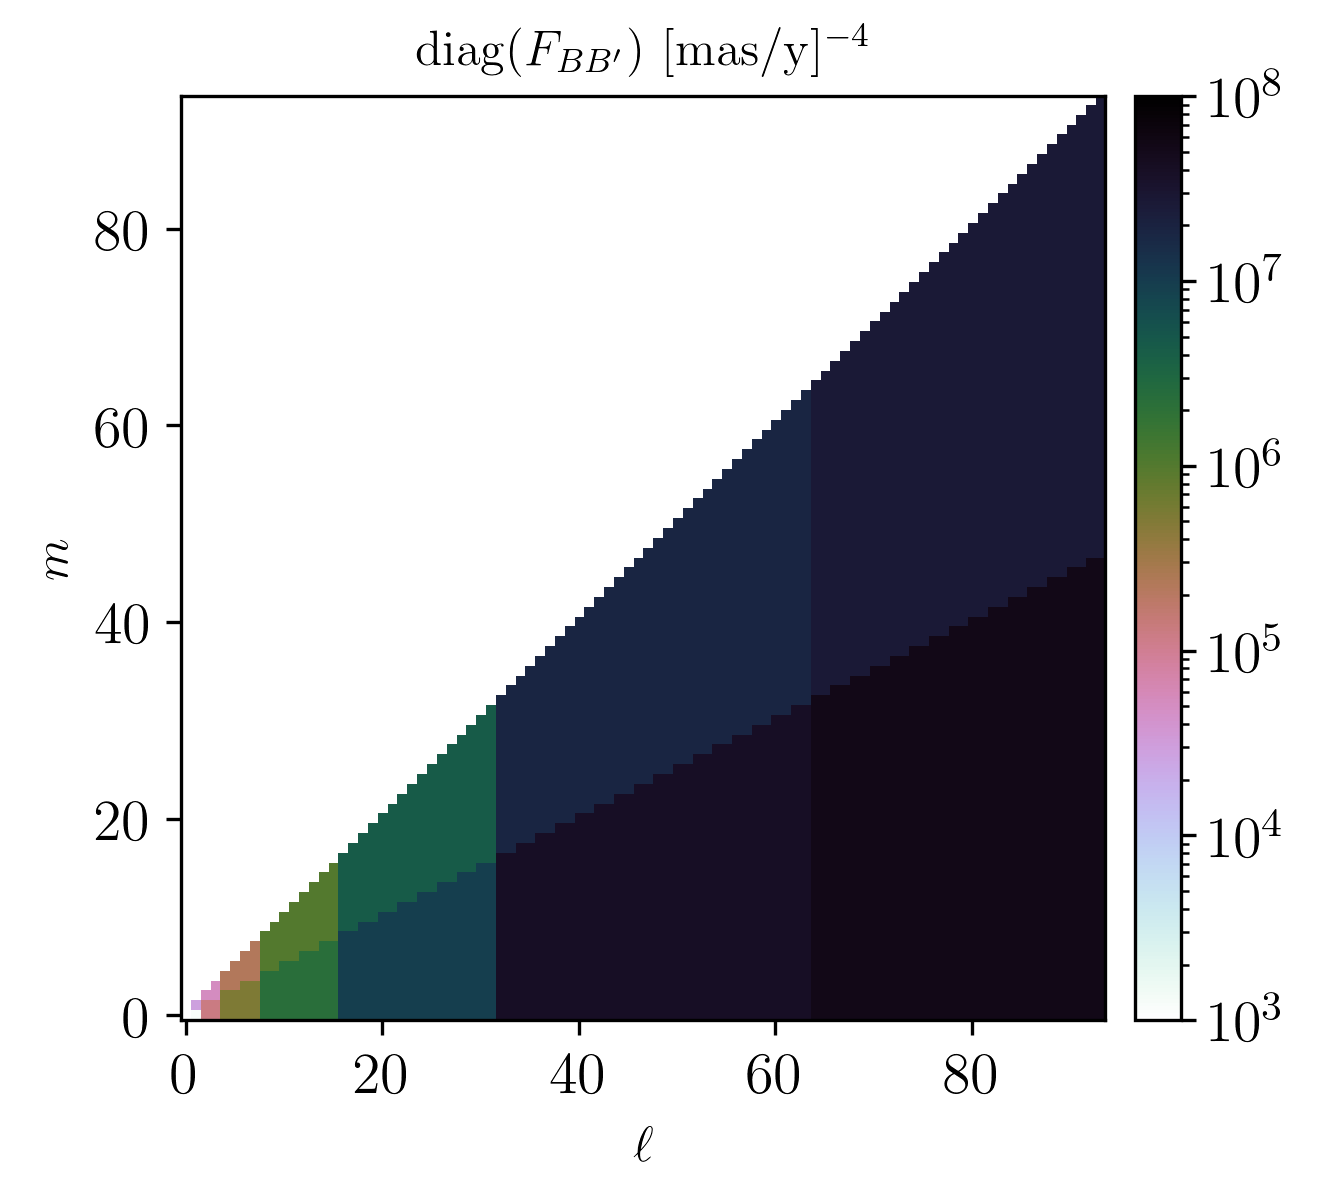

In [178]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im0 = ax.imshow(abs(fn_arr_pow_spec_B(np.real(mat_Fisher_pre_32_B.diagonal()),np.int(np.sqrt(mat_Fisher_pre_32.shape[0])-1))),  
                origin='lower', vmin=10**(3), vmax=10**8, cmap='cubehelix_r',
                norm=colors.LogNorm(vmin=10**(3), vmax=10**8));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$\mathrm{diag}(F_{B B^\prime})$ $[\mathrm{mas/y}]^{-4}$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im0,cax=cax);
fig.savefig('diag_fisher_B.pdf')

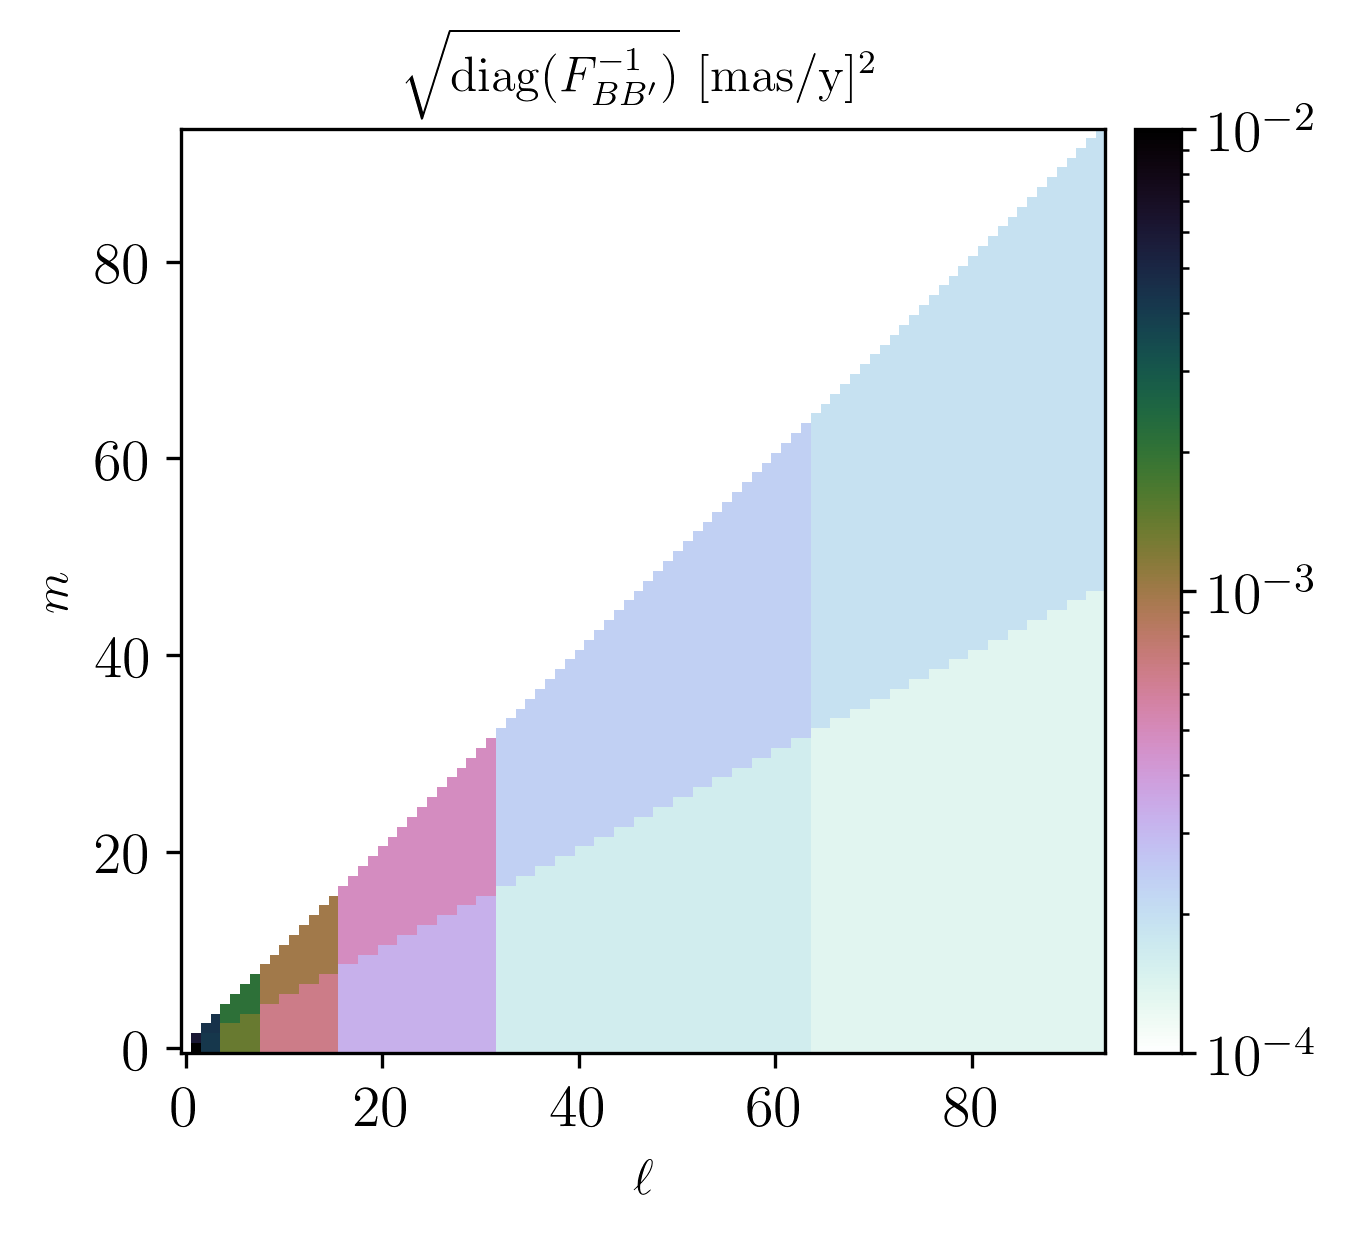

In [179]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im0 = ax.imshow(abs(fn_arr_pow_spec_B(np.sqrt(np.real(mat_Fisher_pre_32_B_inv.diagonal())),np.int(np.sqrt(mat_Fisher_pre_32.shape[0])-1))),  
                origin='lower', vmin=10**(-4), vmax=10**(-2), cmap='cubehelix_r',
                norm=colors.LogNorm(vmin=10**(-5), vmax=10**(-2)));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$\sqrt{\mathrm{diag}(F^{-1}_{B B^\prime})}$ $[\mathrm{mas/y}]^{2}$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im0,cax=cax);
fig.savefig('diag_fisher_B_inv.pdf')

## 4.2 Power spectrum

### 4.2.1 nside = 32

In [180]:
lmax_pre_32 = np.int(np.sqrt(mat_Fisher_pre_32.shape[0])-1)
lmax_pre_32

93

#### 4.2.1 Raw data without weight map

In [181]:
data_map_b, data_map_l = pm_b_map, pm_l_map
mat_num1_sig = fn_pow_spec_trim(fn_mat_num1_sig(data_map_b, data_map_l,1))
mat_num2_sig = fn_pow_spec_trim(fn_mat_num2_sig(data_map_b, data_map_l,1))

mat_pow1_spec_raw_unit = (1/2) * mat_num1_sig
mat_pow2_spec_raw_unit = (1/2) *  mat_num2_sig

mat_W_B_lm = fn_mat_W_B_lm(np.int(np.sqrt(mat_num1_sig.shape[0])-1))
mat_pow1_spec_raw_unit_B = mat_W_B_lm @ mat_pow1_spec_raw_unit
mat_pow2_spec_raw_unit_B = mat_W_B_lm @ mat_pow2_spec_raw_unit

In [182]:
vmin_unit, vmax_unit = 10**(-7), 2*10**(-3)
linthresh_unit = 10**(-6)

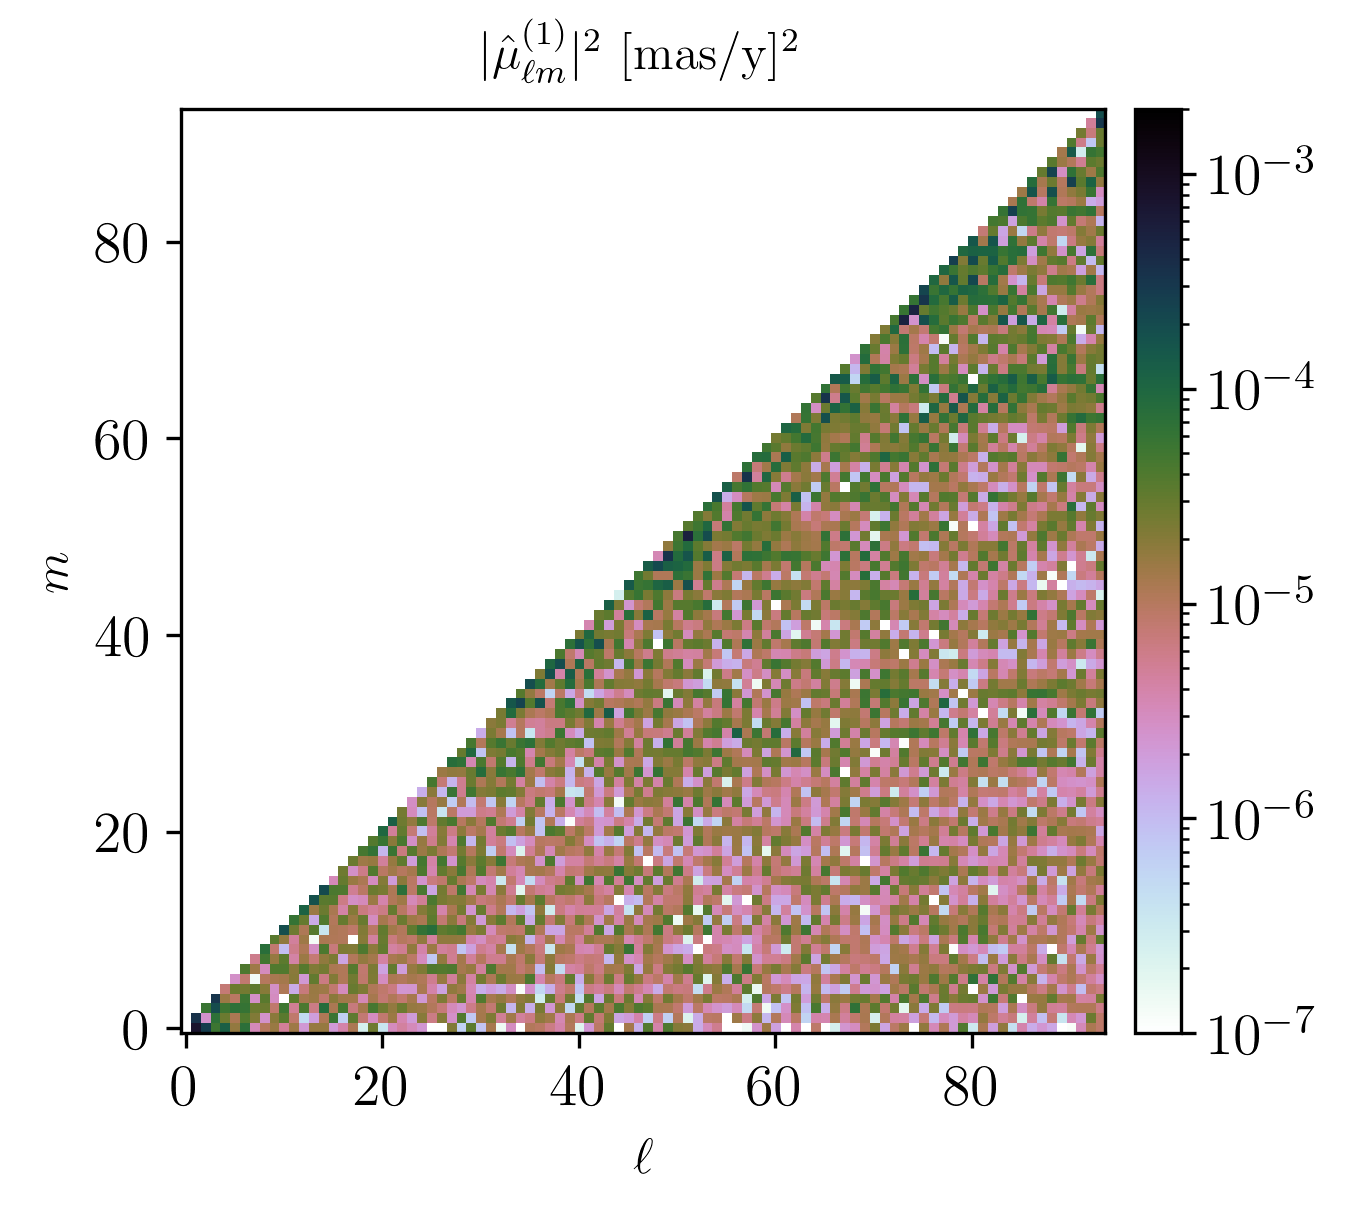

In [183]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im0 = ax.imshow(abs(fn_arr_pow_spec(mat_pow1_spec_raw_unit)),  origin='lower', vmin=vmin_unit, vmax=vmax_unit, cmap='cubehelix_r',
                   norm=colors.LogNorm(vmin=vmin_unit, vmax=vmax_unit));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(1)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im0,cax=cax);
fig.savefig('pow1_spec_raw_unit.pdf')

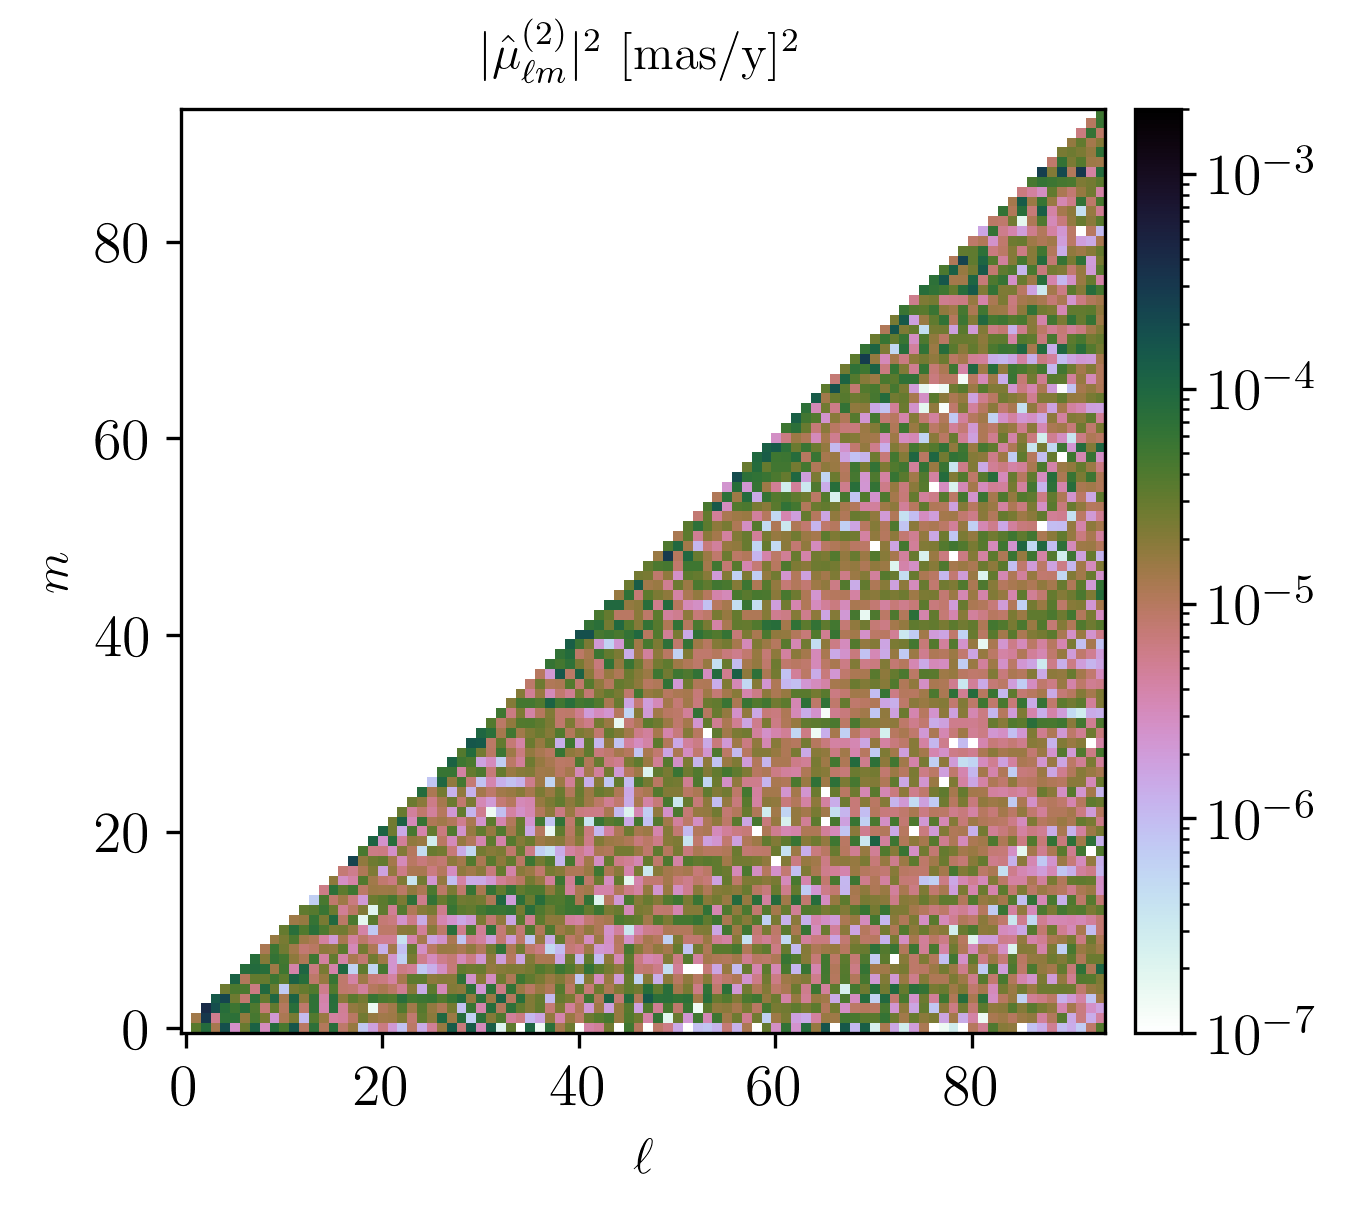

In [184]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im1 = ax.imshow(abs(fn_arr_pow_spec(mat_pow2_spec_raw_unit)),  origin='lower', vmin=vmin_unit, vmax=vmax_unit, cmap='cubehelix_r',
                   norm=colors.LogNorm(vmin=vmin_unit, vmax=vmax_unit));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(2)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1,cax=cax);
fig.savefig('pow2_spec_raw_unit.pdf');

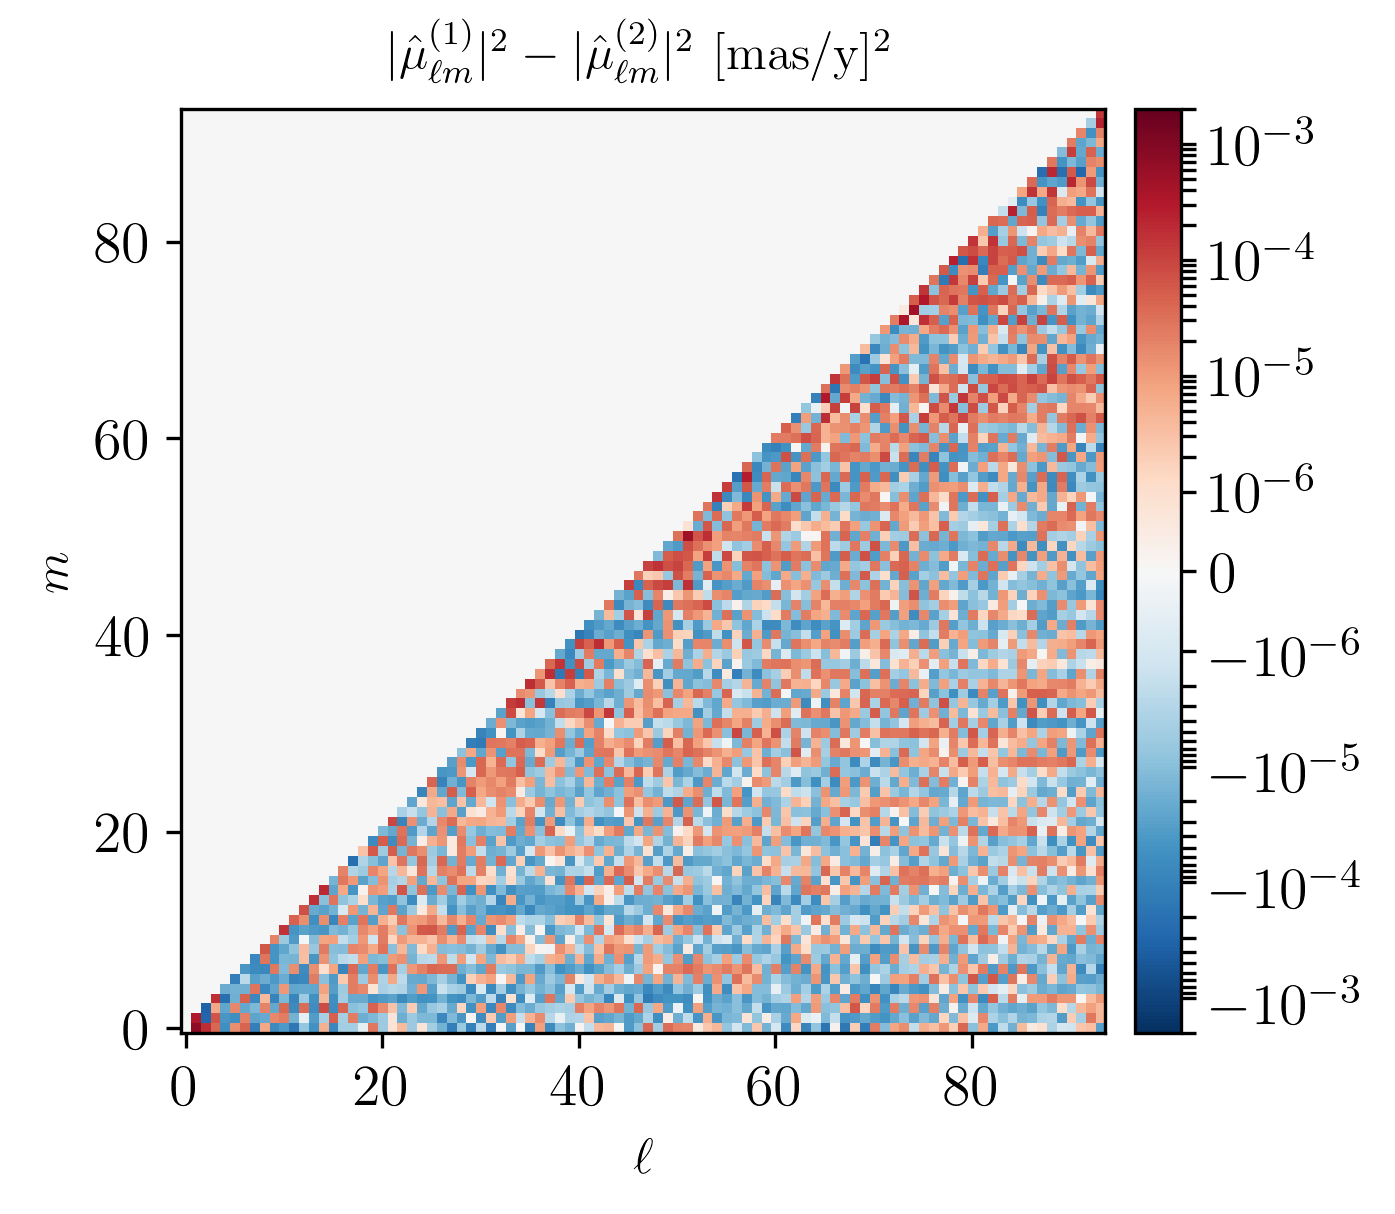

In [185]:
cmap = plt.cm.RdBu_r
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im1 = ax.imshow(fn_arr_pow_spec(mat_pow1_spec_raw_unit-mat_pow2_spec_raw_unit),  origin='lower', vmin=-vmax_unit, vmax=vmax_unit, cmap=cmap, 
                norm=colors.SymLogNorm(linthresh=linthresh_unit, linscale=1, vmin=-vmax_unit, vmax=vmax_unit))
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(1)}_{\ell m}|^2-|\hat{\mu}^{(2)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1,cax=cax);
fig.savefig('pow_diff_spec_raw_unit.pdf');

In [186]:
#vmin_unit_B = 10**(-6); vmax_unit_B = 10**(-3)
vmin_unit_B = vmin_unit; vmax_unit_B = vmax_unit

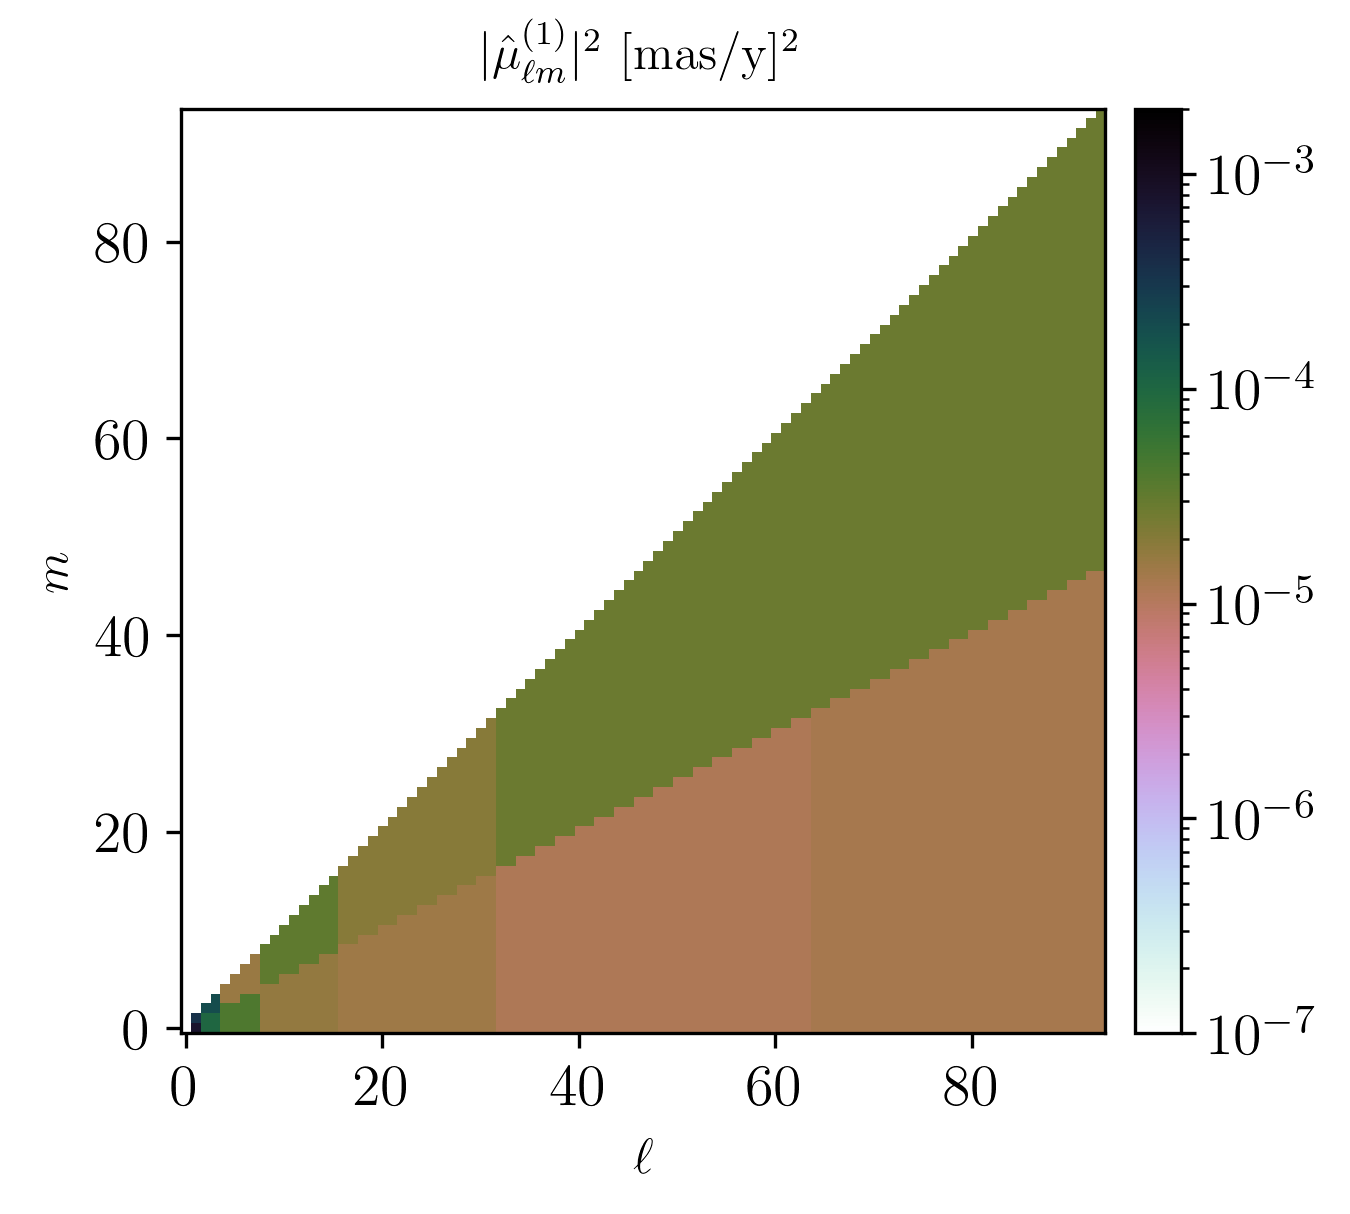

In [187]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im0 = ax.imshow(abs(fn_arr_pow_spec_B(mat_pow1_spec_raw_unit_B,lmax_pre_32)),  origin='lower', vmin=vmin_unit_B, vmax=vmax_unit_B, cmap='cubehelix_r',
                   norm=colors.LogNorm(vmin=vmin_unit_B, vmax=vmax_unit_B));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(1)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im0,cax=cax);
fig.savefig('pow1_spec_raw_unit_B.pdf')

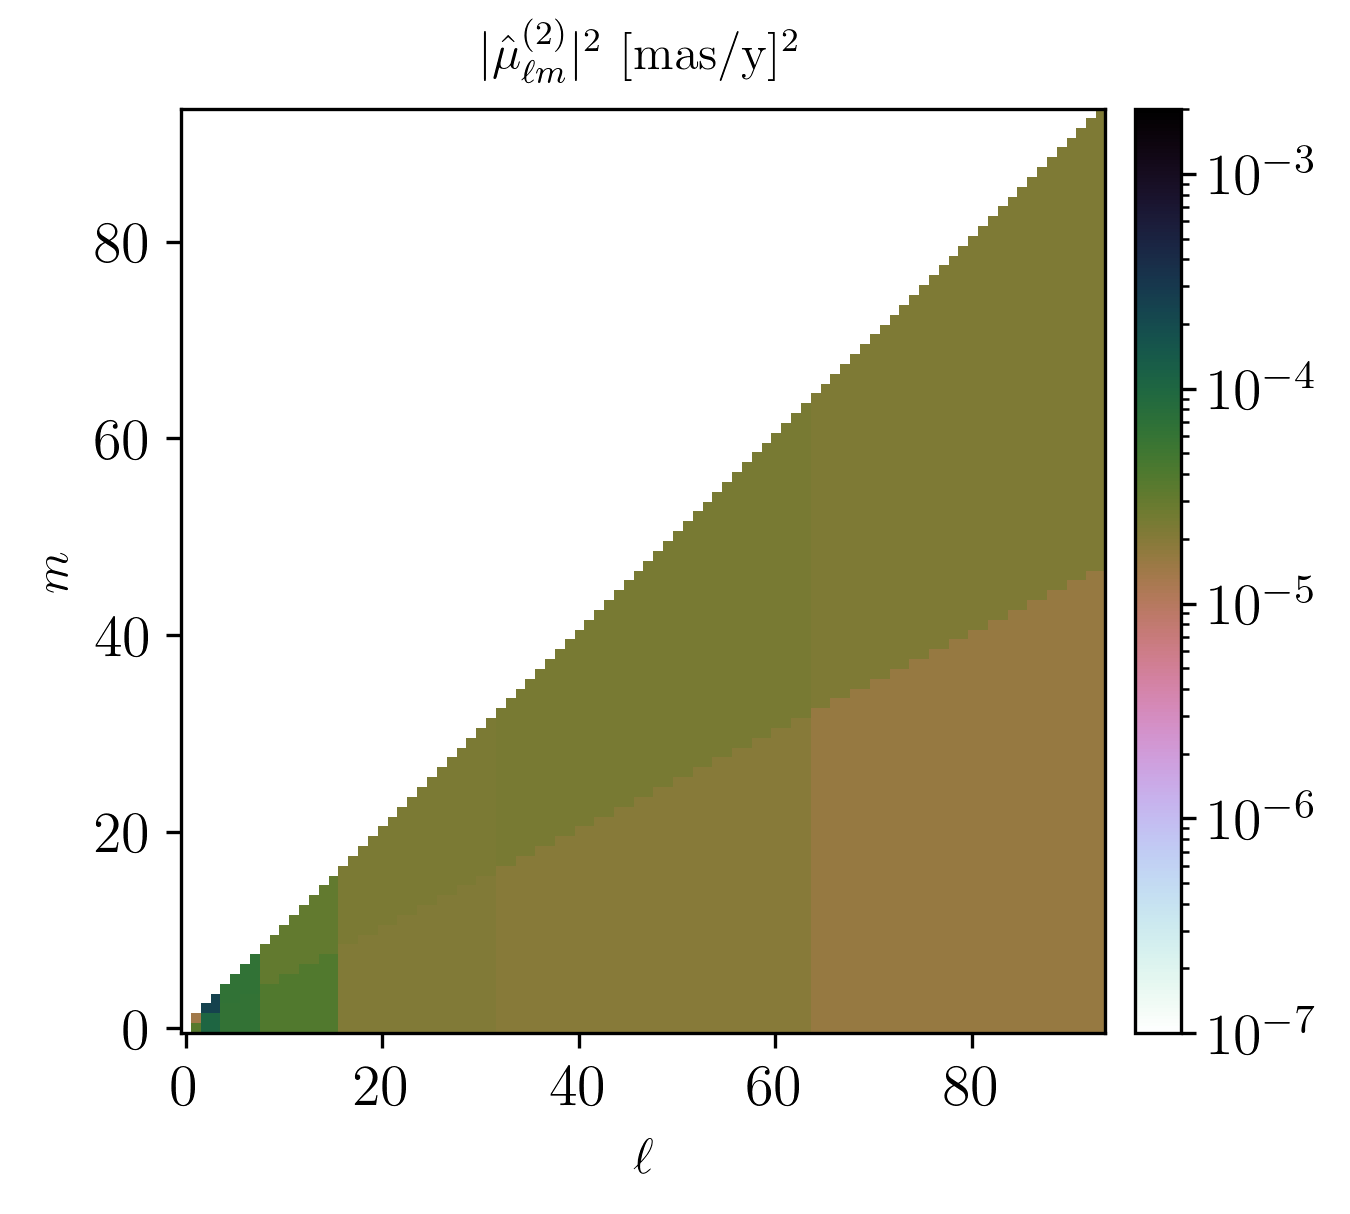

In [188]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im0 = ax.imshow(abs(fn_arr_pow_spec_B(mat_pow2_spec_raw_unit_B,lmax_pre_32)),  origin='lower', vmin=vmin_unit_B, vmax=vmax_unit_B, cmap='cubehelix_r',
                   norm=colors.LogNorm(vmin=vmin_unit_B, vmax=vmax_unit_B));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(2)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im0,cax=cax);
fig.savefig('pow2_spec_raw_unit_B.pdf')

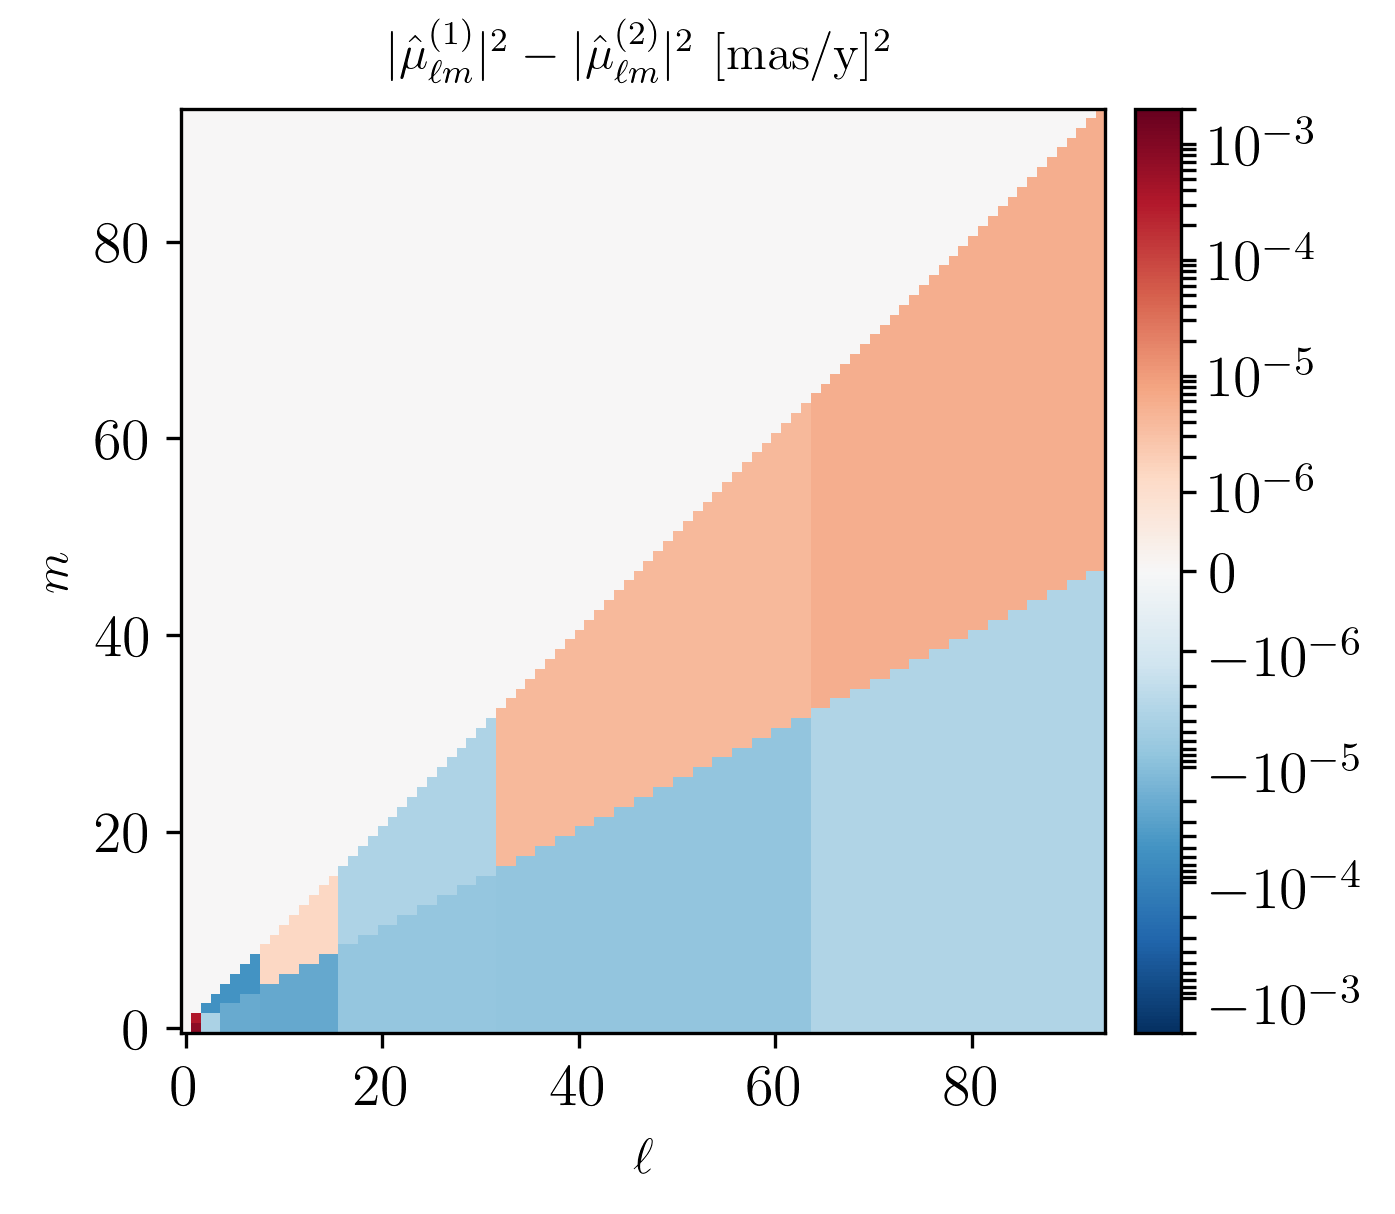

In [189]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im1 = ax.imshow(fn_arr_pow_spec_B(mat_pow1_spec_raw_unit_B-mat_pow2_spec_raw_unit_B,lmax_pre_32),  
                origin='lower', vmin=-vmax_unit, vmax=vmax_unit, cmap=cmap, norm=colors.SymLogNorm(linthresh=linthresh_unit, linscale=1, vmin=-vmax_unit, vmax=vmax_unit))
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(1)}_{\ell m}|^2-|\hat{\mu}^{(2)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1,cax=cax);
fig.savefig('pow_diff_spec_raw_unit_B.pdf');

#### 4.2.2 Subtracted data without weight map

In [212]:
data_map_b, data_map_l = pm_b_map_sub, pm_l_map_sub
mat_num1_sig = fn_pow_spec_trim(fn_mat_num1_sig(data_map_b, data_map_l,1))
mat_num2_sig = fn_pow_spec_trim(fn_mat_num2_sig(data_map_b, data_map_l,1))

mat_pow1_spec_sub_unit = (1/2) * mat_num1_sig
mat_pow2_spec_sub_unit = (1/2) *  mat_num2_sig

mat_W_B_lm = fn_mat_W_B_lm(np.int(np.sqrt(mat_num1_sig.shape[0])-1))
mat_pow1_spec_sub_unit_B = mat_W_B_lm @ mat_pow1_spec_sub_unit
mat_pow2_spec_sub_unit_B = mat_W_B_lm @ mat_pow2_spec_sub_unit

In [213]:
vmin_unit, vmax_unit = 10**(-7), 2*10**(-3)
linthresh_unit = 10**(-6)

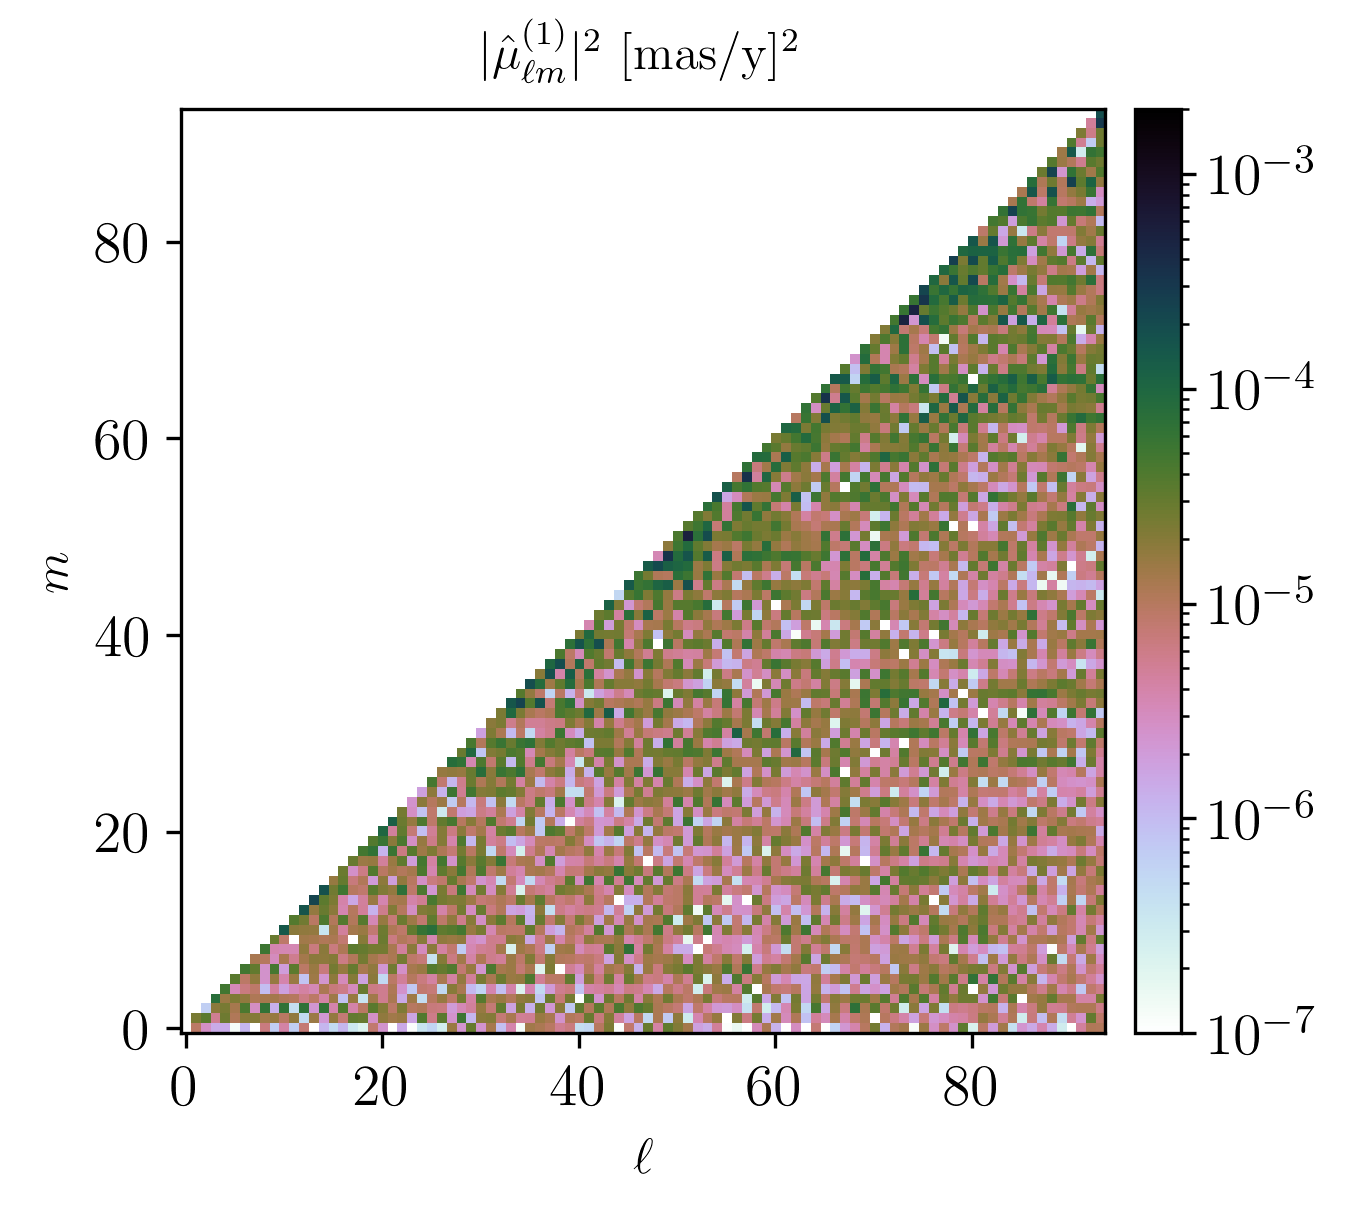

In [214]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im0 = ax.imshow(abs(fn_arr_pow_spec(mat_pow1_spec_sub_unit)),  origin='lower', vmin=vmin_unit, vmax=vmax_unit, cmap='cubehelix_r',
                   norm=colors.LogNorm(vmin=vmin_unit, vmax=vmax_unit));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(1)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im0,cax=cax);
fig.savefig('pow1_spec_sub_unit.pdf')

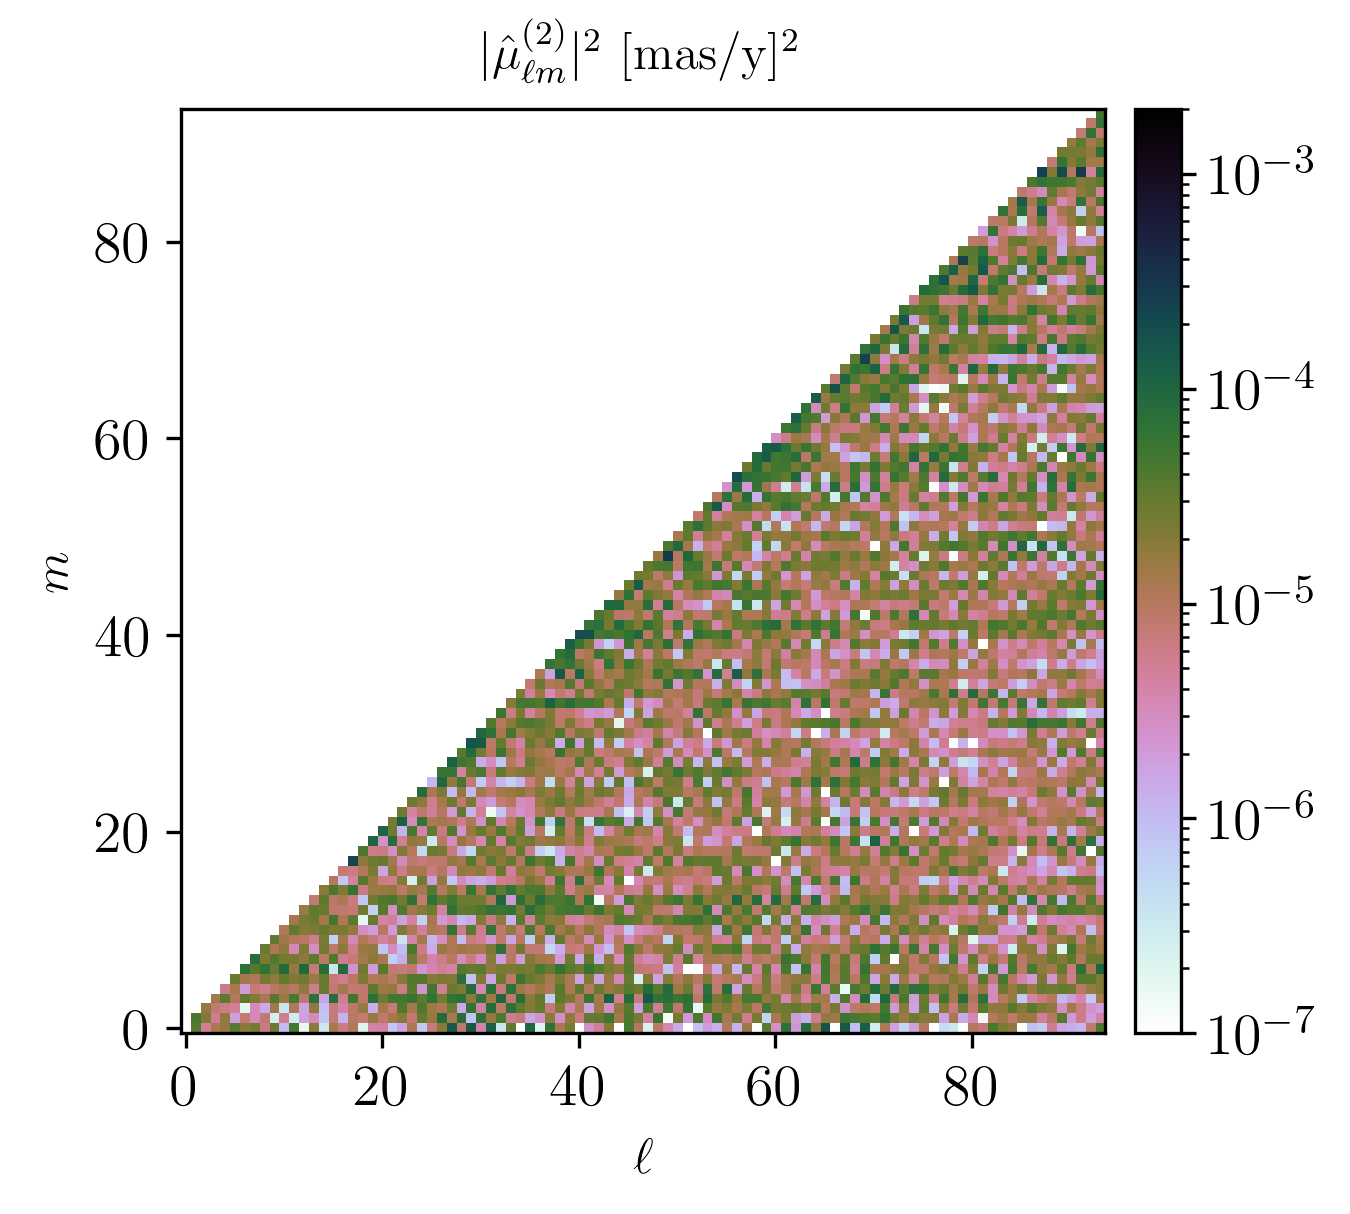

In [215]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im1 = ax.imshow(abs(fn_arr_pow_spec(mat_pow2_spec_sub_unit)),  origin='lower', vmin=vmin_unit, vmax=vmax_unit, cmap='cubehelix_r',
                   norm=colors.LogNorm(vmin=vmin_unit, vmax=vmax_unit));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(2)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1,cax=cax);
fig.savefig('pow2_spec_sub_unit.pdf');

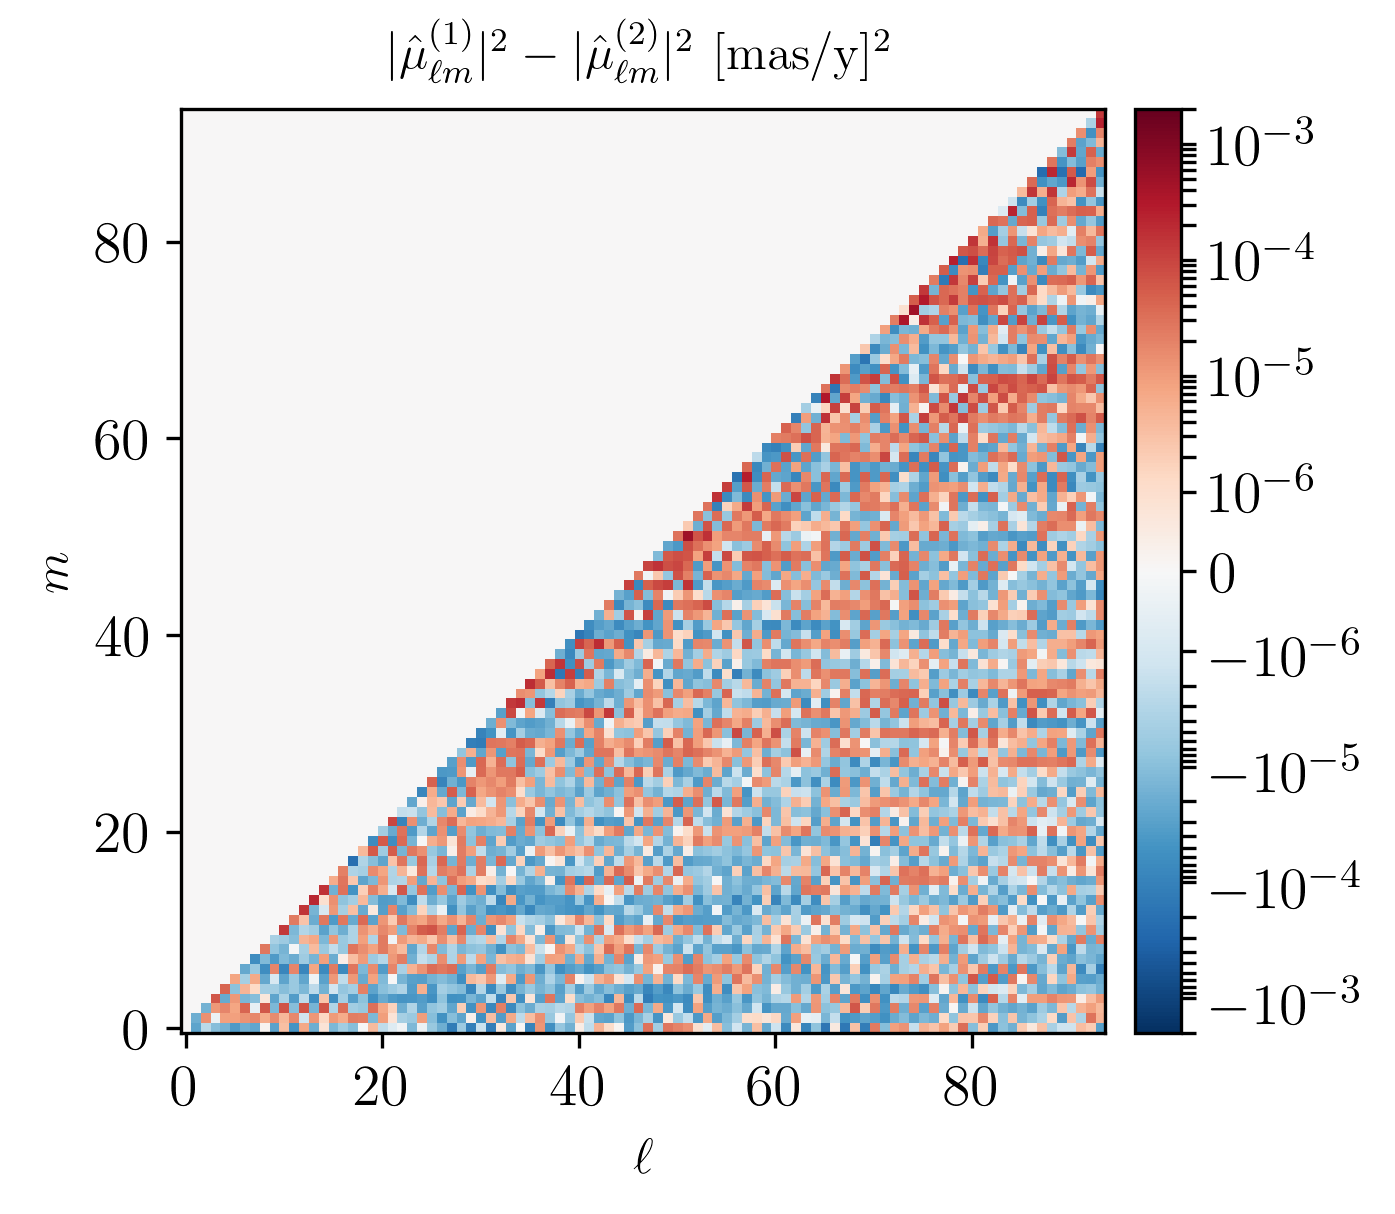

In [216]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im1 = ax.imshow(fn_arr_pow_spec(mat_pow1_spec_sub_unit-mat_pow2_spec_sub_unit),  origin='lower', vmin=-vmax_unit, vmax=vmax_unit, cmap=cmap, 
                norm=colors.SymLogNorm(linthresh=linthresh_unit, linscale=1, vmin=-vmax_unit, vmax=vmax_unit))
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(1)}_{\ell m}|^2-|\hat{\mu}^{(2)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1,cax=cax);
fig.savefig('pow_diff_spec_sub_unit.pdf');

In [217]:
#vmin_unit_B = 10**(-6); vmax_unit_B = 10**(-3)
vmin_unit_B = vmin_unit/100; vmax_unit_B = vmax_unit
linthresh_unit_B = vmin_unit_B * 1000;

In [218]:
np.transpose([mat_pow1_spec_injection_unit_B, mat_pow2_spec_injection_unit_B, mat_pow1_spec_injection_unit_B - mat_pow2_spec_injection_unit_B]).tolist()

NameError: name 'mat_pow1_spec_injection_unit_B' is not defined

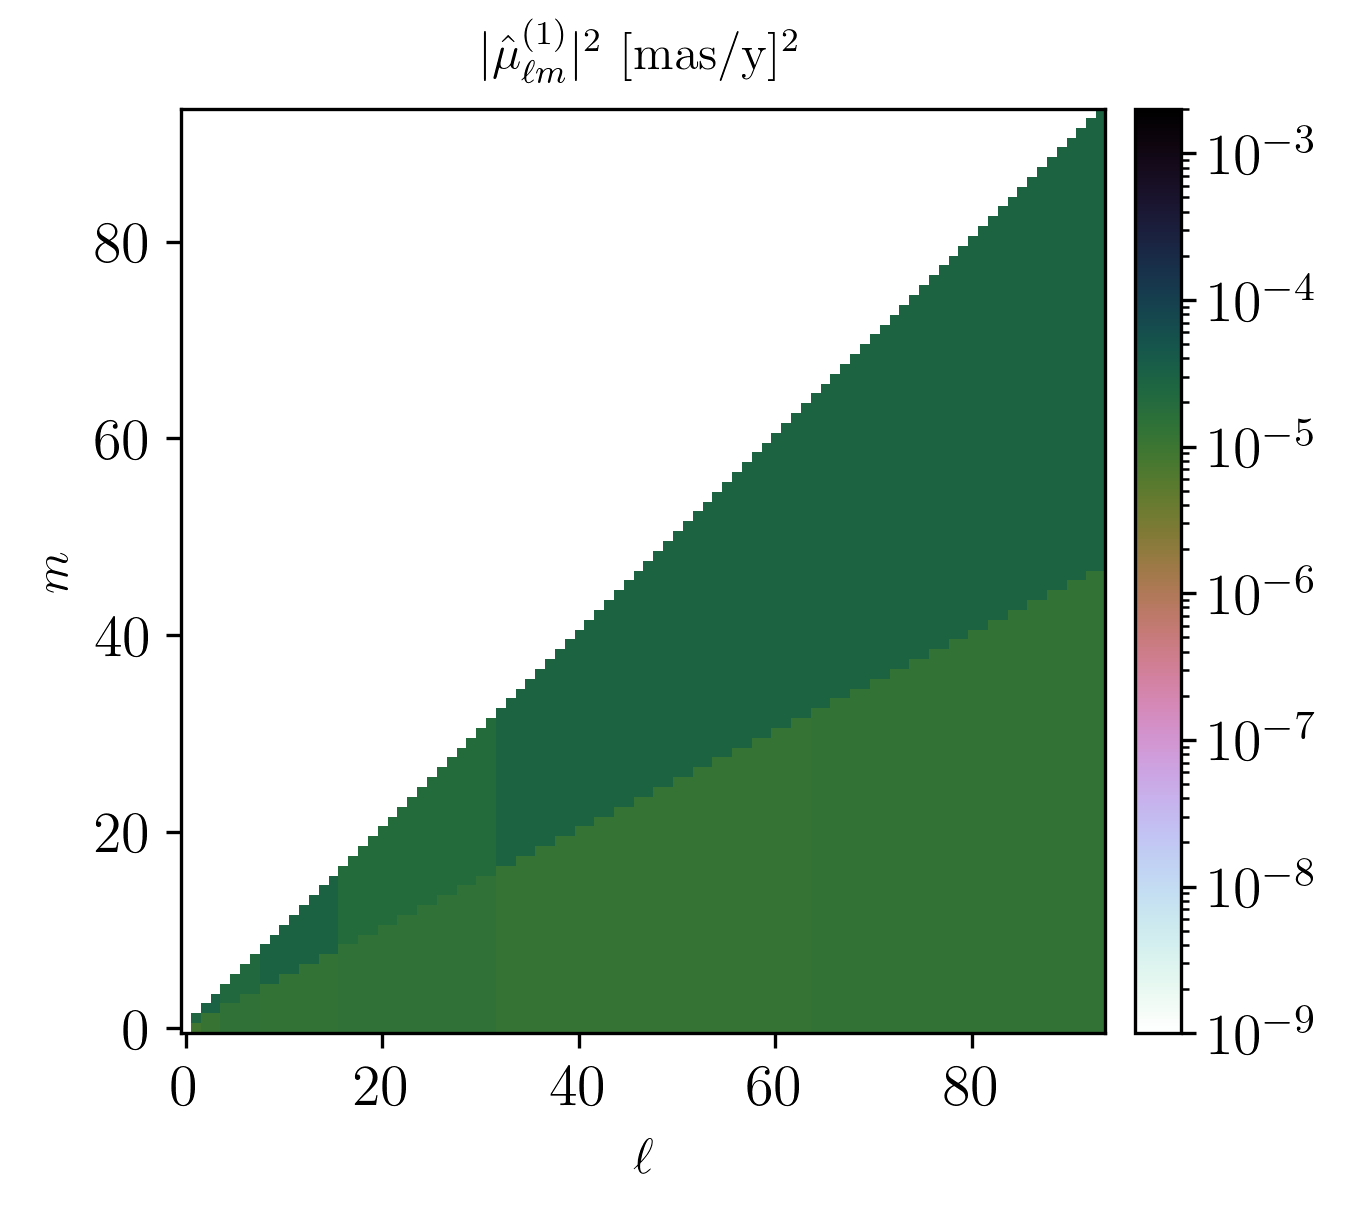

In [219]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im0 = ax.imshow(abs(fn_arr_pow_spec_B(mat_pow1_spec_sub_unit_B,lmax_pre_32)),  origin='lower', vmin=vmin_unit_B, vmax=vmax_unit_B, cmap='cubehelix_r',
                   norm=colors.LogNorm(vmin=vmin_unit_B, vmax=vmax_unit_B));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(1)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im0,cax=cax);
fig.savefig('pow1_spec_sub_unit_B.pdf')

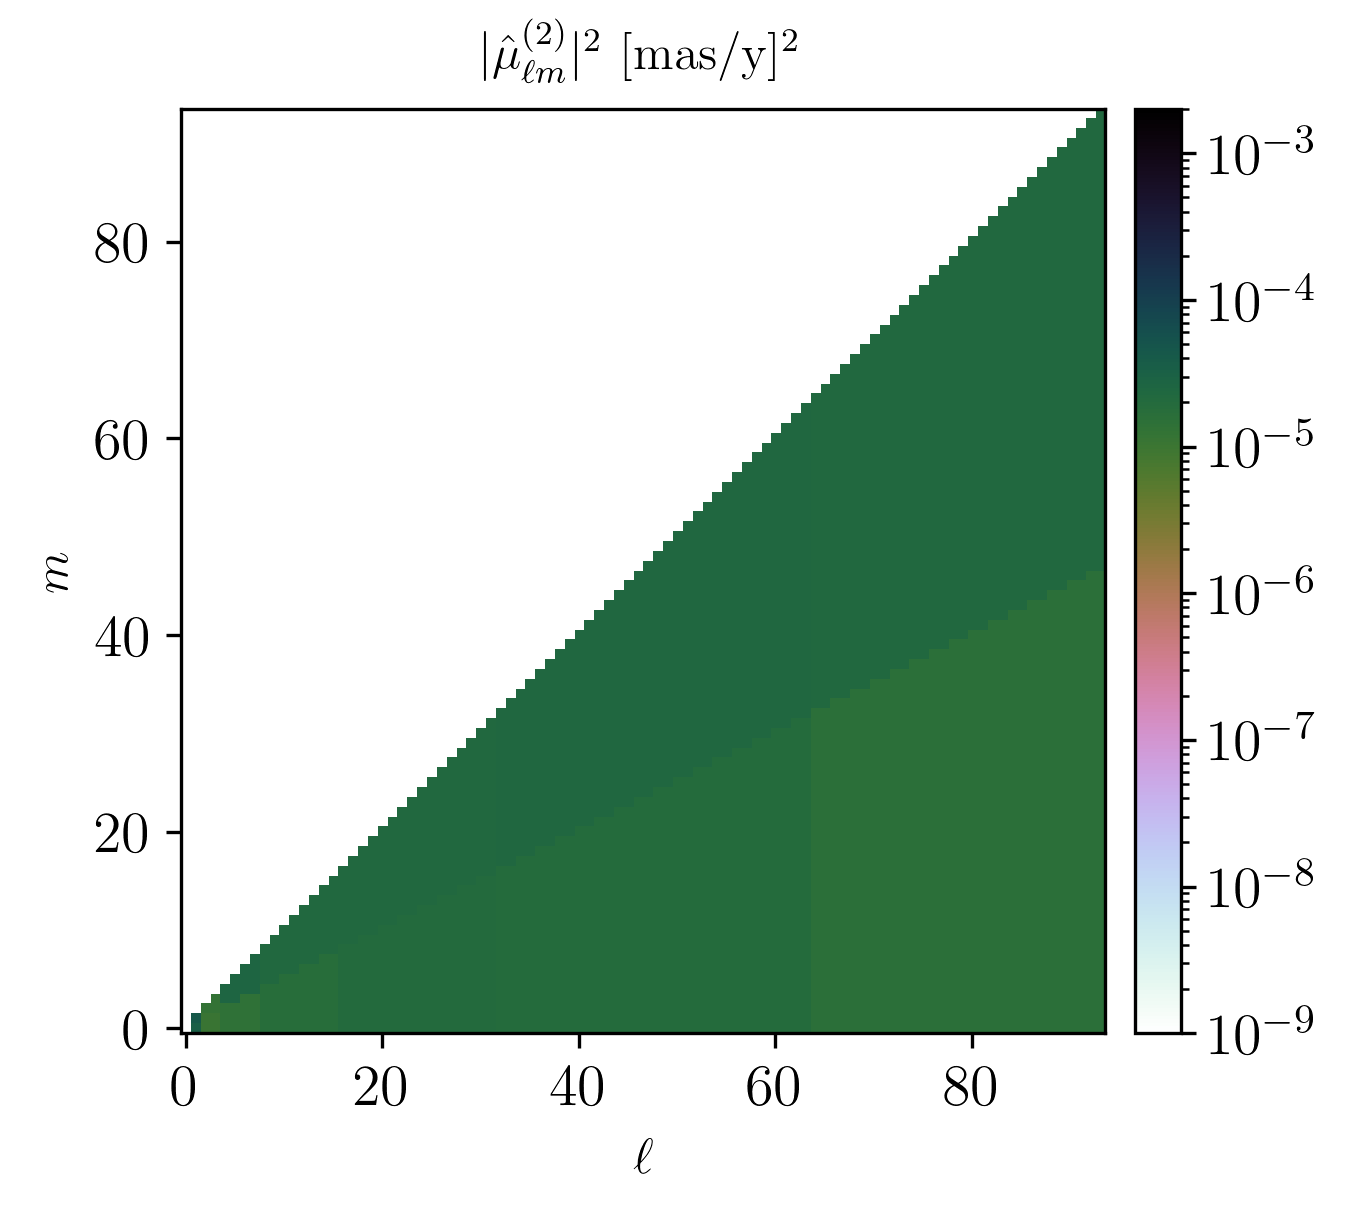

In [220]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im0 = ax.imshow(abs(fn_arr_pow_spec_B(mat_pow2_spec_sub_unit_B,lmax_pre_32)),  origin='lower', vmin=vmin_unit_B, vmax=vmax_unit_B, cmap='cubehelix_r',
                   norm=colors.LogNorm(vmin=vmin_unit_B, vmax=vmax_unit_B));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(2)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im0,cax=cax);
fig.savefig('pow2_spec_sub_unit_B.pdf')

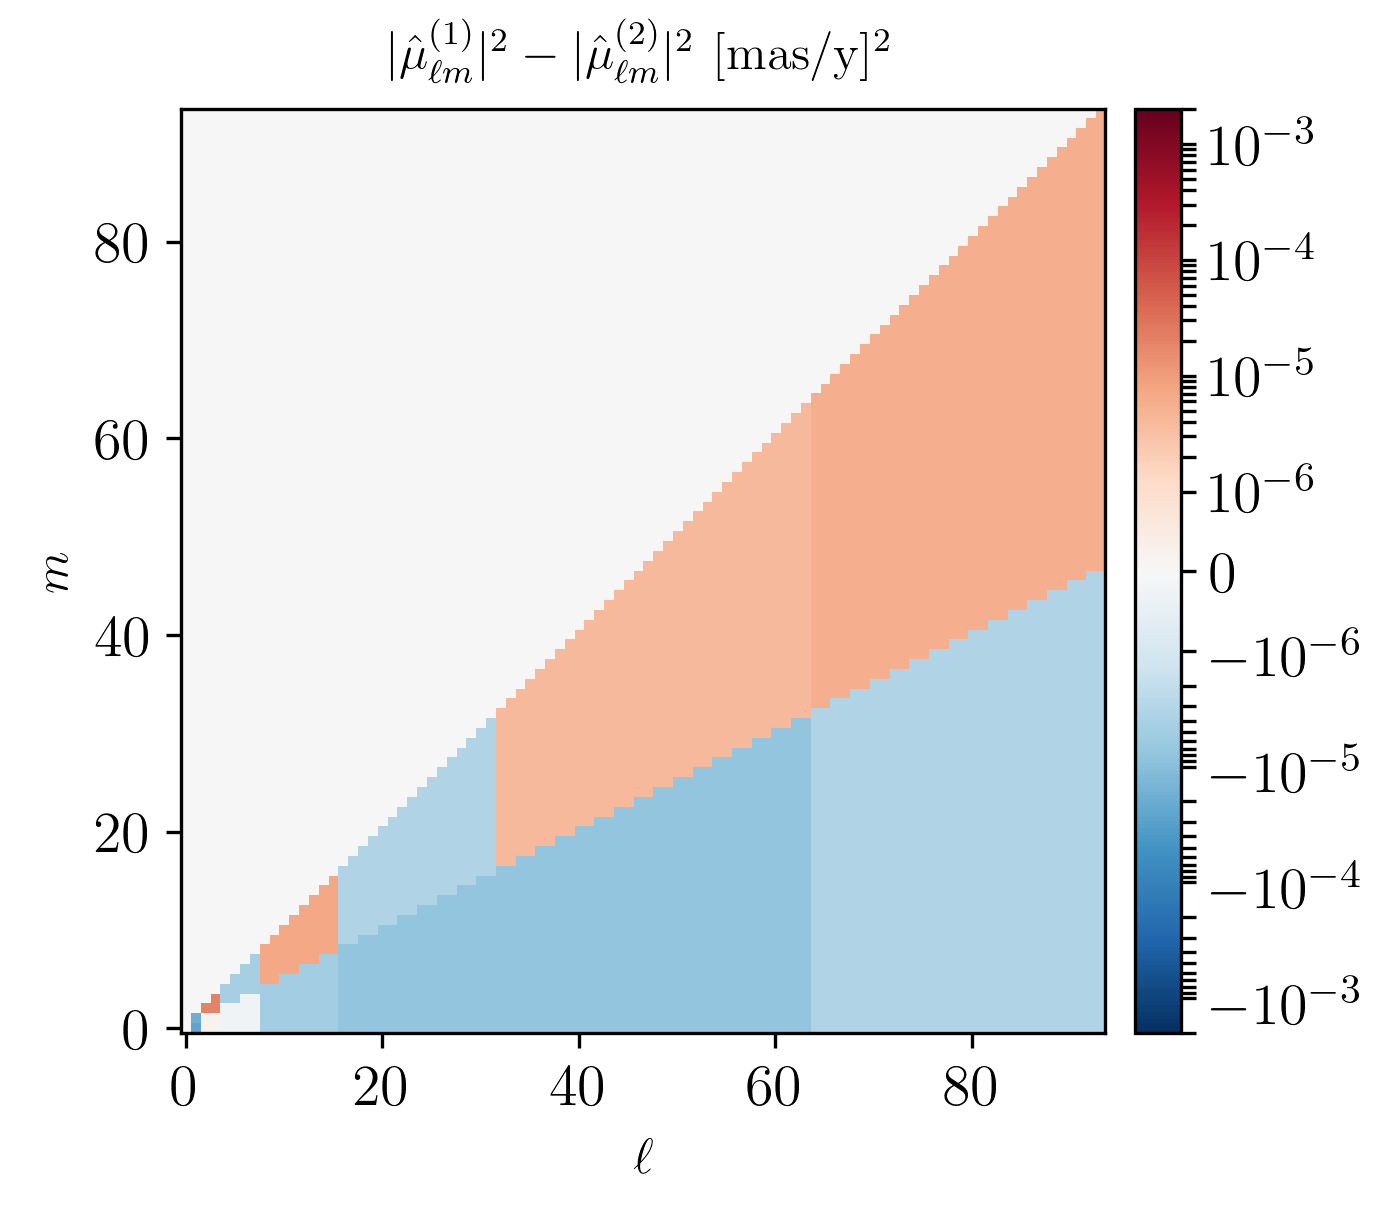

In [221]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im1 = ax.imshow(fn_arr_pow_spec_B(mat_pow1_spec_sub_unit_B-mat_pow2_spec_sub_unit_B,lmax_pre_32),  
                origin='lower', vmin=-vmax_unit_B, vmax=vmax_unit_B, cmap=cmap, norm=colors.SymLogNorm(linthresh=linthresh_unit_B, linscale=1, vmin=-vmax_unit_B, vmax=vmax_unit_B))
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(1)}_{\ell m}|^2-|\hat{\mu}^{(2)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1,cax=cax);
fig.savefig('pow_diff_spec_sub_unit_B.pdf');

#### 4.2.3 Injected data without weight map

In [222]:
data_map_b, data_map_l = pm_b_map_injection, pm_l_map_injection
mat_num1_sig = fn_pow_spec_trim(fn_mat_num1_sig(data_map_b, data_map_l,1))
mat_num2_sig = fn_pow_spec_trim(fn_mat_num2_sig(data_map_b, data_map_l,1))

mat_pow1_spec_injection_unit = (1/2) * mat_num1_sig
mat_pow2_spec_injection_unit = (1/2) *  mat_num2_sig

mat_W_B_lm = fn_mat_W_B_lm(np.int(np.sqrt(mat_num1_sig.shape[0])-1))
mat_pow1_spec_injection_unit_B = mat_W_B_lm @ mat_pow1_spec_injection_unit
mat_pow2_spec_injection_unit_B = mat_W_B_lm @ mat_pow2_spec_injection_unit

In [223]:
vmin_unit, vmax_unit = 10**(-18), 10**(-14)
linthresh_unit = 10**(-17)

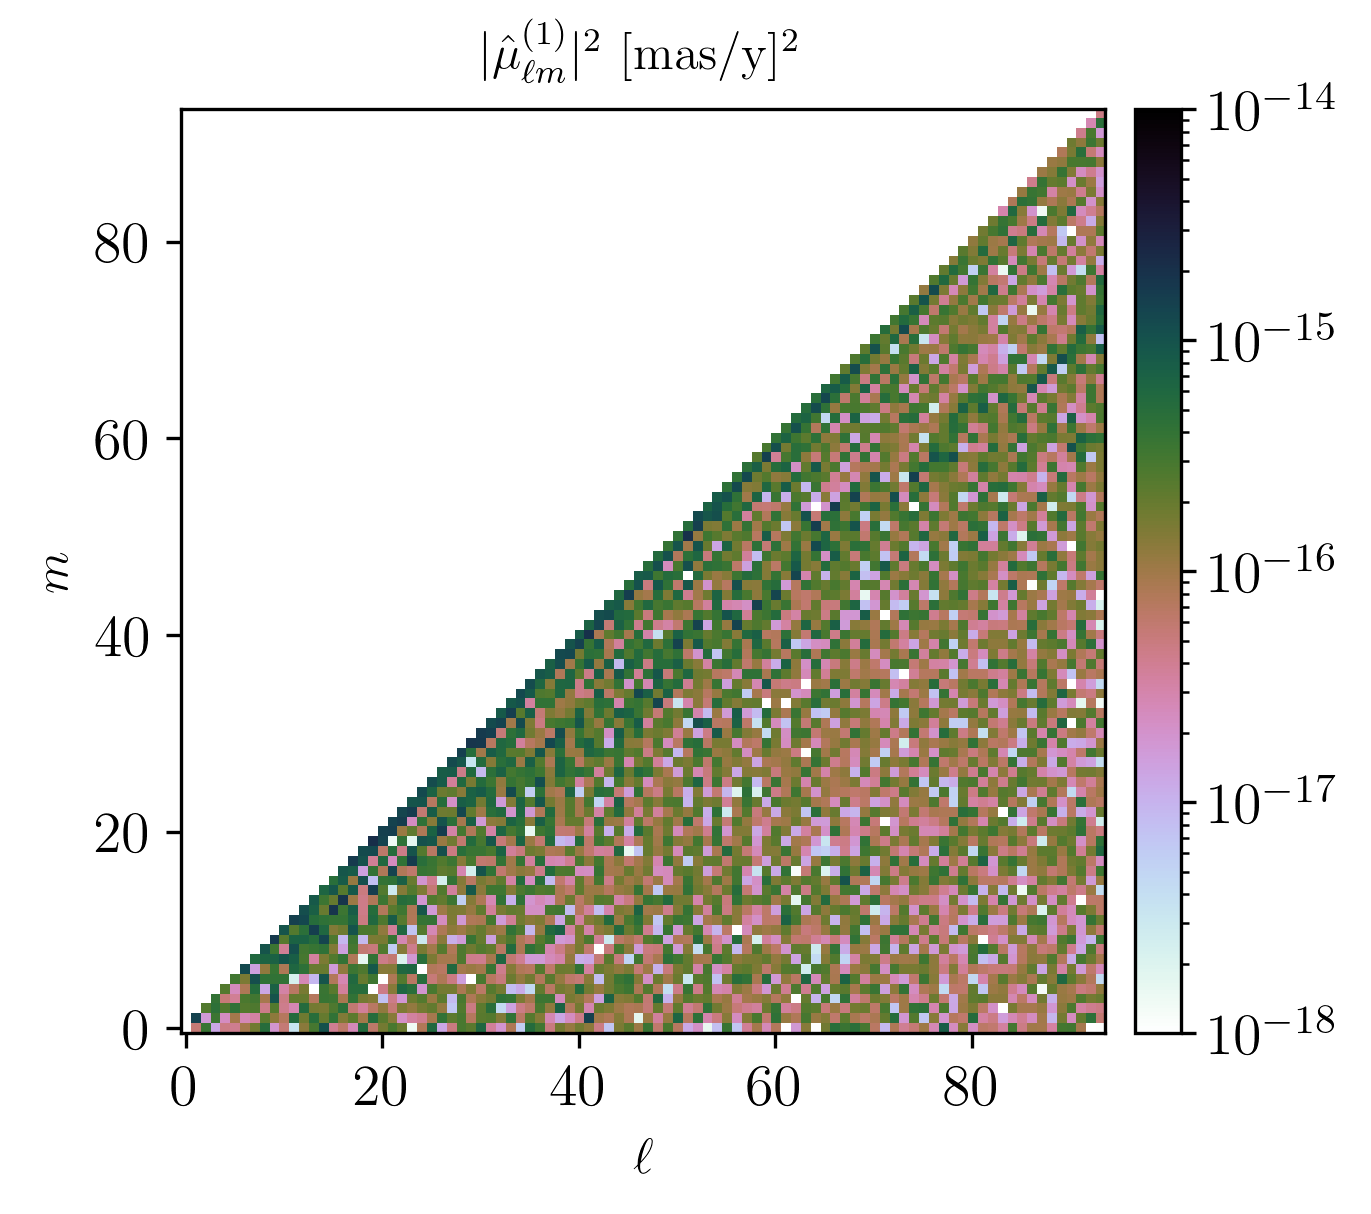

In [224]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im0 = ax.imshow(abs(fn_arr_pow_spec(mat_pow1_spec_injection_unit)),  origin='lower', vmin=vmin_unit, vmax=vmax_unit, cmap='cubehelix_r',
                   norm=colors.LogNorm(vmin=vmin_unit, vmax=vmax_unit));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(1)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im0,cax=cax);
fig.savefig('pow1_spec_injection_unit.pdf')

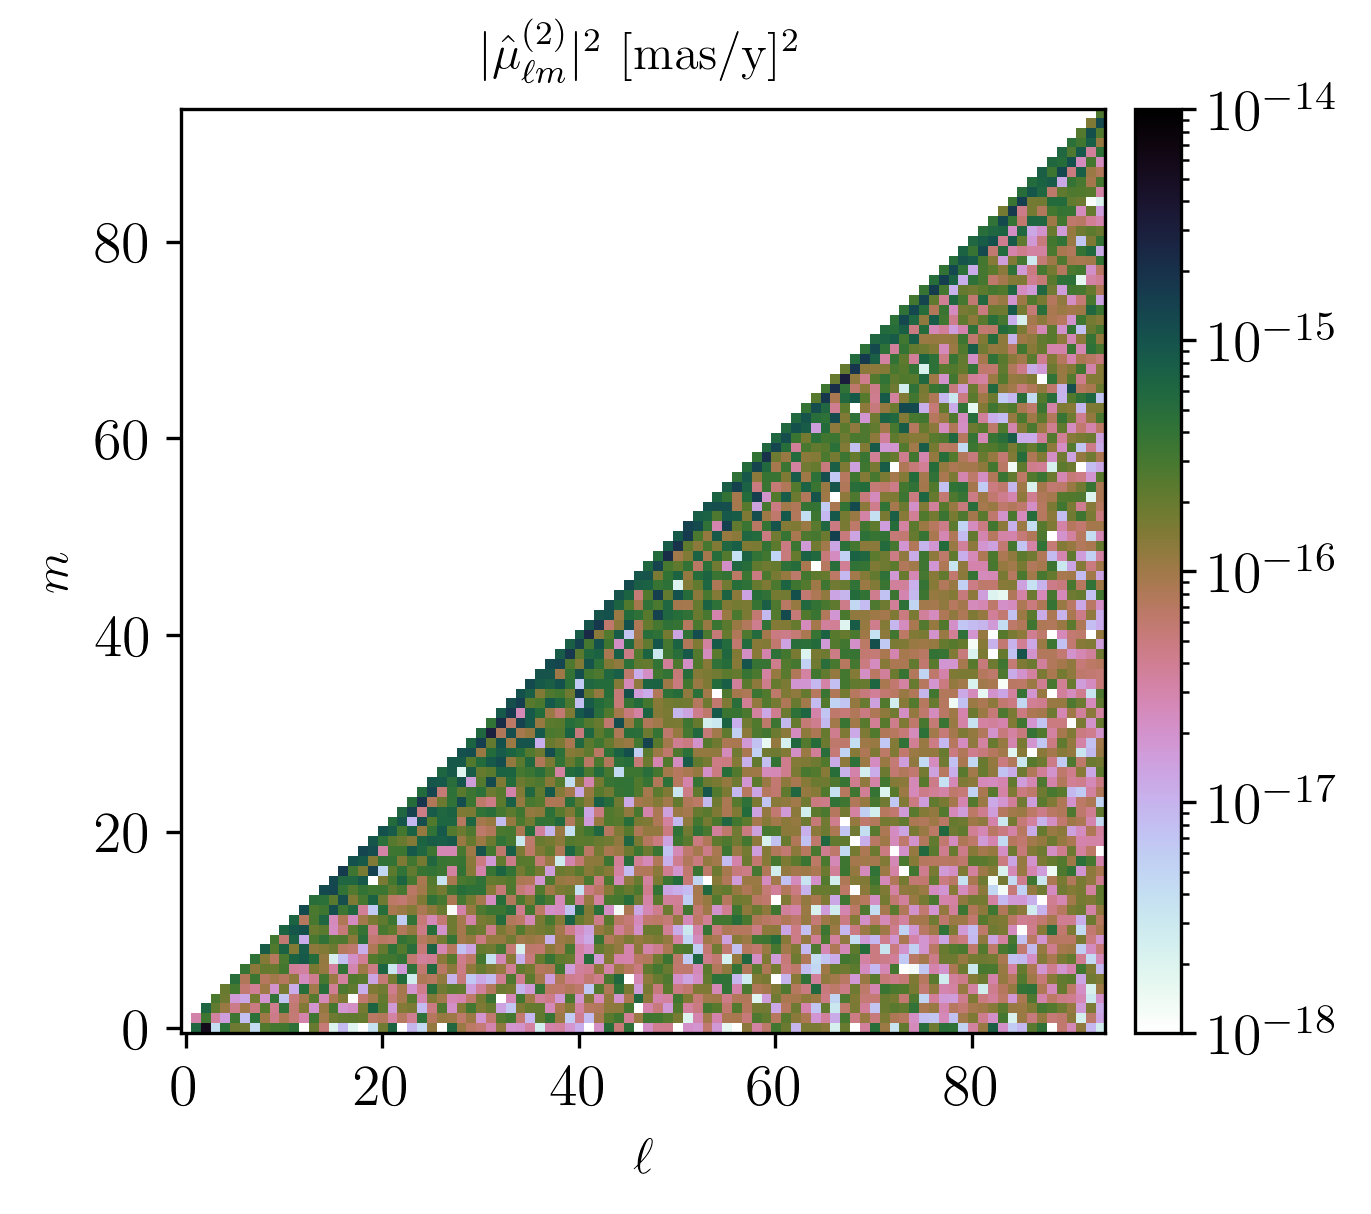

In [225]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im1 = ax.imshow(abs(fn_arr_pow_spec(mat_pow2_spec_injection_unit)),  origin='lower', vmin=vmin_unit, vmax=vmax_unit, cmap='cubehelix_r',
                   norm=colors.LogNorm(vmin=vmin_unit, vmax=vmax_unit));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(2)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1,cax=cax);
fig.savefig('pow2_spec_injection_unit.pdf');

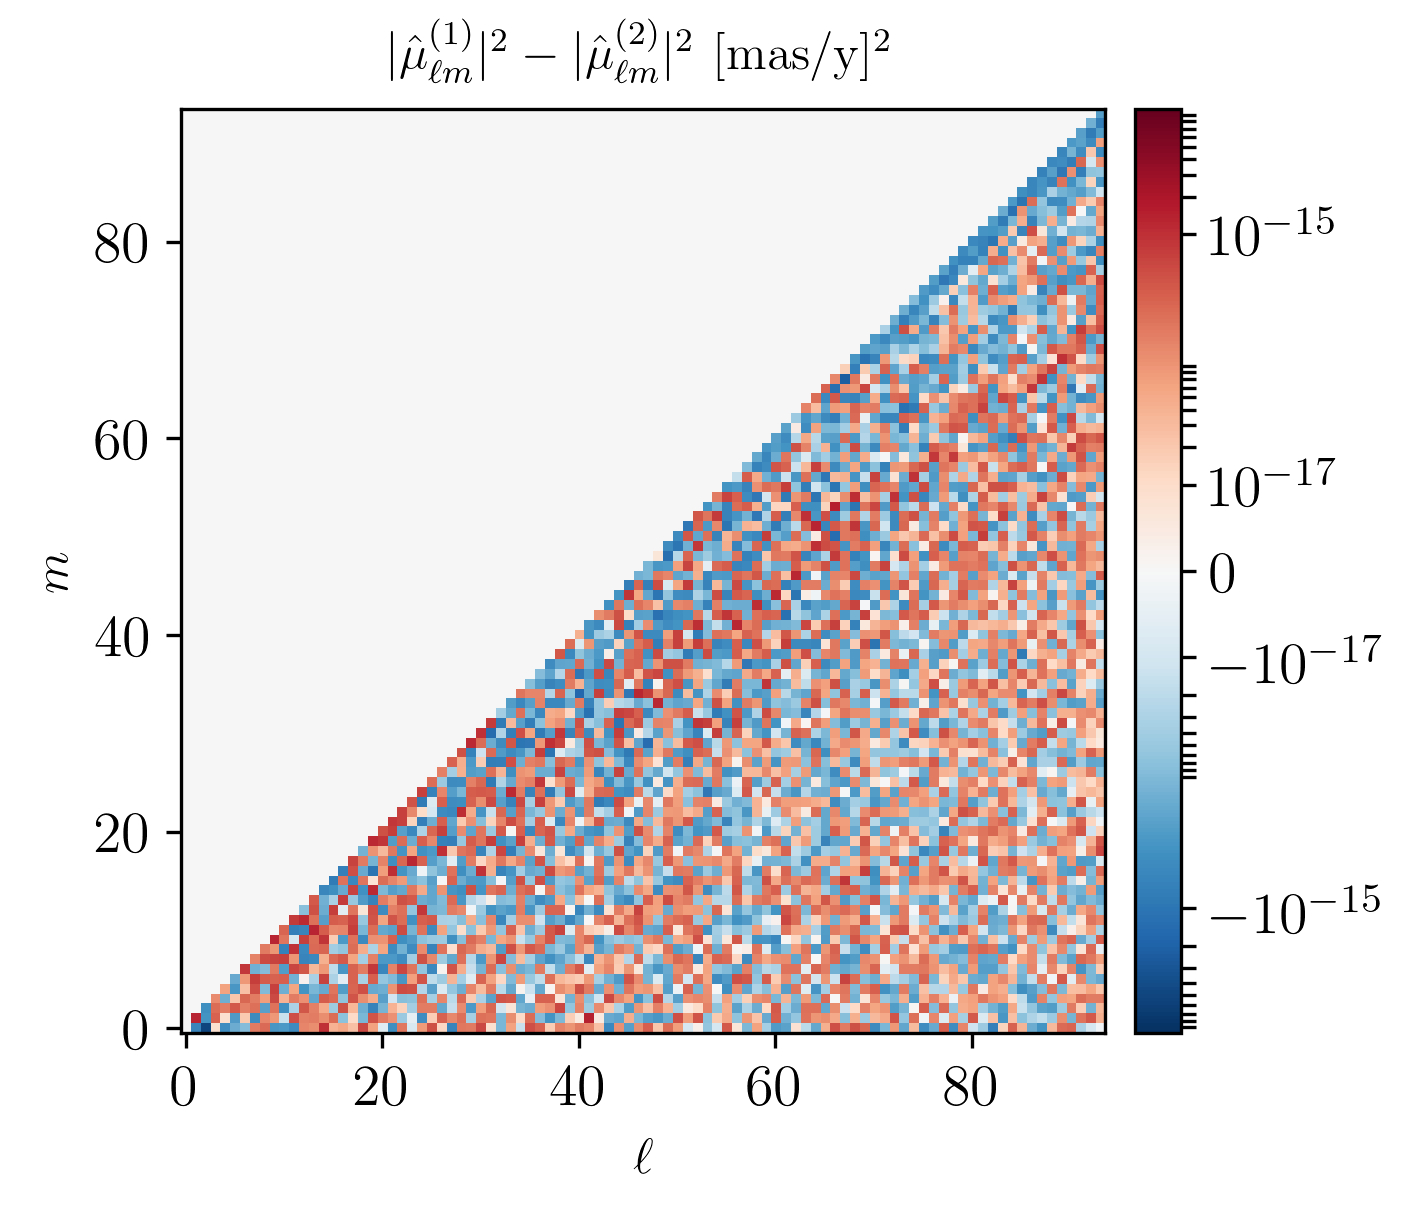

In [226]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im1 = ax.imshow(fn_arr_pow_spec(mat_pow1_spec_injection_unit-mat_pow2_spec_injection_unit),  origin='lower', vmin=-vmax_unit, vmax=vmax_unit, cmap=cmap, norm=colors.SymLogNorm(linthresh=linthresh_unit, linscale=1, vmin=-vmax_unit, vmax=vmax_unit))
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(1)}_{\ell m}|^2-|\hat{\mu}^{(2)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1,cax=cax);
fig.savefig('pow_diff_spec_injection_unit.pdf');

In [227]:
#vmin_unit_B = 10**(-6); vmax_unit_B = 10**(-3)
vmin_unit_B = vmin_unit; vmax_unit_B = vmax_unit

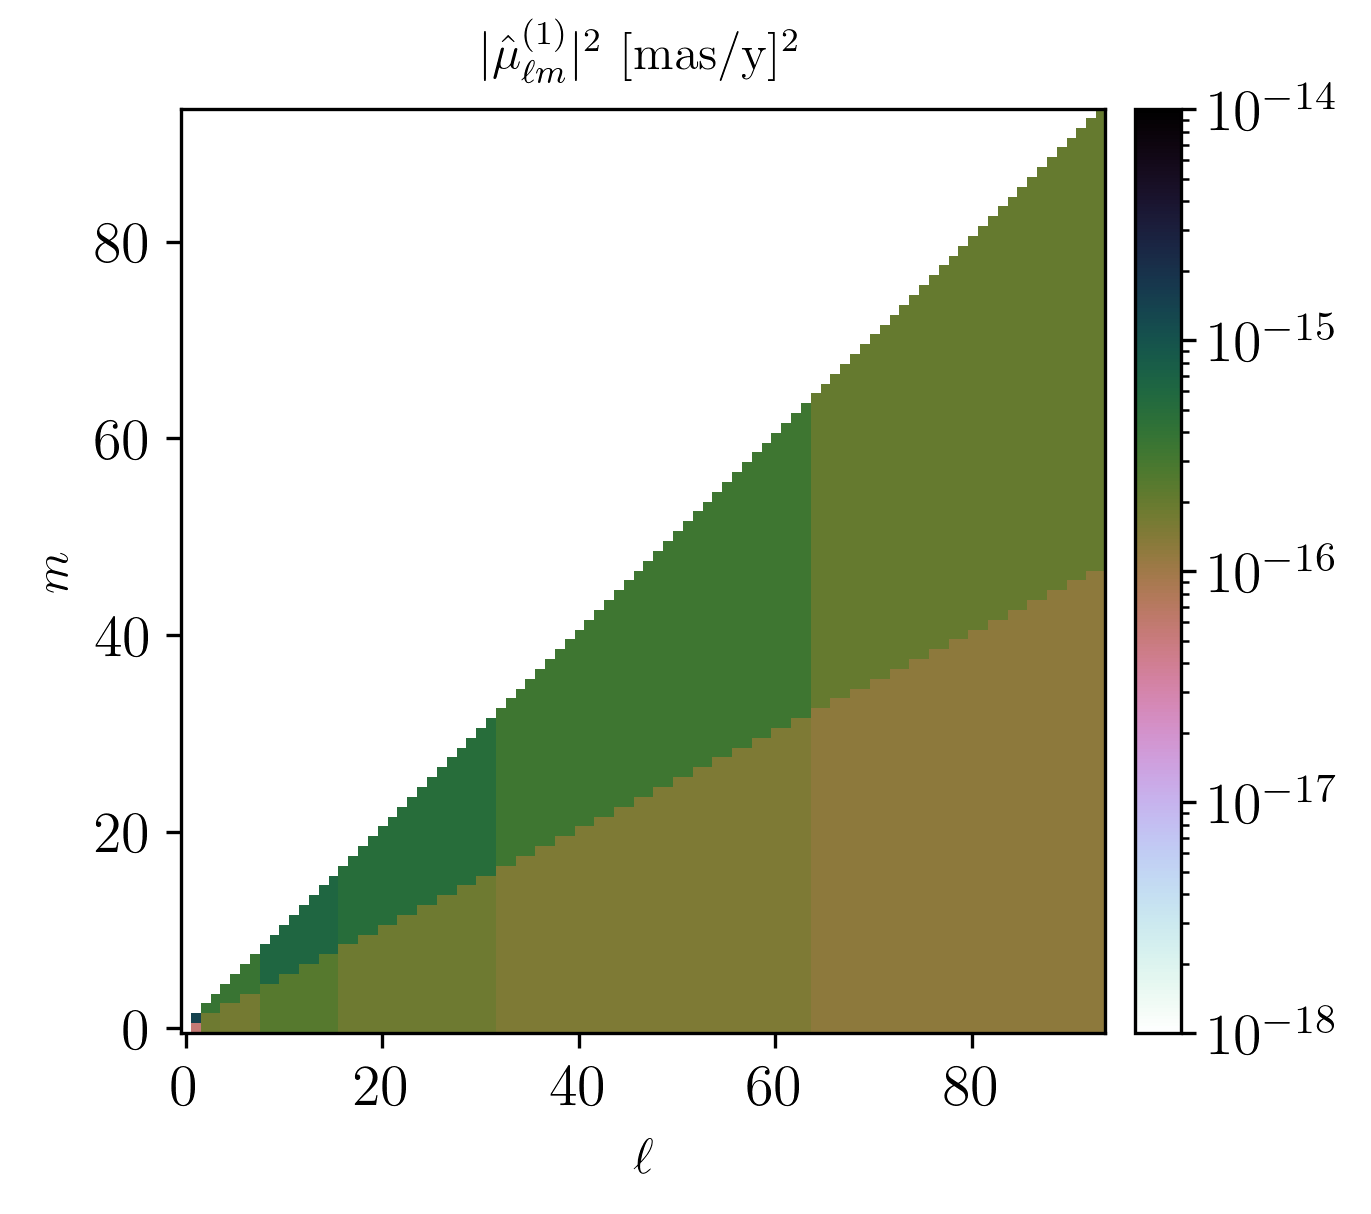

In [228]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im0 = ax.imshow(abs(fn_arr_pow_spec_B(mat_pow1_spec_injection_unit_B,lmax_pre_32)),  origin='lower', vmin=vmin_unit_B, vmax=vmax_unit_B, cmap='cubehelix_r',
                   norm=colors.LogNorm(vmin=vmin_unit_B, vmax=vmax_unit_B));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(1)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im0,cax=cax);
fig.savefig('pow1_spec_injection_unit_B.pdf')

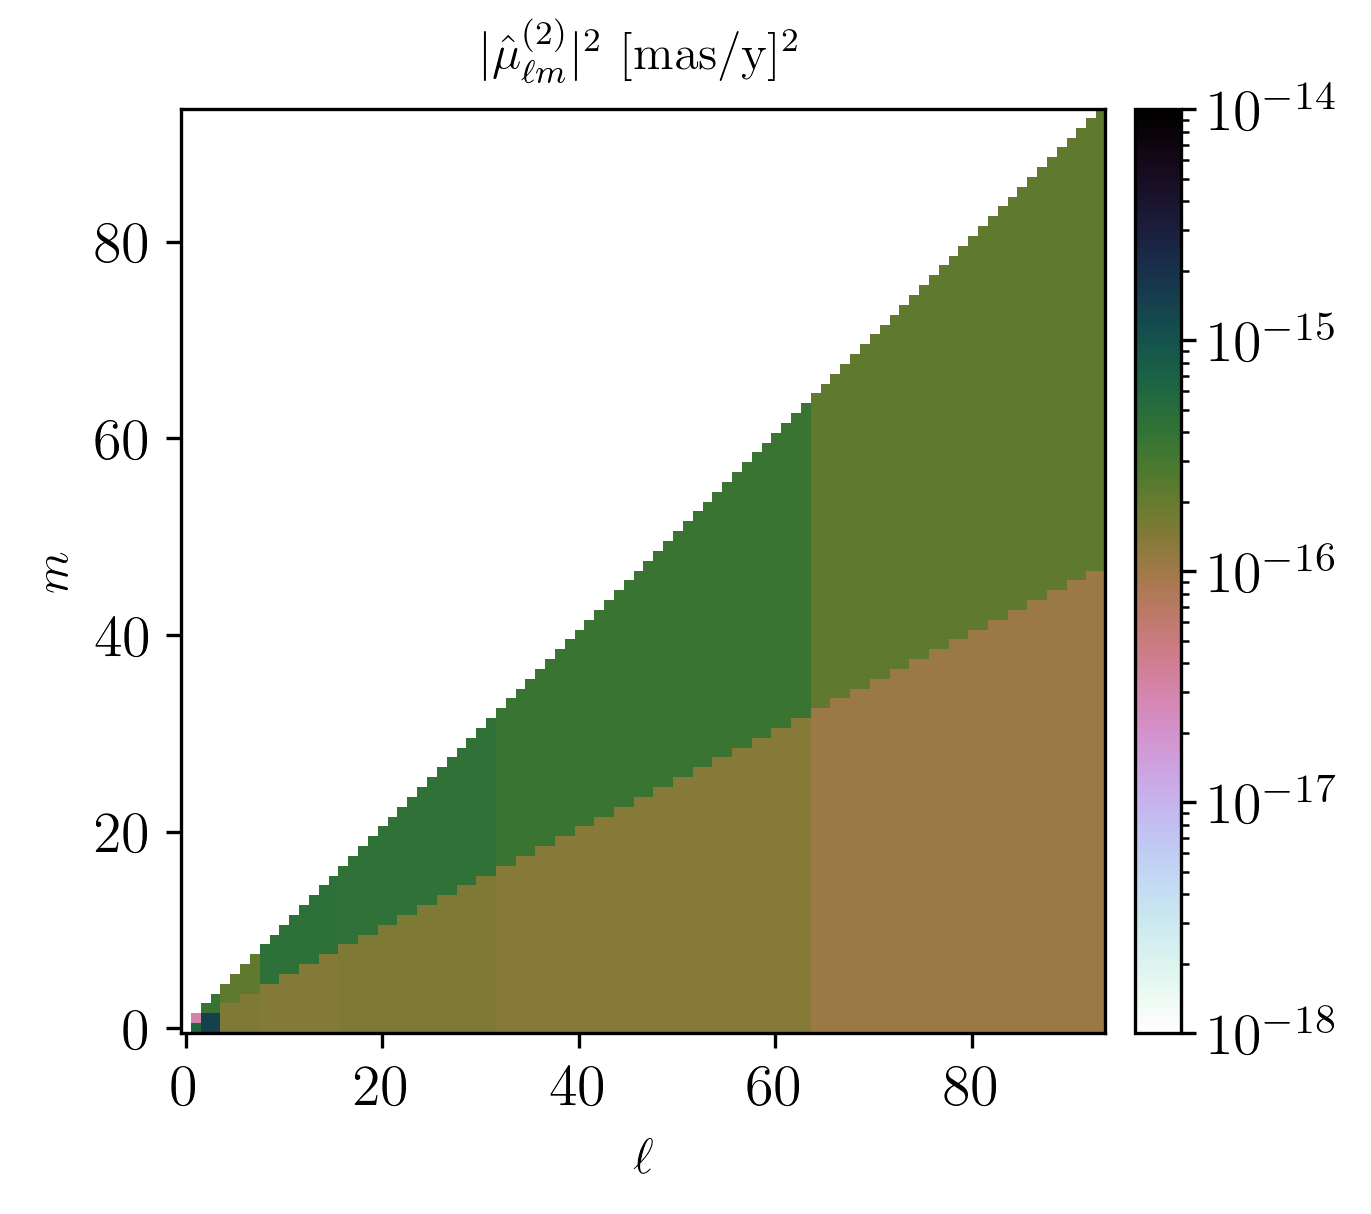

In [229]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im0 = ax.imshow(abs(fn_arr_pow_spec_B(mat_pow2_spec_injection_unit_B,lmax_pre_32)),  origin='lower', vmin=vmin_unit_B, vmax=vmax_unit_B, cmap='cubehelix_r',
                   norm=colors.LogNorm(vmin=vmin_unit_B, vmax=vmax_unit_B));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(2)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im0,cax=cax);
fig.savefig('pow2_spec_injection_unit_B.pdf')

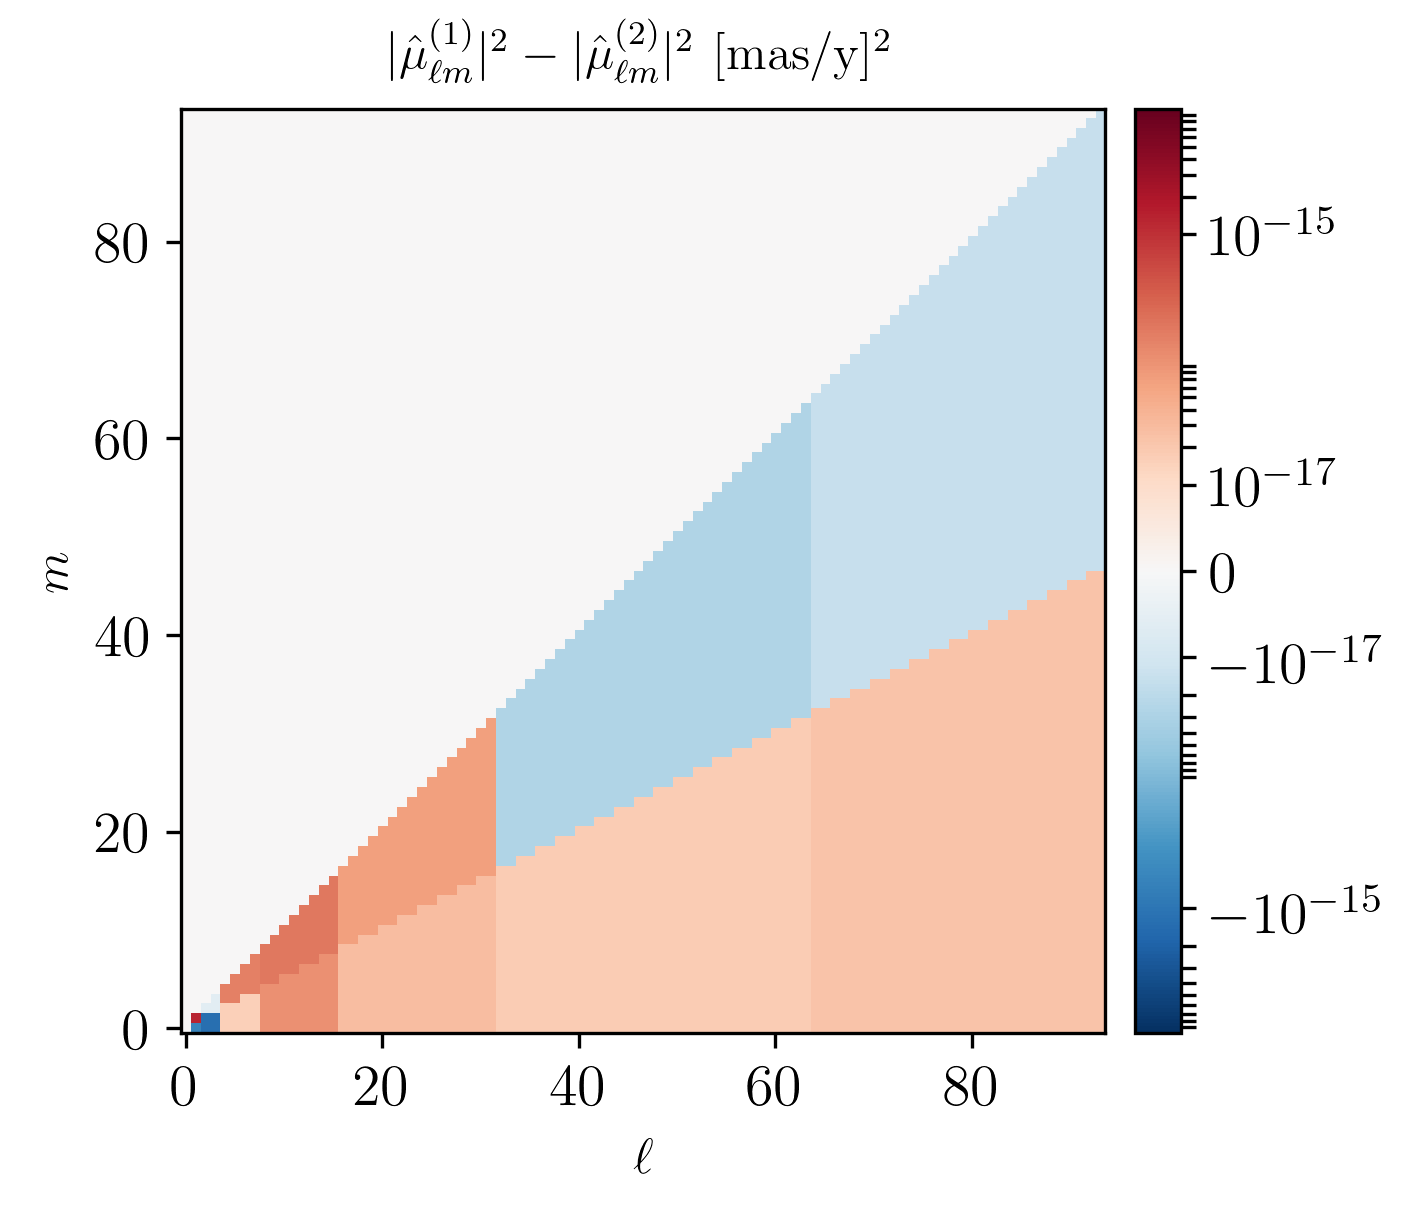

In [230]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im1 = ax.imshow(fn_arr_pow_spec_B(mat_pow1_spec_injection_unit_B-mat_pow2_spec_injection_unit_B,lmax_pre_32),  
                origin='lower', vmin=-vmax_unit, vmax=vmax_unit, cmap=cmap, norm=colors.SymLogNorm(linthresh=linthresh_unit, linscale=1, vmin=-vmax_unit, vmax=vmax_unit))
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(1)}_{\ell m}|^2-|\hat{\mu}^{(2)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1,cax=cax);
fig.savefig('pow_diff_spec_injection_unit_B.pdf');

#### 4.2.4 Raw data with weight map

In [231]:
mat_W_B_lm = fn_mat_W_B_lm(lmax_pre_32)
mat_W_inv_lm_B = fn_mat_W_inv_lm_B(lmax_pre_32)
mat_W_B_lm.shape, mat_W_inv_lm_B.shape

((14, 8836), (8836, 14))

In [232]:
data_map_b, data_map_l = pm_b_map, pm_l_map
mat_num1_sig = fn_pow_spec_trim(fn_mat_num1_sig(data_map_b, data_map_l,weights_map))
mat_num2_sig = fn_pow_spec_trim(fn_mat_num2_sig(data_map_b, data_map_l,weights_map))

mat_pow1_spec_raw_weight_B = (1/2) * mat_Fisher_pre_32_B_inv @ (mat_num1_sig @ mat_W_inv_lm_B)
mat_pow2_spec_raw_weight_B = (1/2) * mat_Fisher_pre_32_B_inv @ (mat_num2_sig @ mat_W_inv_lm_B)

In [233]:
vmin_weight_B, vmax_weight_B = 10**(-7),2*10**(-3)
linthresh_weight_B = 10**(-7)

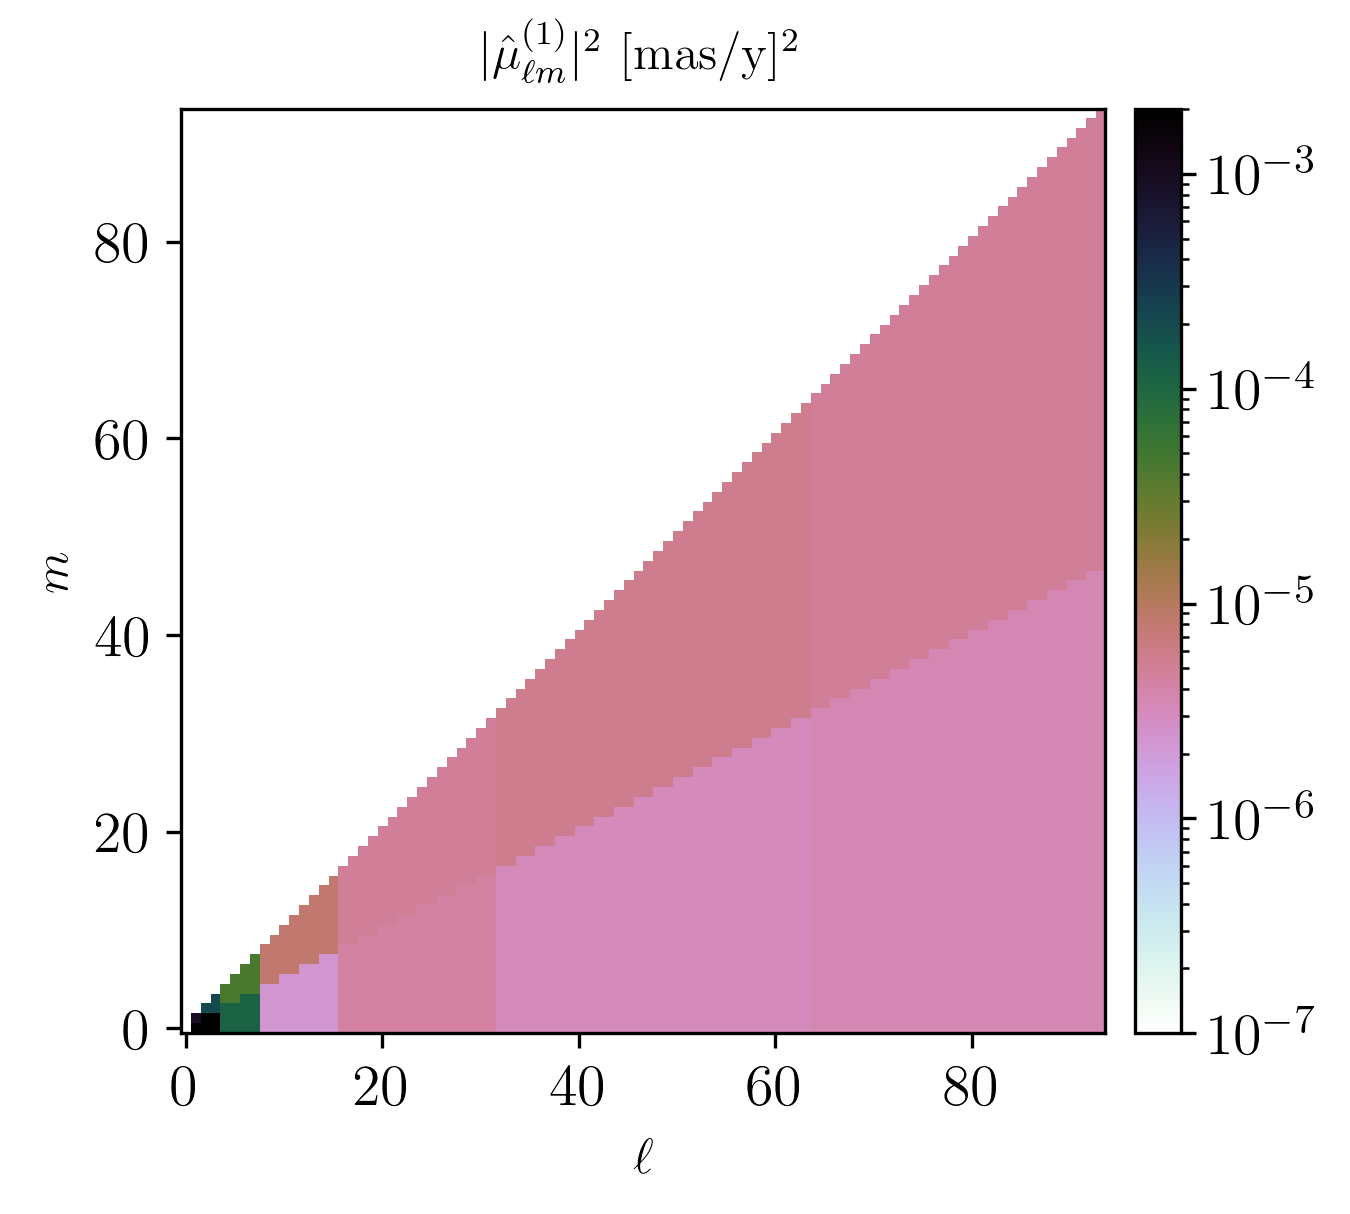

In [234]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im0 = ax.imshow(fn_arr_pow_spec_B(abs(mat_pow1_spec_raw_weight_B),lmax_pre_32),  origin='lower', vmin=vmin_weight_B, vmax=vmax_weight_B, cmap='cubehelix_r',
                   norm=colors.LogNorm(vmin=vmin_weight_B, vmax=vmax_weight_B));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(1)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im0,cax=cax);
fig.savefig('pow1_spec_raw_weight_B.pdf')

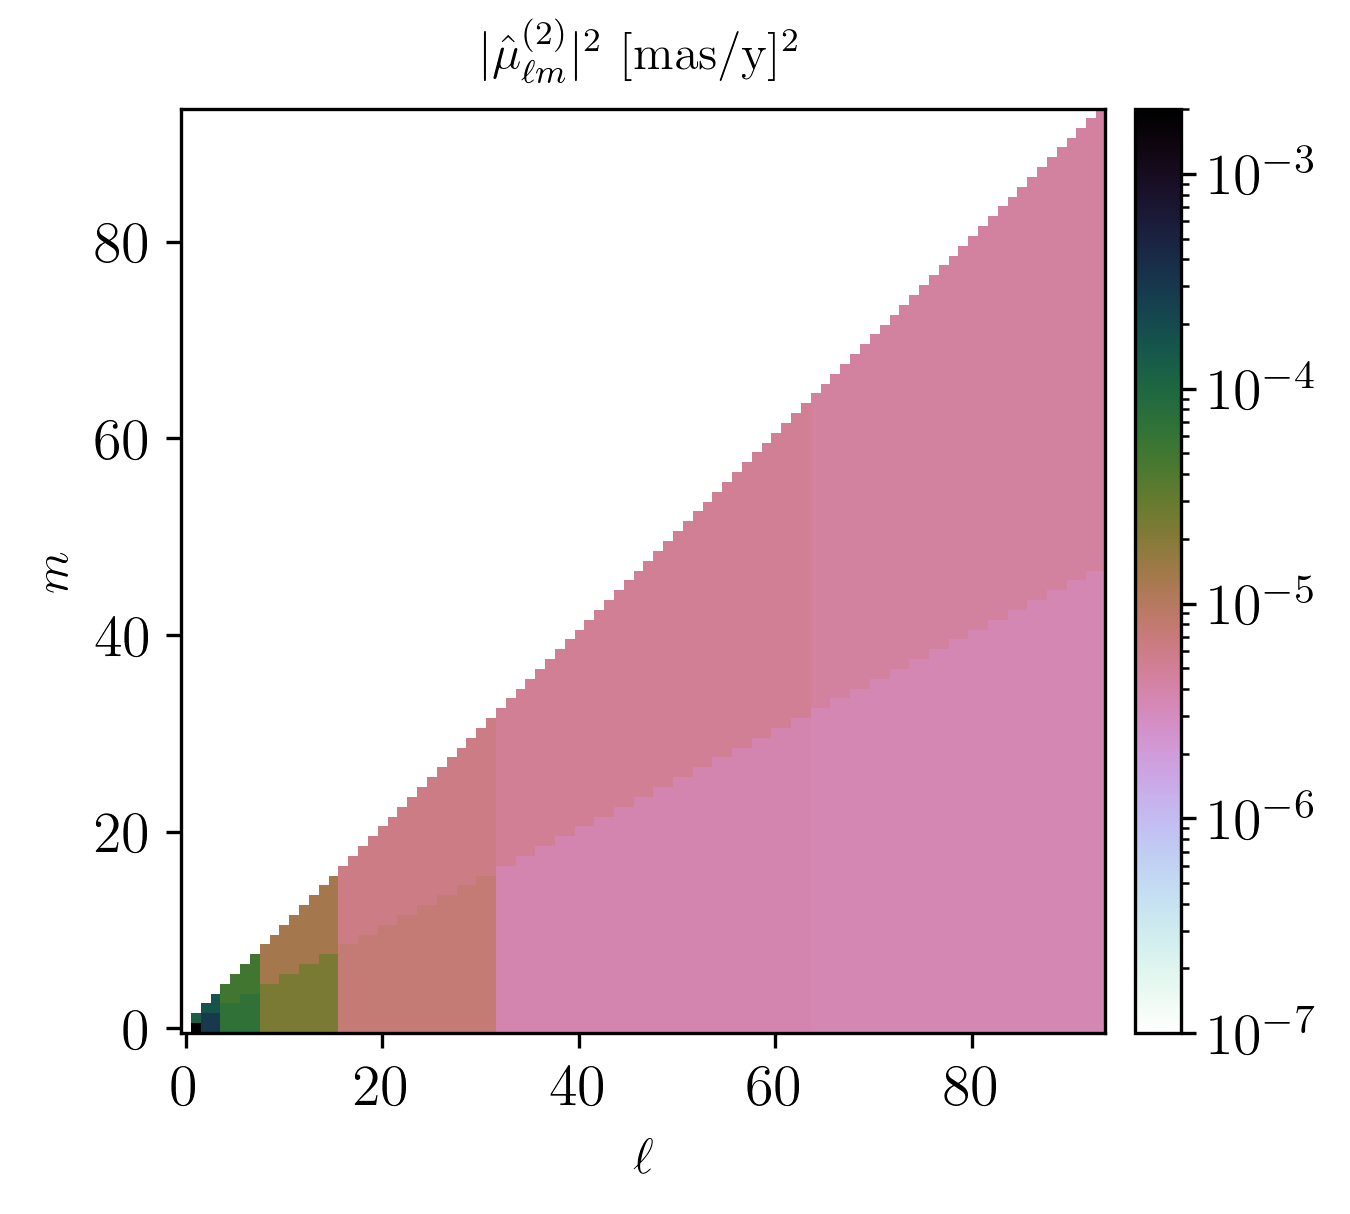

In [235]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im0 = ax.imshow(fn_arr_pow_spec_B(abs(mat_pow2_spec_raw_weight_B),lmax_pre_32),  origin='lower', vmin=vmin_weight_B, vmax=vmax_weight_B, cmap='cubehelix_r',
                   norm=colors.LogNorm(vmin=vmin_weight_B, vmax=vmax_weight_B));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(2)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im0,cax=cax);
fig.savefig('pow2_spec_raw_weight_B.pdf')

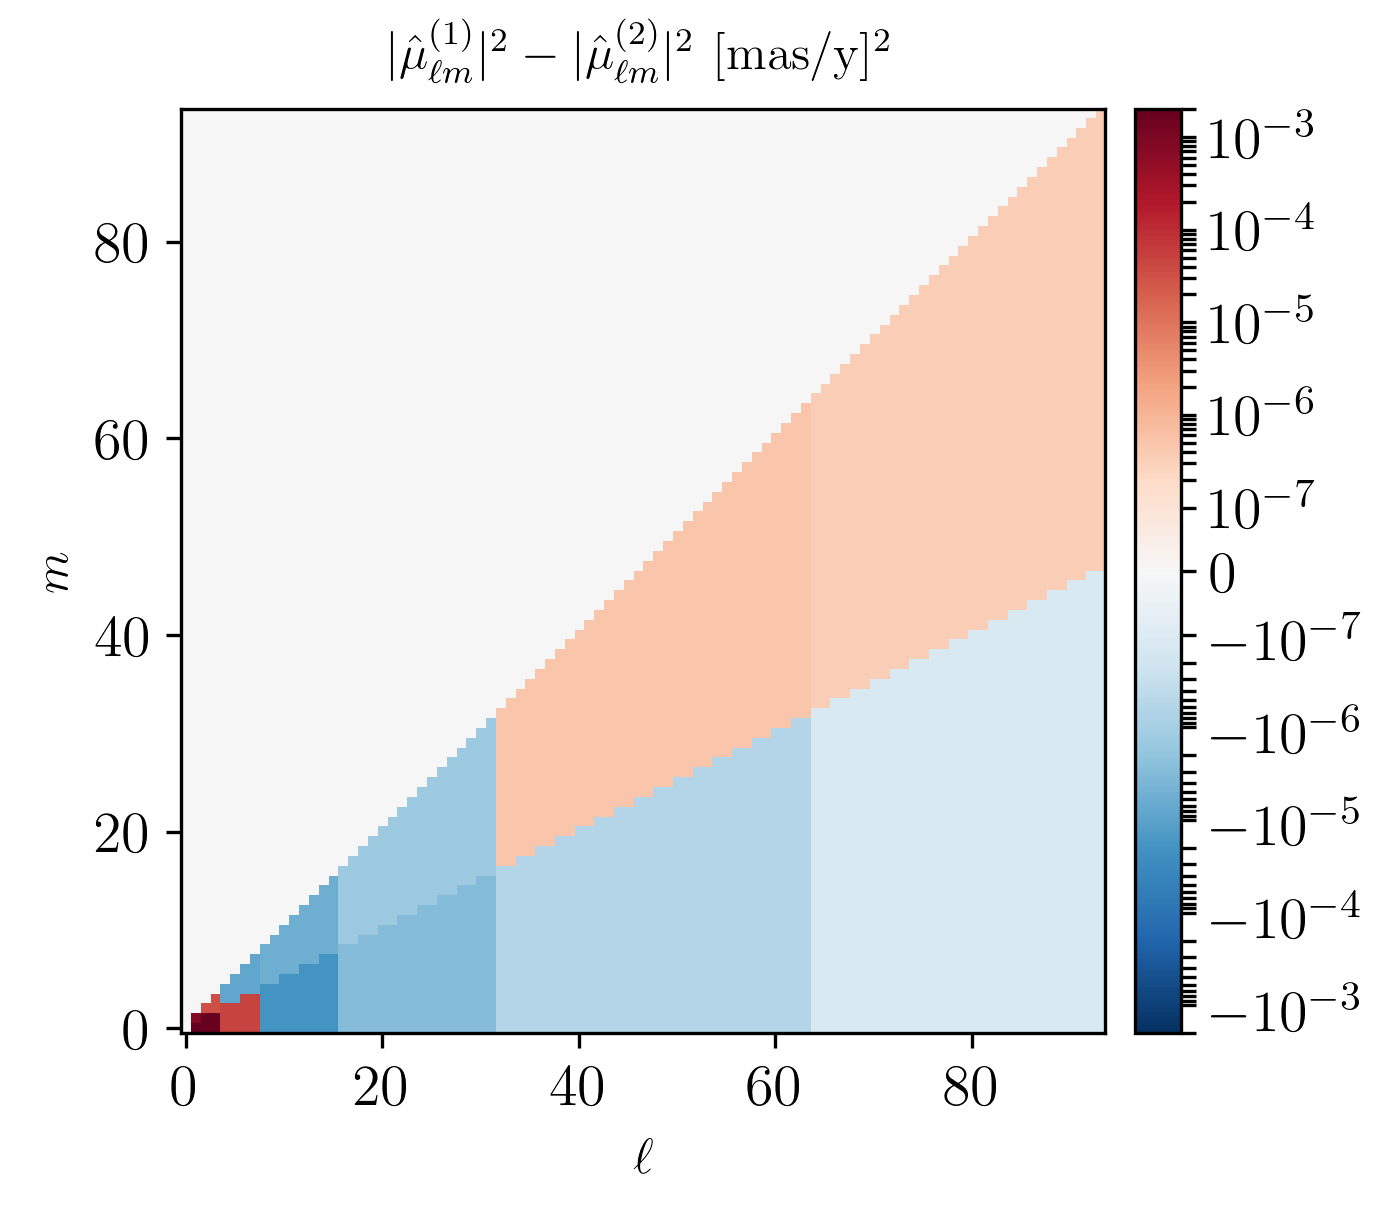

In [236]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im1 = ax.imshow(fn_arr_pow_spec_B(abs(mat_pow1_spec_raw_weight_B)-abs(mat_pow2_spec_raw_weight_B),lmax_pre_32),  
                origin='lower', vmin=-vmax_weight_B, vmax=vmax_weight_B, cmap=cmap, norm=colors.SymLogNorm(linthresh=linthresh_weight_B, linscale=1, vmin=-vmax_weight_B, vmax=vmax_weight_B))
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(1)}_{\ell m}|^2-|\hat{\mu}^{(2)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1,cax=cax);
fig.savefig('pow_diff_spec_raw_weight_B.pdf');

#### 4.2.5 Subtracted data with weight map

In [237]:
data_map_b, data_map_l = pm_b_map_sub, pm_l_map_sub
mat_num1_sig = fn_pow_spec_trim(fn_mat_num1_sig(data_map_b, data_map_l,weights_map))
mat_num2_sig = fn_pow_spec_trim(fn_mat_num2_sig(data_map_b, data_map_l,weights_map))

mat_pow1_spec_sub_weight_B = (1/2) * mat_Fisher_pre_32_B_inv @ (mat_num1_sig @ mat_W_inv_lm_B)
mat_pow2_spec_sub_weight_B = (1/2) * mat_Fisher_pre_32_B_inv @ (mat_num2_sig @ mat_W_inv_lm_B)

In [238]:
vmin_weight_B, vmax_weight_B = 10**(-7),2*10**(-3)
linthresh_weight_B = 10**(-7)

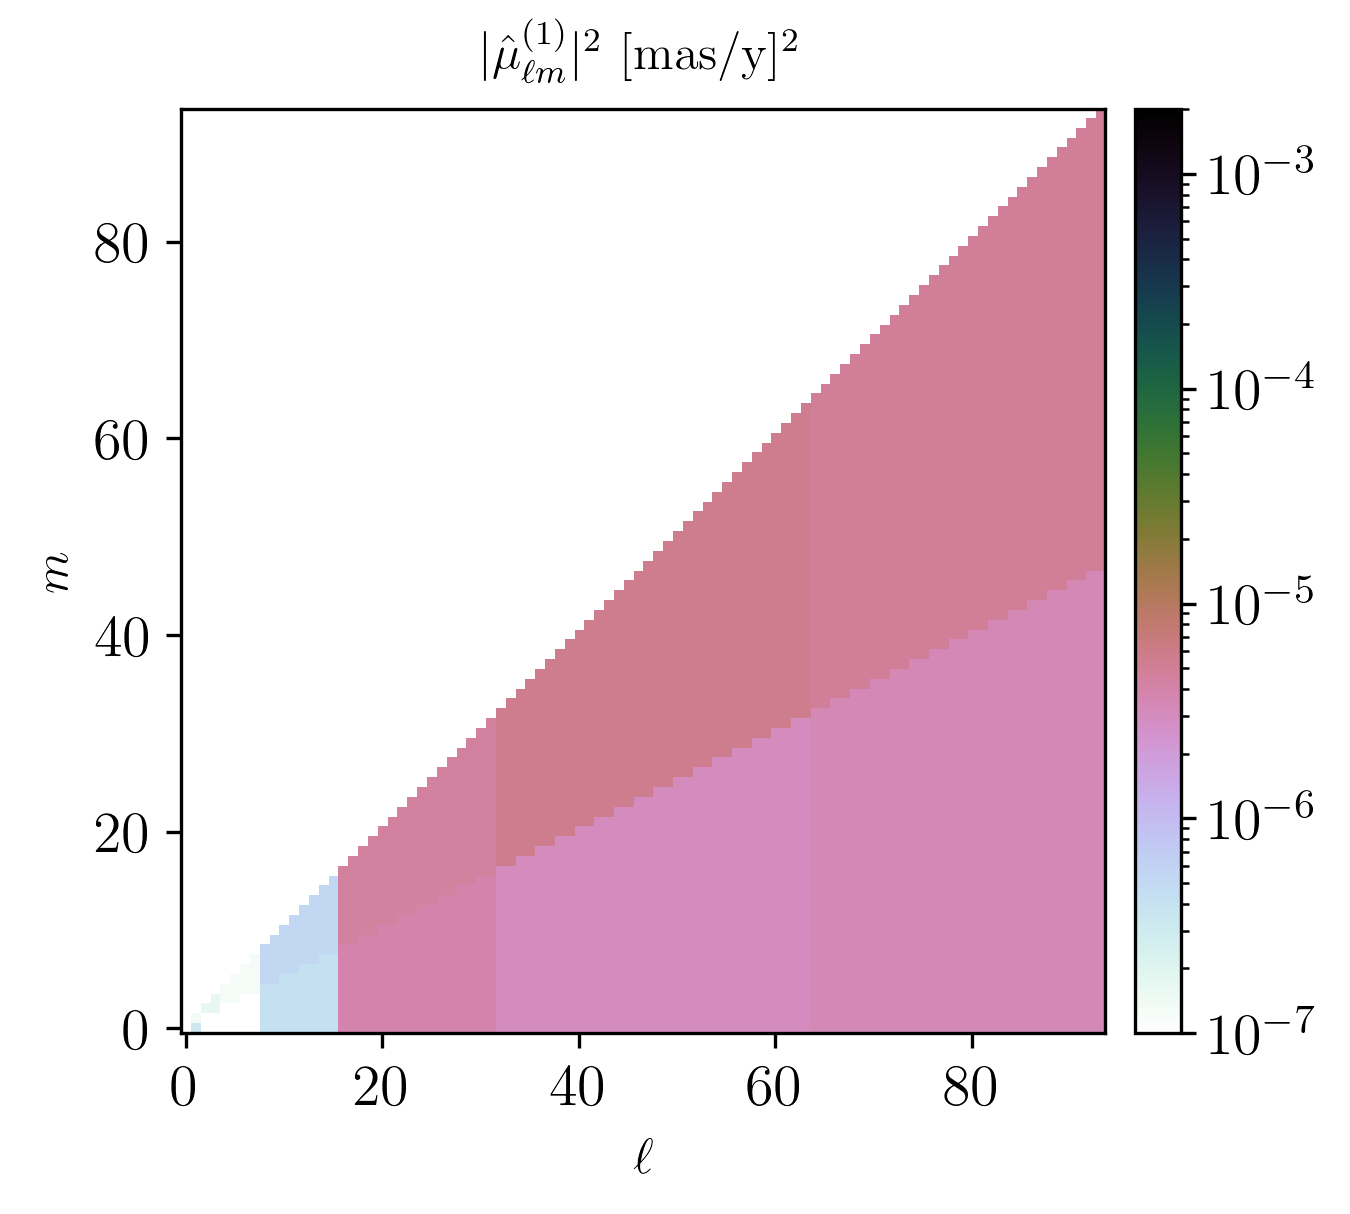

In [239]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im0 = ax.imshow(fn_arr_pow_spec_B(abs(mat_pow1_spec_sub_weight_B),lmax_pre_32),  origin='lower', vmin=vmin_weight_B, vmax=vmax_weight_B, cmap='cubehelix_r',
                   norm=colors.LogNorm(vmin=vmin_weight_B, vmax=vmax_weight_B));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(1)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im0,cax=cax);
fig.savefig('pow1_spec_sub_weight_B.pdf')

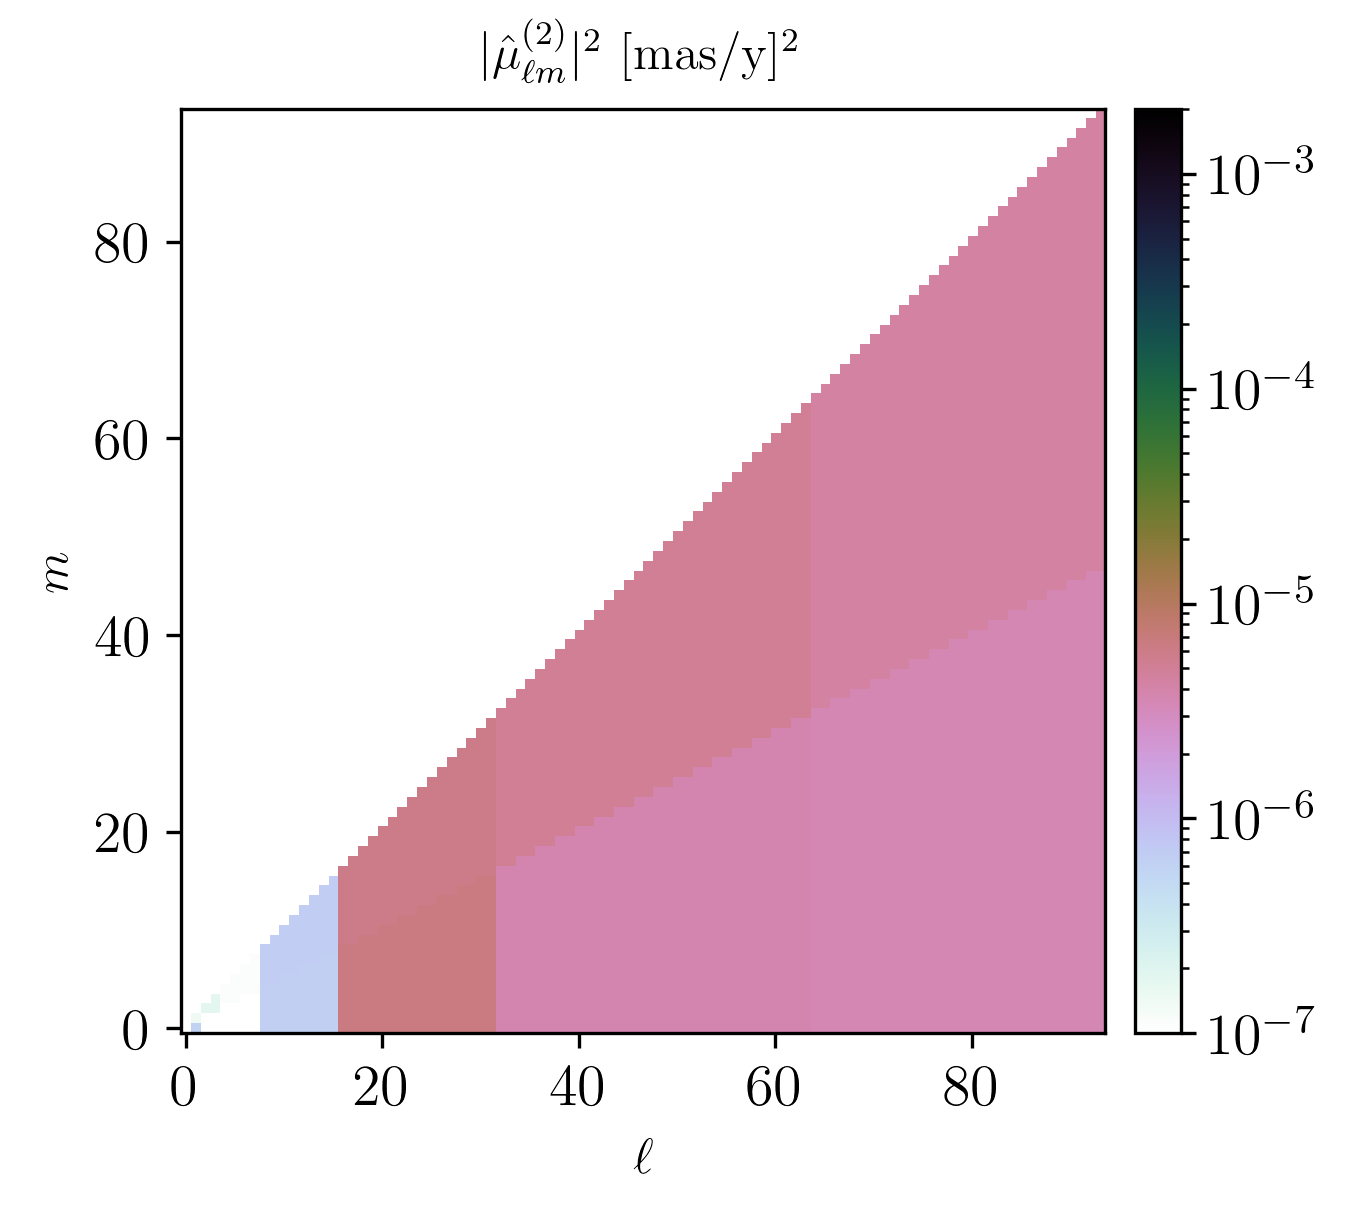

In [240]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im0 = ax.imshow(fn_arr_pow_spec_B(abs(mat_pow2_spec_sub_weight_B),lmax_pre_32),  origin='lower', vmin=vmin_weight_B, vmax=vmax_weight_B, cmap='cubehelix_r',
                   norm=colors.LogNorm(vmin=vmin_weight_B, vmax=vmax_weight_B));
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(2)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im0,cax=cax);
fig.savefig('pow2_spec_sub_weight_B.pdf')

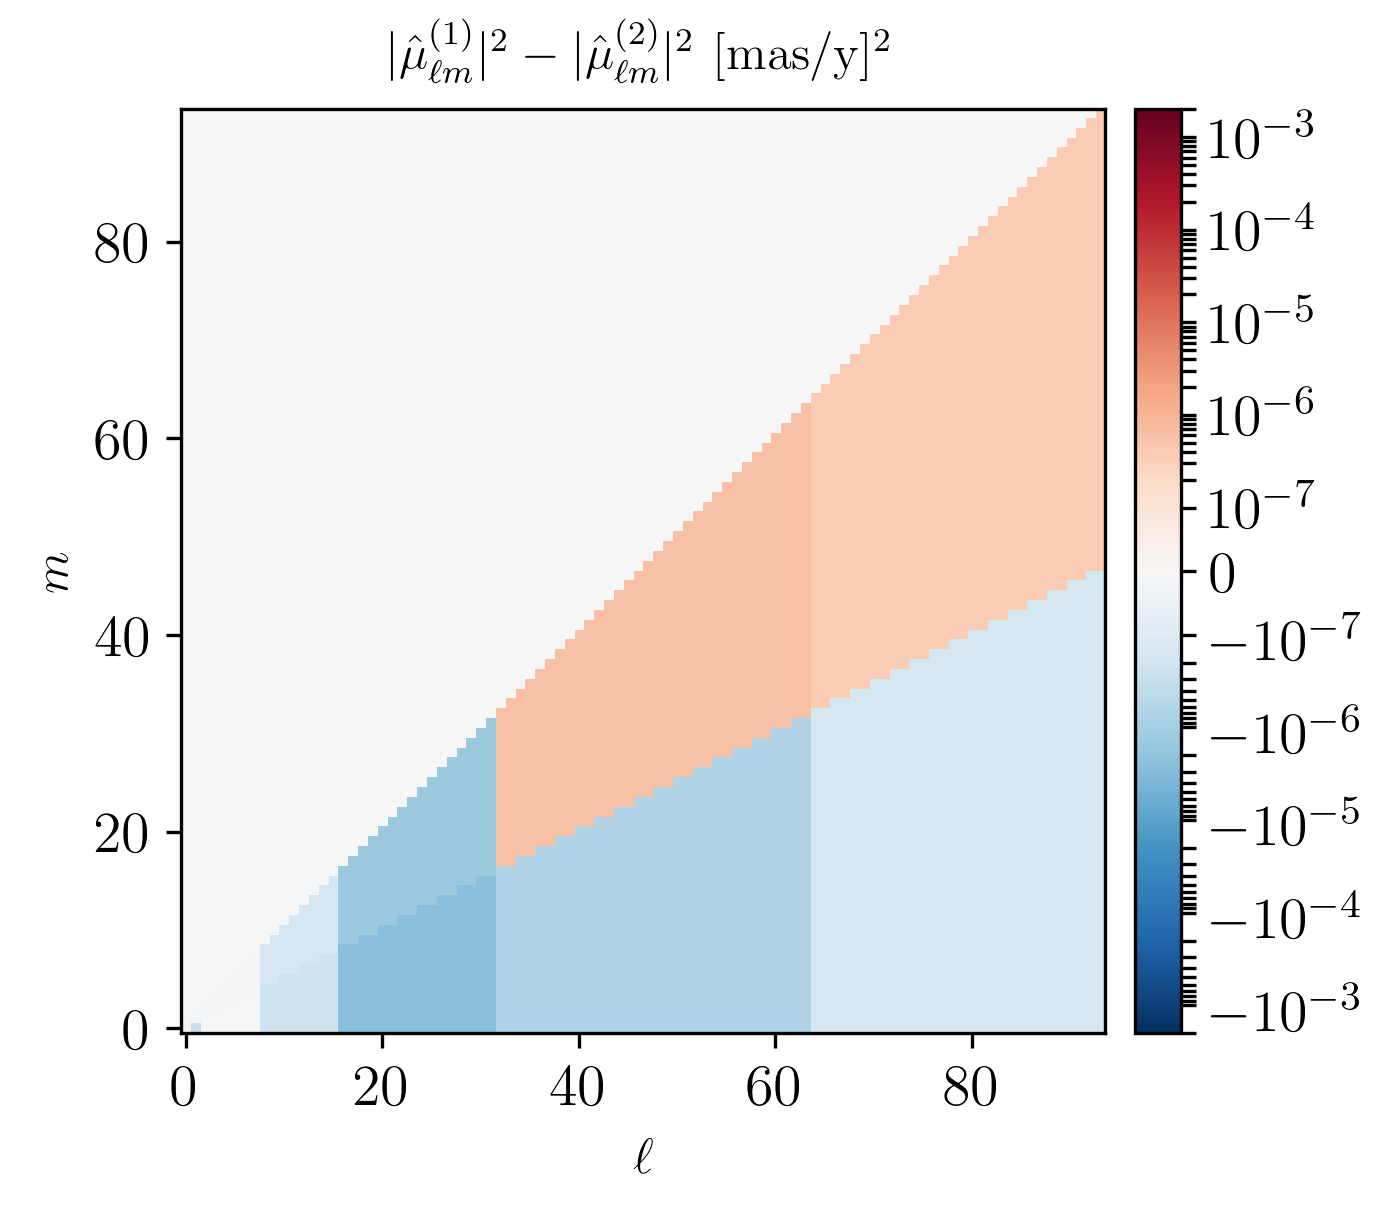

In [241]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
im1 = ax.imshow(fn_arr_pow_spec_B(abs(mat_pow1_spec_sub_weight_B)-abs(mat_pow2_spec_sub_weight_B),lmax_pre_32),  
                origin='lower', vmin=-vmax_weight_B, vmax=vmax_weight_B, cmap=cmap, norm=colors.SymLogNorm(linthresh=linthresh_weight_B, linscale=1, vmin=-vmax_weight_B, vmax=vmax_weight_B))
ax.set_xlabel('$\ell$', fontsize=12)
ax.set_ylabel('$m$',fontsize=12)
ax.set_title('$|\hat{\mu}^{(1)}_{\ell m}|^2-|\hat{\mu}^{(2)}_{\ell m}|^2 \, \,  [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1,cax=cax);
fig.savefig('pow_diff_spec_sub_weight_B.pdf');